Note: To run this notebook on your local machine make sure to download the `processed` directory from `s3://hit-predictor/data/` and store its contents in `../data/processed`. Alternatively, download all the data by running `make data`.

![Hot 100 History and Trends](./assets/hot100_title_img.jpg)

# The Billboard Hot 100

Started by Billboard Magazine the Billboard Hot 100 is the industry standard record chart in the United States. It is published on a weekly basis. 

Chart rankings are based on sales (physical and digital), radio play, and online streaming in the United States. If we define success of a song as commercial success, the charts are a way to understand the mainstream popularity/market value of a song.

The weekly tracking period for sales was initially Monday to Sunday when Nielsen started tracking sales in 1991, but was changed to Friday to Thursday in July 2015. This tracking period also applies to compiling online streaming data. Radio airplay, which, unlike sales figures and streaming, is readily available on a real-time basis, is tracked on a Monday to Sunday cycle (previously Wednesday to Tuesday). A new chart is compiled and officially released to the public by Billboard on Tuesdays. The cut-off date varies throughout time but has consistently been one-week periods. In most recent times it has been published on Saturdays which is the date we'll use as the cut-off date throughout this analysis (any weekday other than Saturday will be rounded up to the next Saturday).

The Billboard Hot 100 is not the most accurate tool for identifying all commercially successful songs as their rules and tracking tools are subject to flaws. A common example of this is their policy to not include songs that weren't released as singles (revoked in 1998). This led to some of the most commercially successful songs never making it onto the Hot 100. Nevertheless, it's the best tool we have readily available.

The Billboard Hot 100 goes way back to 1958 and has had hundreds of songs listed and yet, I'm fascinated that only a small amount of all music makes its way onto this chart. In this notebook I'll explore the songs that make it onto the Hot 100 and in the process answer a few questions, I've always had about this famous weekly list.

In [235]:
import pandas as pd
import numpy as np

# Read in the Hot 100 Data
hot100 = pd.read_csv('../data/processed/hot100.csv',parse_dates=['date','entry_date','exit_date','peak_date','max_leap_date'],sep='\t')

# Drop Duplicates and create Hot 100 data with unique songs
hot100_uniq = hot100.drop_duplicates(subset=['artist','title']).drop('rank',axis=1)
hot100_uniq.set_index(['artist','title'],drop=True,inplace=True)

# Import Train and Test Data as created in the _Step 1 Wrangling Notebook
train = pd.read_csv('../data/processed/train.csv',sep='\t',parse_dates=['date','entry_date','exit_date','peak_date','max_leap_date']).set_index(['artist','title'])
test = pd.read_csv('../data/processed/test.csv',sep='\t',parse_dates=['date','entry_date','exit_date','peak_date','max_leap_date']).set_index(['artist','title'])
combined = pd.concat([train, test]).sort_index()

# Make training data available as hit and non-hit data
hits = train.loc[train.hit == True,:].copy()
nhits = train.loc[train.hit == False,:].copy()

# Set some sensible display options for data investigation
pd.options.display.max_columns = 400
pd.options.display.max_rows = 1000

hot100.head(5)

rank       date  year  month  day  \
0     1 1967-07-08  1967      7    8   
1     2 1967-07-08  1967      7    8   
2     3 1967-07-08  1967      7    8   
3     4 1967-07-08  1967      7    8   
4     5 1967-07-08  1967      7    8   

                                               title               artist  \
0                                              Windy      The Association   
1                                 Little Bit O' Soul  The Music Explosion   
2                         Can't Take My Eyes Off You        Frankie Valli   
3  San Francisco (Be Sure To Wear Flowers In Your...       Scott McKenzie   
4                          Don't Sleep In The Subway         Petula Clark   

   week  reentry  streak  ranked entry_date  entry_week  entry  entry_year  \
0     7        0      13      14 1967-05-27           1     52        1967   
1     9        0      15      16 1967-05-13           1     90        1967   
2     8        0      15      16 1967-05-20           1     74        1967   
3     7        0      11      12 1967-05-27           1     98        1967   
4     6        0       9      10 1967-06-03           1     76        1967   

   entry_month  entry_day  exit_date  exit_week  exit  exit_year  exit_month  \
0            5         27 1967-08-26         14    34       1967           8   
1            5         13 1967-08-26         16    46       1967           8   
2            5         20 1967-09-02         16    35       1967           9   
3            5         27 1967-08-12         12    28       1967           8   
4            6          3 1967-08-05         10    42       1967           8   

   exit_day  peak  peak_date  peak_week  peak_year  peak_month  peak_day  \
0        26     1 1967-05-27          1       1967           5        27   
1        26     2 1967-05-13          1       1967           5        13   
2         2     2 1967-05-20          1       1967           5        20   
3        12     4 1967-05-27          1       1967           5        27   
4         5     5 1967-06-03          1       1967           6         3   

   leap_week  leap  max_leap max_leap_date  max_leap_week  max_leap_year  \
0          7   0.0      24.0    1967-06-03            2.0         1967.0   
1          9   1.0      33.0    1967-05-27            3.0         1967.0   
2          8   4.0      21.0    1967-05-27            2.0         1967.0   
3          7   0.0      43.0    1967-06-03            2.0         1967.0   
4          6   5.0      27.0    1967-06-10            2.0         1967.0   

   max_leap_month  max_leap_day  low  
0             6.0           3.0   52  
1             5.0          27.0   90  
2             5.0          27.0   74  
3             6.0           3.0   98  
4             6.0          10.0   76

In [236]:
# Define Main Columns for different types of data frames
main_cols_hot100 = ['rank','date','week','title','artist','reentry','streak','ranked','entry','exit','peak','low','max_leap','leap']
main_cols_hot100_uniq = ['entry_year','exit_year','reentry','streak','ranked','entry','exit','peak','low','max_leap']
main_cols_analysis = ['id','year','month','day','date','hit','acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','popularity','speechiness','tempo','time_signature','valence']

Let's have a look at the Hot 100 statistics.

In [237]:
hot100.loc[:,main_cols_hot100].describe().T

count       mean        std   min   25%   50%   75%    max
rank      316685.0  50.501094  28.866120   1.0  26.0  51.0  76.0  100.0
week      316685.0   9.045604   7.423191   1.0   4.0   7.0  13.0   87.0
reentry   316685.0   0.125276   0.486193   0.0   0.0   0.0   0.0   14.0
streak    316685.0  15.683979   9.305860   0.0   9.0  15.0  19.0   84.0
ranked    316685.0  17.091207   9.619444   1.0  10.0  16.0  20.0   87.0
entry     316685.0  78.154832  19.982164   1.0  71.0  84.0  92.0  100.0
exit      316685.0  72.582074  23.201009   1.0  49.0  79.0  95.0  100.0
peak      316685.0  30.615116  26.069466   1.0   7.0  24.0  50.0  100.0
low       316685.0  88.102910  13.118246   3.0  83.0  93.0  98.0  100.0
max_leap  314707.0  17.311973  10.813475 -83.0  11.0  15.0  22.0   96.0
leap      288602.0   0.439318  10.227063 -83.0  -4.0   1.0   5.0   96.0

There is 316685 songs for 3167 weeks, meaning we're missing 15 songs. As pointed out in the Wrangling step this is due to some weeks in the Billboard Hot 100 not charting 100 songs but only 99.

The chart above already gives us some insights into the general behavior of songs on the Hot 100. Most songs enter and exit the Hot 100 in the lower half (i.e. entry between 58 and 98 (mean +- std) and exit between 50 and 96).

75% of songs are on the Hot 100 for 20 weeks or less ('ranked') but at least 50% stay on the Hot 100 for 16 weeks or more.

Now, let's have a closer look at the data we're using in this analysis.

# Data

The **Hot 100 charts, hits sample, audio-features and non-hits sample** have been obtained from **Billboard.com (Hot 100)** and the **Spotify API (Audio Features and Non Hits Sample)**

The **hits** sample is a subset of the **Hot 100** charts, enriched using the [Spotify Audio Features Endpoint](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/). Unfortunately, not all songs could be matched with a Spotify ID and retrieved. Hence, **hits** has dropped all songs that came back empty.

The **non-hits** sample is sampled using the [Spotify API Search](https://developer.spotify.com/documentation/web-api/reference/search/search/), randomly sampling a songs by year, so as to find songs that did not become hits. As that method overemphasizes popular songs, I've sampled 20% of each year from the lowest popularity (i.e. Spotify's popularity score).

For more information check out the Wrangling notebook *Wrangling (Hot 100 and Spotify Sample)*.

In [238]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn configuration as default for matplotlib plots
sns.set()

# Set Color Palette
GrayP = ['#ff7cb9',"gray","black"]
sns.set_palette(GrayP)

# Set Matplotlib display settings
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (16,5)

# The History and Rules of the Hot 100

The Hot 100 is a man-made formula that has undergone many changes since its inception in 1958. To understand the underlying structure of the Hot 100 and trends during different time periods it makes sense to understand what rules and changes are reflected in the data to understand what challenges the Hot 100 as a target variable poses.

We'll start by looking into the general distribution of songs in the Hot 100 to better understand the structure within hits. This is a way to identify exceptional songs, those that stick out. Often the most predictive information lies in the extremes, which is why we want to know what those songs are.

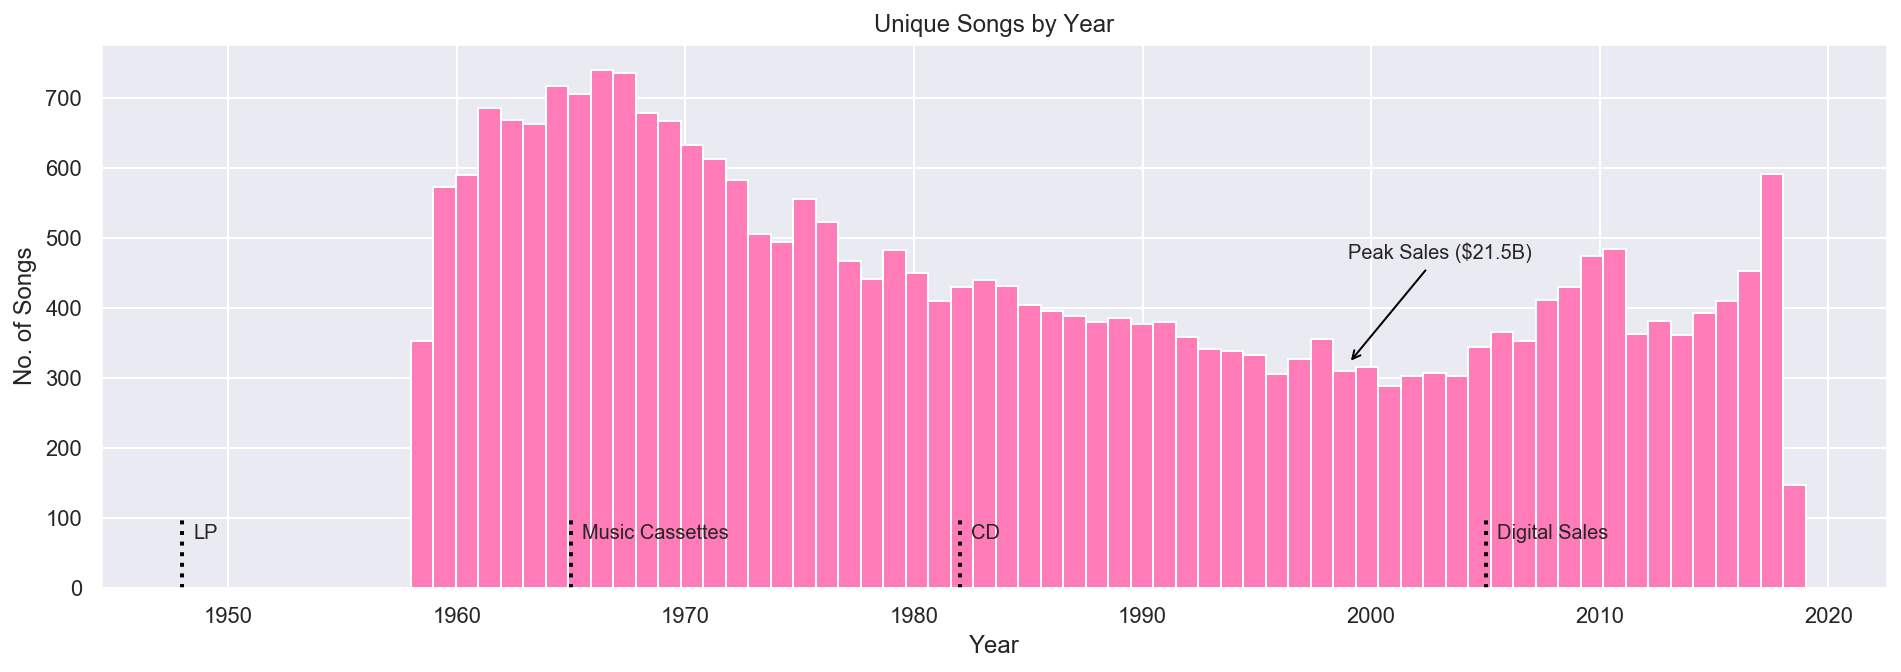

In [239]:
def annotate_timeline(x,text):
    """
    Adds a string at position x on a plotted graph
    """
    _ = plt.plot([x,x],[0,100],linestyle='dotted',linewidth=2,color='black')
    _ = plt.annotate(s=text,xy=(x,20),xytext=(x + .5,70))

# Get unique years
years = len(hot100_uniq['entry_year'].unique())

# Plot a histogram of the unique songs by their entry year
_ = plt.hist(hot100_uniq['entry_year'],bins=years,color=GrayP[0])
_ = plt.title('Unique Songs by Year')
_ = plt.xlabel('Year')
_ = plt.ylabel('No. of Songs')

# Add annotations of important music business and format introduction events
_ = annotate_timeline(1948,'LP')
_ = annotate_timeline(1965,'Music Cassettes')
_ = annotate_timeline(1982,'CD')
_ = plt.annotate(s='Peak Sales ($21.5B)',xy=(1999,320),xytext=(1999,470),arrowprops=dict(arrowstyle="->",color='black'))
_ = annotate_timeline(2005,'Digital Sales')

In [240]:
# Number of Unique Songs on the Hot 100 since 1958
print("Since 1958 there were *{}* songs on the Billboard Hot 100.".format(len(hot100_uniq)))

Since 1958 there were *28083* songs on the Billboard Hot 100.


It looks like starting in the 1970s songs increasingly prolonged their stay on the Billboard Hot 100 (streak length increased) and we had less fluctuation (i.e. new songs entering and old songs dropping off). However, in more recent years, starting in 2005, this fluctuation seems to be picking back up again.

One of the lowest fluctuation points also coincides with the high point of sales in the music industry.

This trend should be more visible in the duration songs stayed on the Hot 100 - that is streak lengths.

# Streaks

There are several indicators of popularity and one of those is the length of a song staying on the Hot 100 as it shows consistent interest by radio stations and the public (i.e. radio play, sales etc.). 

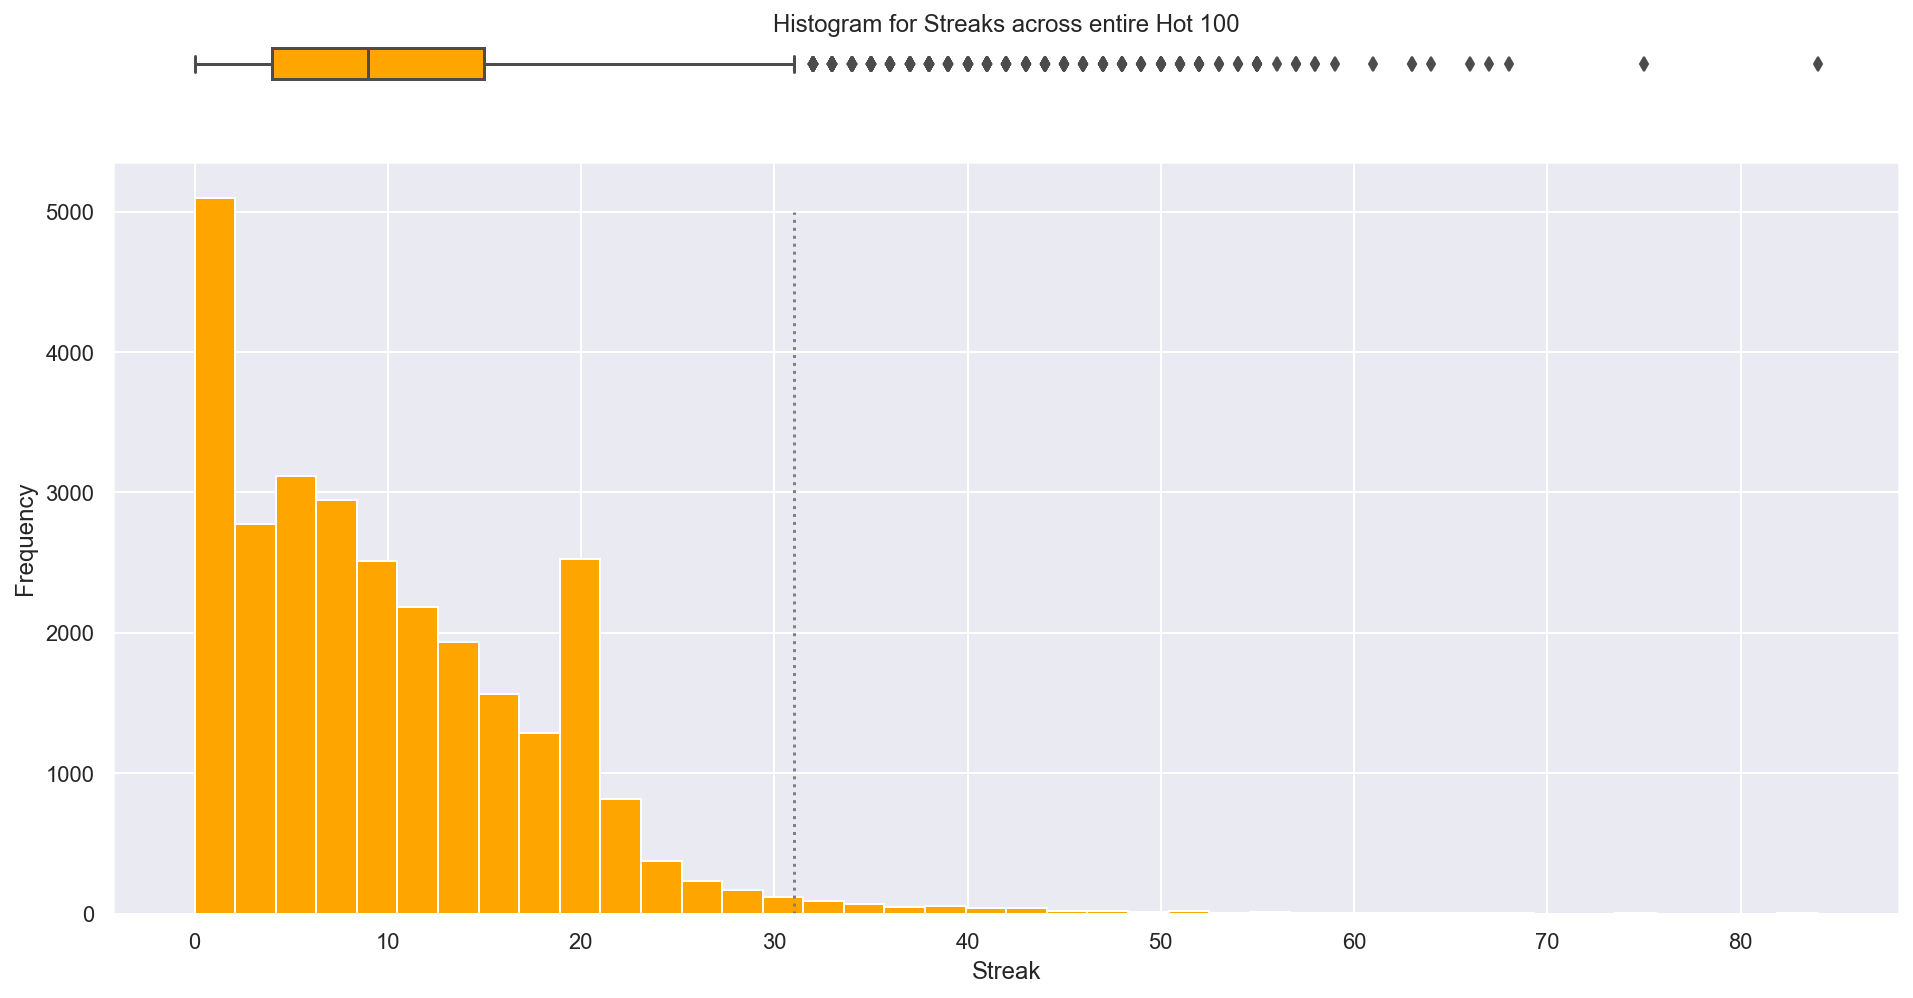

Outliers in Streaks across the entire data set (according to 1.5 IQR rule): >31


In [241]:
# Set new color palette
GrayO = ['orange',"gray","black"]
sns.set_palette(GrayO)

def get_outlier_boundary(series, k=1.5):
    """
    Returns the upper boundary of a Series at which a data point is considered an outlier according to 
    'Tukey's Fences' Rule `Q3+k(Q3-Q1)` using k = 1.5 by default
    """
    first_q = series.quantile(q=0.25)
    third_q = series.quantile(q=0.75)
    iqr = (third_q - first_q)
    return int(third_q + k * iqr)

def create_hist(x,std=False,xticks=False,bins=50,figsize=(16,8)):
    """
    Creates a Histogram of `x` with a boxplot at the top. Optionally adding markers at the .95 confidence interval
    or 1.96 standard deviations from the mean.
    """
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.05, .95)}, figsize=figsize)

    _ = sns.boxplot(x, ax=ax_box,saturation=1)
    _ = ax_box.grid(False)
    _ = ax_box.set_facecolor('white')
    _ = ax_box.set(yticks=[])
    _ = ax_box.set_xlabel(None)

    _ = ax_hist.hist(x,bins=bins)
    _ = ax_hist.set_ylabel('Frequency')
    if xticks:
        _ = ax_hist.set_xticks(np.arange(xticks[0],xticks[1]+xticks[2],xticks[2]))
    if std:
        plus_two_std = x.mean() + x.std()*1.96
        minus_two_std = x.mean() - x.std()*1.96
        _ = ax_hist.plot([plus_two_std,plus_two_std],[0,500],c='black')
        _ = ax_hist.annotate(s='μ + 2σ',xy=[plus_two_std,500],xytext=[plus_two_std - 3,550])
        _ = ax_hist.plot([minus_two_std,minus_two_std],[0,500],c='black')
        _ = ax_hist.annotate(s='μ - 2σ',xy=[minus_two_std,500],xytext=[minus_two_std - 3,550])
    return ax_box,ax_hist

# Create a Histogram of the Hot 100 streaks (unique songs)
ax_box, ax_hist = create_hist(hot100_uniq['streak'],xticks=(0,80,10),bins=40)
_ = ax_box.set_title('Histogram for Streaks across entire Hot 100')
_ = ax_hist.set_xlabel('Streak')

ax_hist.plot([31,31],[0,5000],linestyle='dotted')

plt.show()

# Get the Upper Boundary for Outliers
upper_whisker = get_outlier_boundary(hot100_uniq['streak'])
print('Outliers in Streaks across the entire data set (according to 1.5 IQR rule): >{}'.format(upper_whisker))

We can see a contrinuous fall as we're getting toward the higher streak lengths. One interesting peak can be observed at streak length 20. For some reason this bin is defying the downward trend. 

We'll have a closer look at this distribution by year in the next plot.

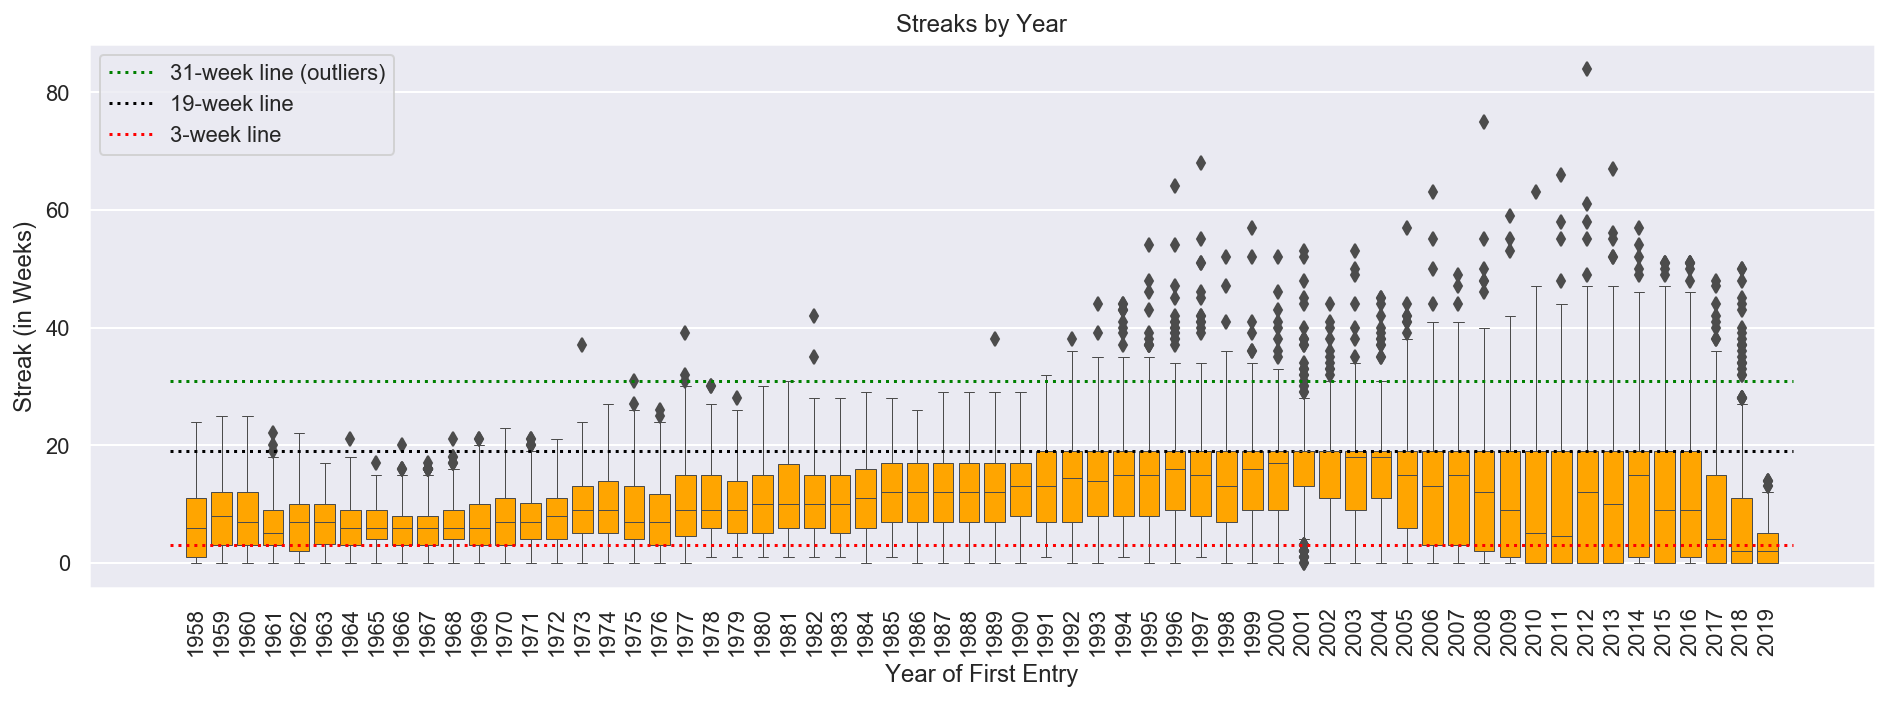

In [242]:
_ = sns.boxplot(x='entry_year',y='streak',data=hot100_uniq,color=GrayO[0],saturation=1,linewidth=0.5)
_ = plt.plot([-1,62],[upper_whisker,upper_whisker],c='green',linestyle='dotted',label='31-week line (outliers)')
_ = plt.plot([-1,62],[19,19],c='black',linestyle='dotted',label='19-week line')
_ = plt.plot([-1,62],[3,3],c='red',linestyle='dotted',label='3-week line')
_ = plt.xticks(rotation=90)
_ = plt.title('Streaks by Year')
_ = plt.xlabel('Year of First Entry')
_ = plt.ylabel('Streak (in Weeks)')
_ = plt.legend()

plt.show()

### 19-week Pattern of lower 75% (third quartile)

Between 1991 and 2016 the third quartile (i.e. upper quartile) is consistently at 19 streak weeks (i.e. 20th ranked week due to the 0-indexing). There's no deviation from this pattern, no single year has a third quartile that surpasses this threshold. Looking into the underlying formula it looks like it has to do with a Hot 100 rule introduced in 1991 with the intend to speed up fluctuation ([20-20 rule](https://web.stanford.edu/~xhnguyen/BillboardandTechnology.pdf)). This rule specifies that a song that has fallen out of the top 20 will be removed after 20 weeks. The rule was relaxed in 1992 and 1993 to falling out of the top 40 and top 50 respectively.

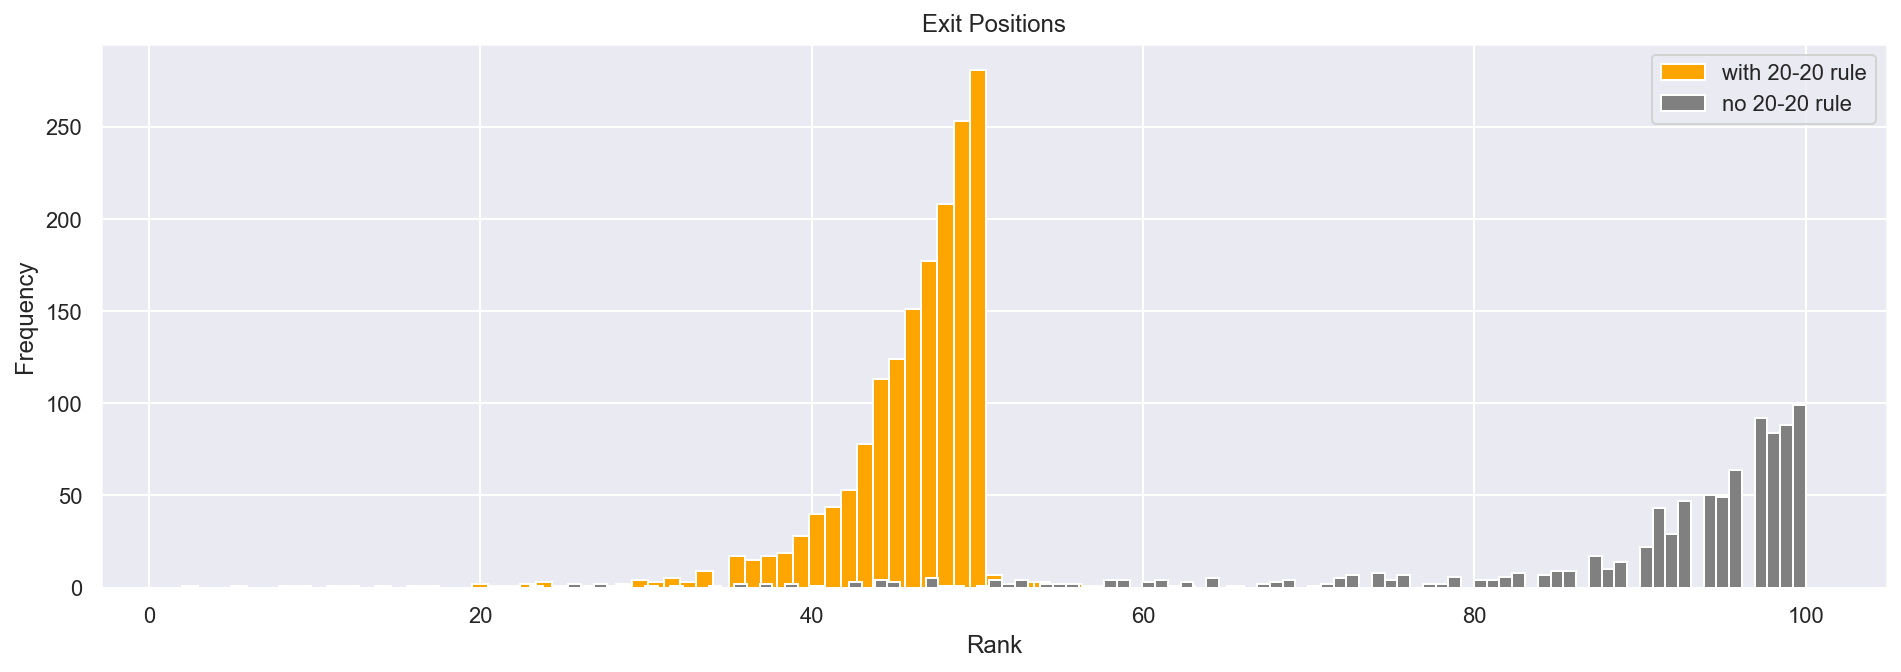

Number of songs whose streak was likely cut short: 1693


In [243]:
_ = plt.hist(hot100_uniq.loc[(hot100_uniq['streak']>19) & (hot100_uniq['exit_year']>1991),'exit'], bins=100, label='with 20-20 rule')
_ = plt.hist(hot100_uniq.loc[(hot100_uniq['streak']>19) & (hot100_uniq['exit_year']<=1991),'exit'], bins=100, label='no 20-20 rule')
_ = plt.title('Exit Positions')
_ = plt.xlabel('Rank')
_ = plt.ylabel('Frequency')
_ = plt.legend()
plt.show()

print("Number of songs whose streak was likely cut short: {}".format(len(hot100_uniq.loc[(hot100_uniq['streak']>19) & (hot100_uniq['exit_year']>1991),'exit'])))

Above we can see the exit positions of songs with >19 weeks streak before and after the 20-20 rule. It can be assumed that this rule has cut the streak of songs after 1991 short as we can see that generally songs would exit at the bottom of the Hot 100 (see `no 20-20 rule`) rather than dropping off suddenly.

From this plot it's hard to tell whether the 20-20 rule has achieved it's goal as we're unable to compare the data without the Nielsen Soundscan change that occurred at the same time, which claims to have introduced much more detailed sales information.

### Higher Fluctuation in Recent Years

Going back to the `Streaks by Year` plot. Starting in 2006 we can see that the first quartile (i.e. lower quartile) is stretching into the <3 weeks region. A pattern we hadn't seen since the mid-1970s. This would indicate a higher fluctuation and is probably a result of Billboard slowly incorporating more and more online sales and streaming revenue into their formula since 2005 (https://en.m.wikipedia.org/wiki/Billboard_Hot_100 see _Digital downloads and online streaming_). 

### Super Songs

Until the early 1970s no song title would be on the Hot 100 for more than 25 weeks and until the early 1990s staying charted for over 31 weeks (i.e. outliers across the entire data as shown above) was the rare exception. In fact, there are only 6 artists who've achieved this feat (they are listed below).

There is a clear pattern distinction between the charts after 1991 and previous periods. 1991 happens to be the year that the Hot 100 started to use Nielsen Soundscan, which gathered more precise music sales data (previously sales numbers were self-reported by stores). [Hot 100 Formula changes](https://en.wikipedia.org/wiki/Billboard_Hot_100) and [discussion](https://ndsmcobserver.com/2018/01/billboard-hot-100-controversy/)

In [244]:
outlier_bf_1991 = hot100_uniq.loc[(hot100_uniq['year'] < 1991) & (hot100_uniq['streak'] > upper_whisker),['streak','peak','entry','exit']]
outlier_af_1991 = hot100_uniq.loc[(hot100_uniq['year'] >= 1991) & (hot100_uniq['streak'] > upper_whisker),['streak','peak','entry','exit']]

print("Number of Titles that stayed on the Hot 100 for more than 31 weeks \nBefore 1991 (33 years) - {}\nAfter 1991 (29 years) - {}".format(len(outlier_bf_1991),len(outlier_af_1991)))

Number of Titles that stayed on the Hot 100 for more than 31 weeks 
Before 1991 (33 years) - 6
After 1991 (29 years) - 430


In [245]:
outlier_bf_1991.sort_values(by='streak',ascending=False).head(10)

streak  peak  entry  exit
artist             title                                           
Soft Cell          Tainted Love               42     8     90    97
Paul Davis         I Go Crazy                 39     7     89    99
Young M.C.         Bust A Move                38     7     81    90
Kris Kristofferson Why Me                     37    16    100    52
Laura Branigan     Gloria                     35     2     84    98
Bee Gees           How Deep Is Your Love      32     1     83    59

Go to Playlist: https://open.spotify.com/user/1162788143/playlist/0iP1Sz5qSCmVomZUNYbKPj?si=8SyDMByGRK60HNPHv9-HZA

In [246]:
outlier_af_1991.sort_values(by='streak',ascending=False).head(10)

streak  \
artist                                    title                                         
Imagine Dragons                           Radioactive                              84   
Jason Mraz                                I'm Yours                                75   
LeAnn Rimes                               How Do I Live                            68   
OneRepublic                               Counting Stars                           67   
LMFAO Featuring Lauren Bennett & GoonRock Party Rock Anthem                        66   
Jewel                                     Foolish Games/You Were Meant For Me      64   
Adele                                     Rolling In The Deep                      63   
Carrie Underwood                          Before He Cheats                         63   
The Lumineers                             Ho Hey                                   61   
Lady Antebellum                           Need You Now                             59   

                                                                               peak  \
artist                                    title                                       
Imagine Dragons                           Radioactive                             3   
Jason Mraz                                I'm Yours                               6   
LeAnn Rimes                               How Do I Live                           2   
OneRepublic                               Counting Stars                          2   
LMFAO Featuring Lauren Bennett & GoonRock Party Rock Anthem                       1   
Jewel                                     Foolish Games/You Were Meant For Me     2   
Adele                                     Rolling In The Deep                     1   
Carrie Underwood                          Before He Cheats                        8   
The Lumineers                             Ho Hey                                  3   
Lady Antebellum                           Need You Now                            2   

                                                                               entry  \
artist                                    title                                        
Imagine Dragons                           Radioactive                             93   
Jason Mraz                                I'm Yours                               93   
LeAnn Rimes                               How Do I Live                           89   
OneRepublic                               Counting Stars                          32   
LMFAO Featuring Lauren Bennett & GoonRock Party Rock Anthem                       78   
Jewel                                     Foolish Games/You Were Meant For Me     61   
Adele                                     Rolling In The Deep                     68   
Carrie Underwood                          Before He Cheats                        92   
The Lumineers                             Ho Hey                                  90   
Lady Antebellum                           Need You Now                            85   

                                                                               exit  
artist                                    title                                      
Imagine Dragons                           Radioactive                            49  
Jason Mraz                                I'm Yours                              48  
LeAnn Rimes                               How Do I Live                          45  
OneRepublic                               Counting Stars                         50  
LMFAO Featuring Lauren Bennett & GoonRock Party Rock Anthem                      49  
Jewel                                     Foolish Games/You Were Meant For Me    47  
Adele                                     Rolling In The Deep                    49  
Carrie Underwood                          Before He Cheats                       47  
The Lumineers                             Ho Hey

Go to Playlist: https://open.spotify.com/user/1162788143/playlist/4hzjzSssha8VLHqwbyJiWA?si=xWT5wbXAR7OOeuyCrQKO-w

_NOTE: Unfortunately, there is 52 of the 430 songs missing from the playlist that couldn't be found on Spotify or are missing due to country restrictions._

In [247]:
longest_streak = hot100_uniq.loc[hot100_uniq.streak >= upper_whisker,main_cols_hot100_uniq].sort_values(by='streak',ascending=False)

50% of songs stayed on the Hot 100 for less than 10 weeks. The longest streak is 84 weeks and is held by 'Imagine Dragons' with 'Radioactive', a not so close runner-up is 'Jason Mraz' with 'I'm Yours' (75 weeks). 

Again we can see the effect of the 20-20 rule in the second song set's `exit` column - most songs exited on a position slightly before or at 50.

Let's look at outliers for the streak variable (>31 weeks) by year to have a better look at their distribution.

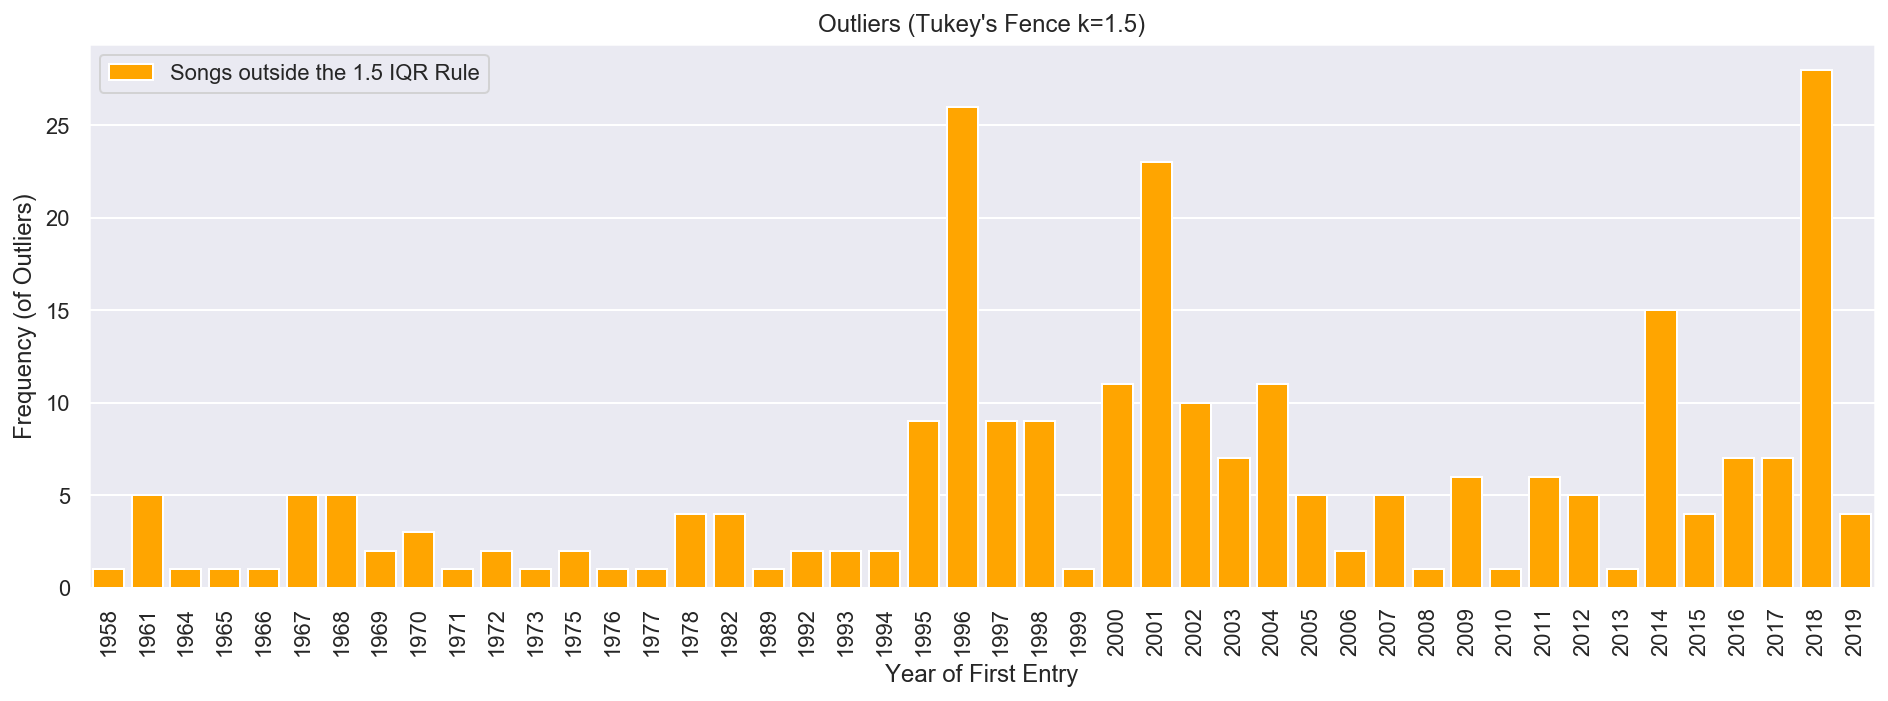

Standard Deviations:
<1991: 5.703656742368894
>=1991: 10.154355499124337


In [249]:
# Define outlier_boundary by year and retrieve outliers
outlier_boundary = hot100_uniq.groupby(by='year').streak.apply(get_outlier_boundary)
outlier_boundary.name = 'outlier_boundary'
hot100_streak = hot100_uniq.merge(outlier_boundary,on=['year'],how='left')
outliers = hot100_streak.loc[hot100_streak['streak'] > hot100_streak['outlier_boundary'], :]

# Plot data
sns.countplot(outliers.year,color=GrayO[0],saturation=1)
plt.xlabel('Year of First Entry')
plt.xticks(rotation=90)
plt.ylabel('Frequency (of Outliers)')
plt.title('Outliers (Tukey\'s Fence k=1.5)')
plt.legend(['Songs outside the 1.5 IQR Rule'])
plt.show()

# Print Standard Deviation along the 1991 boundary
std_bf_1991 = hot100_uniq.loc[hot100_uniq['year'] < 1991,'streak'].std()
std_af_1991 = hot100_uniq.loc[hot100_uniq['year'] >= 1991,'streak'].std()
print("Standard Deviations:\n<1991: {}\n>=1991: {}".format(std_bf_1991,std_af_1991))

Despite the introduction of the 20-20 rule, starting in 1995 we can see a pattern of what I'm going to call 'Super Songs' emerge. Before 1995, there were only few songs that stayed long enough to be considered an outlier (Tukey's Fence rule). After 1993, however we can suddenly see these breakout songs occuring much more often. Standout years are 1996, 2001 and 2018 but other years are generating outliers more densely as well. This is despite (or due to?) a generally larger standard deviation in streaks on the Hot 100 after 1991. We can also see in the first streak plot that the outliers tend to stray further than outliers before 1991 (i.e. they stay longer on the hot 100 or are 'stickier').

### Is there a significant difference between the distribution of the Hot 100 before and after the introduction of Nielsen Soundscan data?

Throughout the above analysis, we've seen the year 1991 reappear over and over again as a cut-off point. It is time to understand whether and how Nielsen Soundscan might've affected the Hot 100. 

Let's first have a look at the distributions before and after 1991.

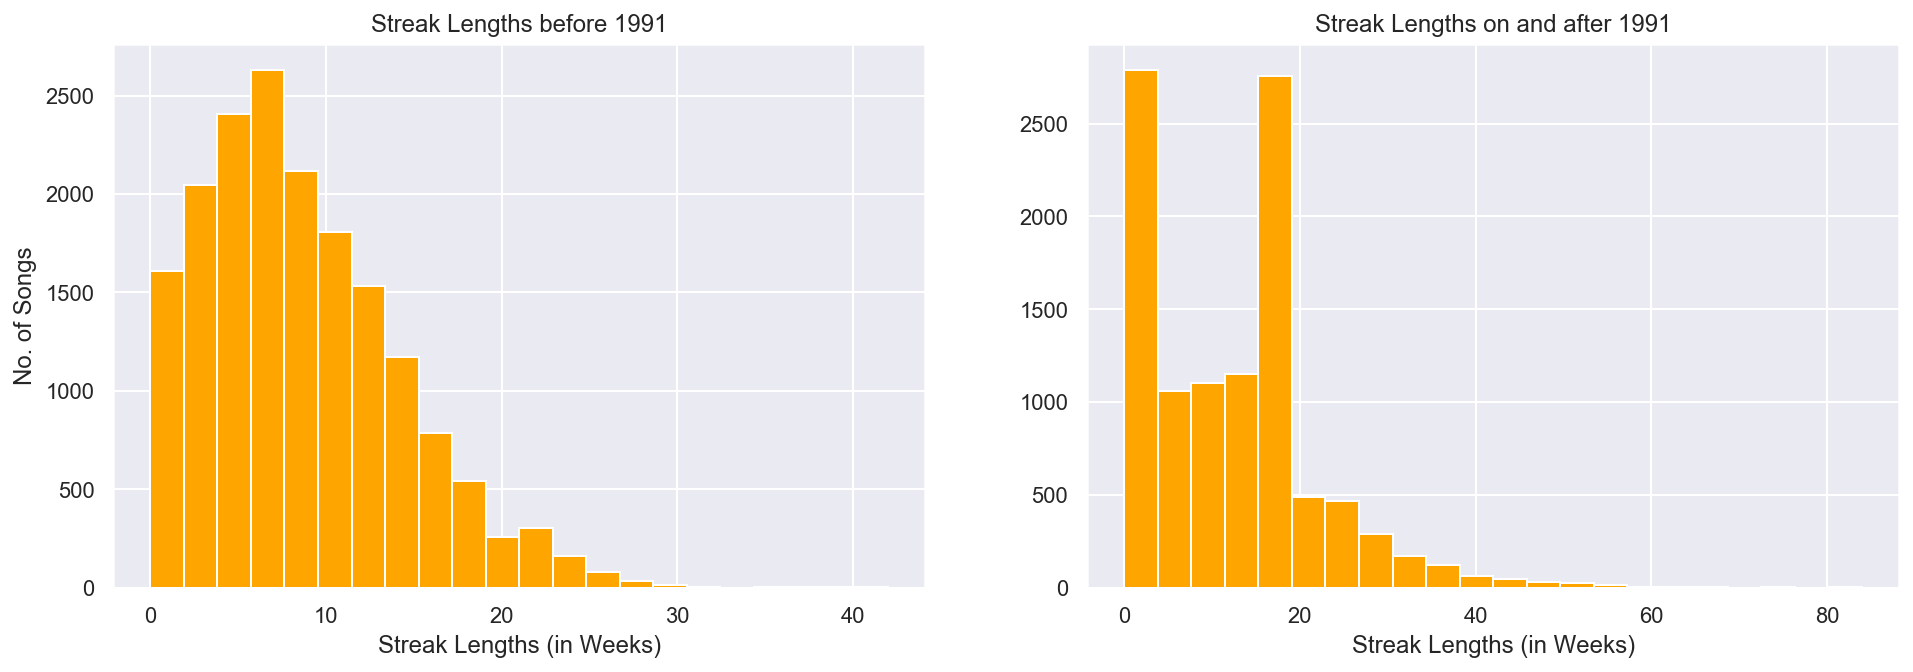

In [198]:
fig, ax = plt.subplots(1,2)

strk_len_bf_1991 = hot100_uniq.loc[hot100_uniq['year'] < 1991,'streak']
strk_len_af_1991 = hot100_uniq.loc[hot100_uniq['year'] >= 1991,'streak']

plt.subplot(1,2,1)
_ = plt.hist(strk_len_bf_1991,bins=22)
_ = plt.title('Streak Lengths before 1991')
_ = plt.xlabel('Streak Lengths (in Weeks)')
_ = plt.ylabel('No. of Songs')

plt.subplot(1,2,2)
_ = plt.hist(strk_len_af_1991,bins=22)
_ = plt.title('Streak Lengths on and after 1991')
_ = plt.xlabel('Streak Lengths (in Weeks)')

If the only change affecting the data was the 20-20 rule and the Nielsen Soundscan and other unknown factors had no effect on the streak length, we would expect roughly the same distribution for songs of 20 or less weeks on the Hot 100. However, we can see that the distribution of Hot 100 songs before and after 1991 are very different. The streaks length for songs after 1991 is far more left skewed than before. Most songs are in the lowest bin, only rivaled by the 19 weeks (i.e. 20 weeks with 0-indexing) bin, which we will assume was introduced by the 20-20 rule.

To see whether the change in distribution is statistically significant we're going to compare the mean of the distributions with a one-sided test. The assumption being that if the distributions of the population are equal beyond the 20-20 rule the mean of the distributions after 1991 should be lower than before 1991 as the 20-20 rule would prevent relatively more songs from going beyond 20 weeks on the Hot 100.

- **H0**: The mean streak length after 1991 is equal or lower than the mean streak length before 1991. This would indicate that the Nielsen Data did not affect an increase in streak lengths.
- **H1**: The mean streak length after 1991 is larger than the mean streak length before 1991. This would indicate that the Nielsen Data did have an effect on the increase in streak lengths.
- **alpha**: 0.05

In [250]:
def bootstrap_replicate_1d(data,func):
    """
    Generate bootstrap replicate of 1D data
    """
    
    # Generate samples from data allowing data points to be redrawn (sampling with putting back)
    bs_sample = np.random.choice(data,len(data))
    
    return func(bs_sample)

def draw_bs_reps(data,func,size=1):
    """
    Creates an array of bootstrap replicates for one dimensional data
    """
    
    # Create an empty numpy array of size=size
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates and store them in array
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)
        
    return bs_replicates

def shift_data(data1, data2):
    """
    Shifts datasets to the combined mean
    """
    
    # Get the means of Data 1 and Data 2
    mean1 = data1.mean()
    mean2 = data2.mean()

    # Get the mean difference of the point estimates
    empirical_diff_means = mean1 - mean2
    
    # Get the combined mean
    mean_both = pd.concat([data1,data2]).mean()

    # Shift data sets to the combined mean
    shifted1 = data1 - mean1 + mean_both
    shifted2 = data2 - mean2 + mean_both
    
    return shifted1, shifted2, empirical_diff_means

# Shift Streak Lengths
strk_bf_shifted, strk_af_shifted, empirical_diff_means = shift_data(strk_len_bf_1991,strk_len_af_1991)

# Create Replicates
bs_replicates_bf = draw_bs_reps(strk_bf_shifted,np.mean,10000)
bs_replicates_af = draw_bs_reps(strk_af_shifted,np.mean,10000)

# Generate Mean Differences for replicates of shifted data
bs_replicates = bs_replicates_bf - bs_replicates_af

# Get ratio of mean differences that are smaller or equal to point estimate mean difference
p = np.sum(bs_replicates <= empirical_diff_means) / len(bs_replicates)

print("p: {}".format(p))

p: 0.0


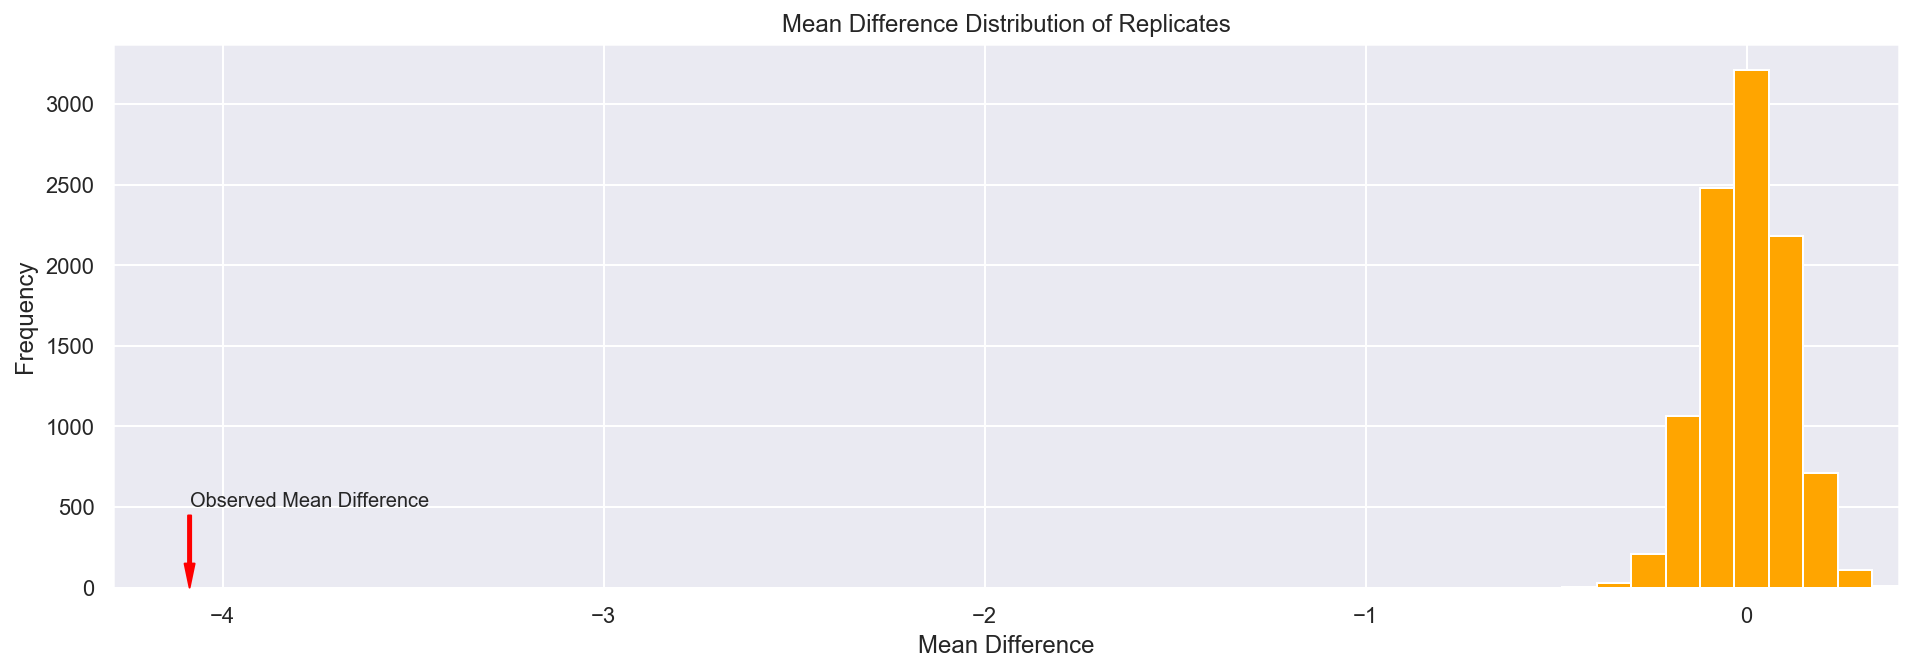

In [251]:
_ = plt.hist(bs_replicates)
_ = plt.title('Mean Difference Distribution of Replicates')
_ = plt.annotate(s='Observed Mean Difference',xy=(empirical_diff_means,0),xytext=(empirical_diff_means,500),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})
_ = plt.xlabel('Mean Difference')
_ = plt.ylabel('Frequency')
_ = plt.xlim(empirical_diff_means-0.2,0.4)


It is highly unlikely that the introduction of Nielsen Data has had no effect on the distribution of the Hot 100. We can reject H0 for alpha > 0.001. 

An argument could be made that without the introduction of the 20-20 rule along with the Nielsen Soundscan the Hot 100 could've become much staler than it already was. The 20-20 rule only offset the negative effect on fluctuation that was introduced by more accurate sales data.

### What have we learned?

In conclusion, through the years the Hot 100 had gotten more and more stale. We've seen less fluctuation of new unique songs being introduced to the Hot 100 more detailed sales data in the early 90s (Nielsen Soundscan) might've amplified that trend and was only held back by artificial streak length hurdles (20-20 rule). Since the 1970s unique songs per year had continually decreased, the change in that trend didn't come until the introduction of digital sales in the formula in 2005 and streaming data (i.e. Spotify, Youtube etc.). While it hasn't returned to its former diversity we've seen a small upwards trend in unique songs per year in recent years.

It was also argued that Nielsen Soundscan, with its addition of more granular data on song's actual sales data allowed the emergence of 'Super Songs', i.e. regular appearance of songs that stay on the Hot 100 for more than 31 weeks.

# The relationship of Peak Position and Streak Length

A common assumption I've always had was songs that have a higher peak position tend to stay on the Hot 100 longer. Let's investigate that assumption below.

In [252]:
# Set new color palette
GrayG = ['#40c493',"gray","black"]
sns.set_palette(GrayG)

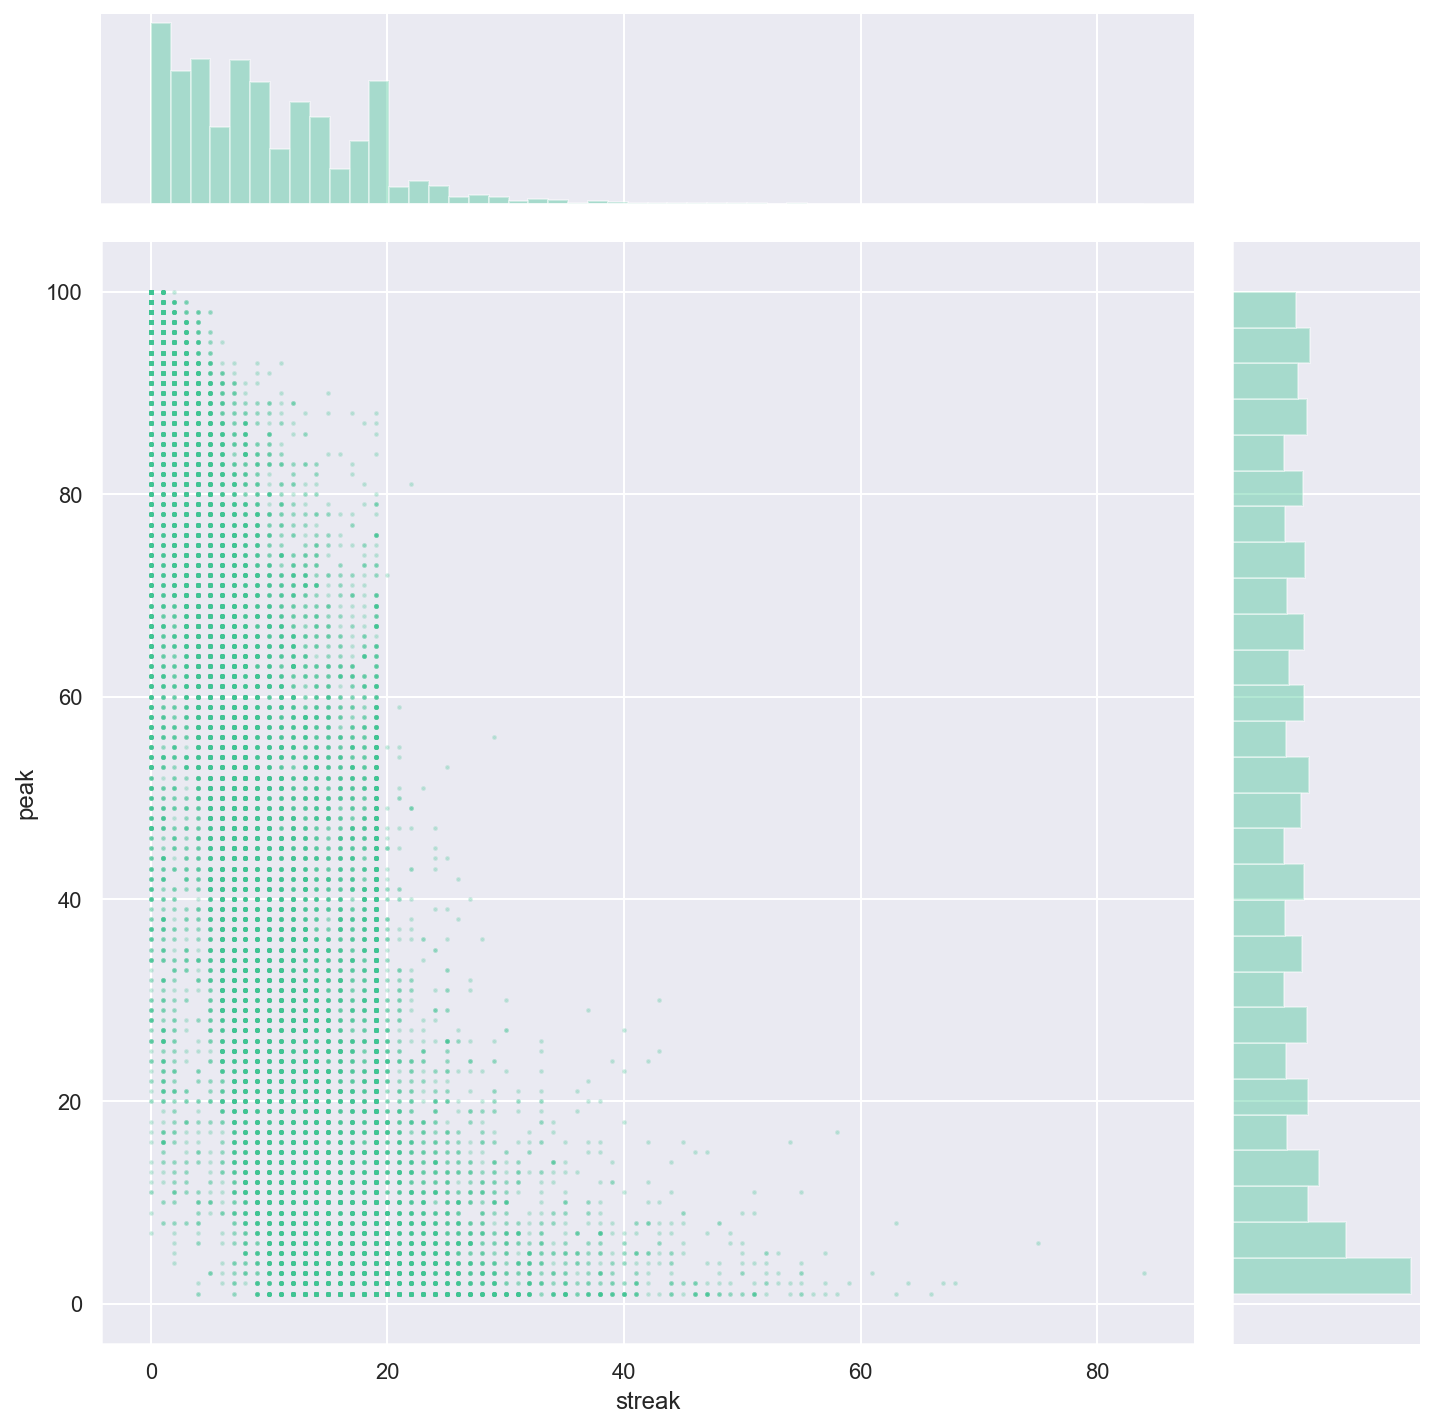

Spearman's R: -0.7857196745443265 p-value: 0.0


In [253]:
from scipy.stats import spearmanr

# Store streak and peak variables
streak = hot100_uniq['streak']
peak = hot100_uniq['peak']

# Create a Joint Plot
jp = sns.jointplot(streak,peak,s=2,alpha=0.2,height=10)

plt.show()

print("Spearman's R: {} p-value: {}".format(spearmanr(streak,peak)[0],spearmanr(streak,peak)[1]))

We can see a roughly linear monotonic relationship (tested using Spearman's R) with a p value of 0. This means that there certainly is a relationship between streak lengths and peak position. The higher the peak position is the longer a song tends to stay on the Hot 100. We can see that this seems to be especially true for songs that make it onto the top 20. 

We had to use Spearman's R in this case as Pearson's R requires a normality assumption, which due to the inherent 1-100 scale is rarely given.

_Quick Note: At Streak position 19 we can see an unusually bold line, this clearly demarcates the skewedness that the so-called "20-20 rule" (explained above) has introduced into the data._

### Pole Position Streaks

Now we know that songs that have higher peak positions tend to stay on the hot 100 longer but we've also seen that the pole position (i.e. rank 1) has the highest number of unique songs (see histogram of Joint plot above) indicating that this is a highly battled over position. Staying on the Hot 100 is one thing but I'm curious what songs were able to stay on the Hot 100's most coveted position the longest.

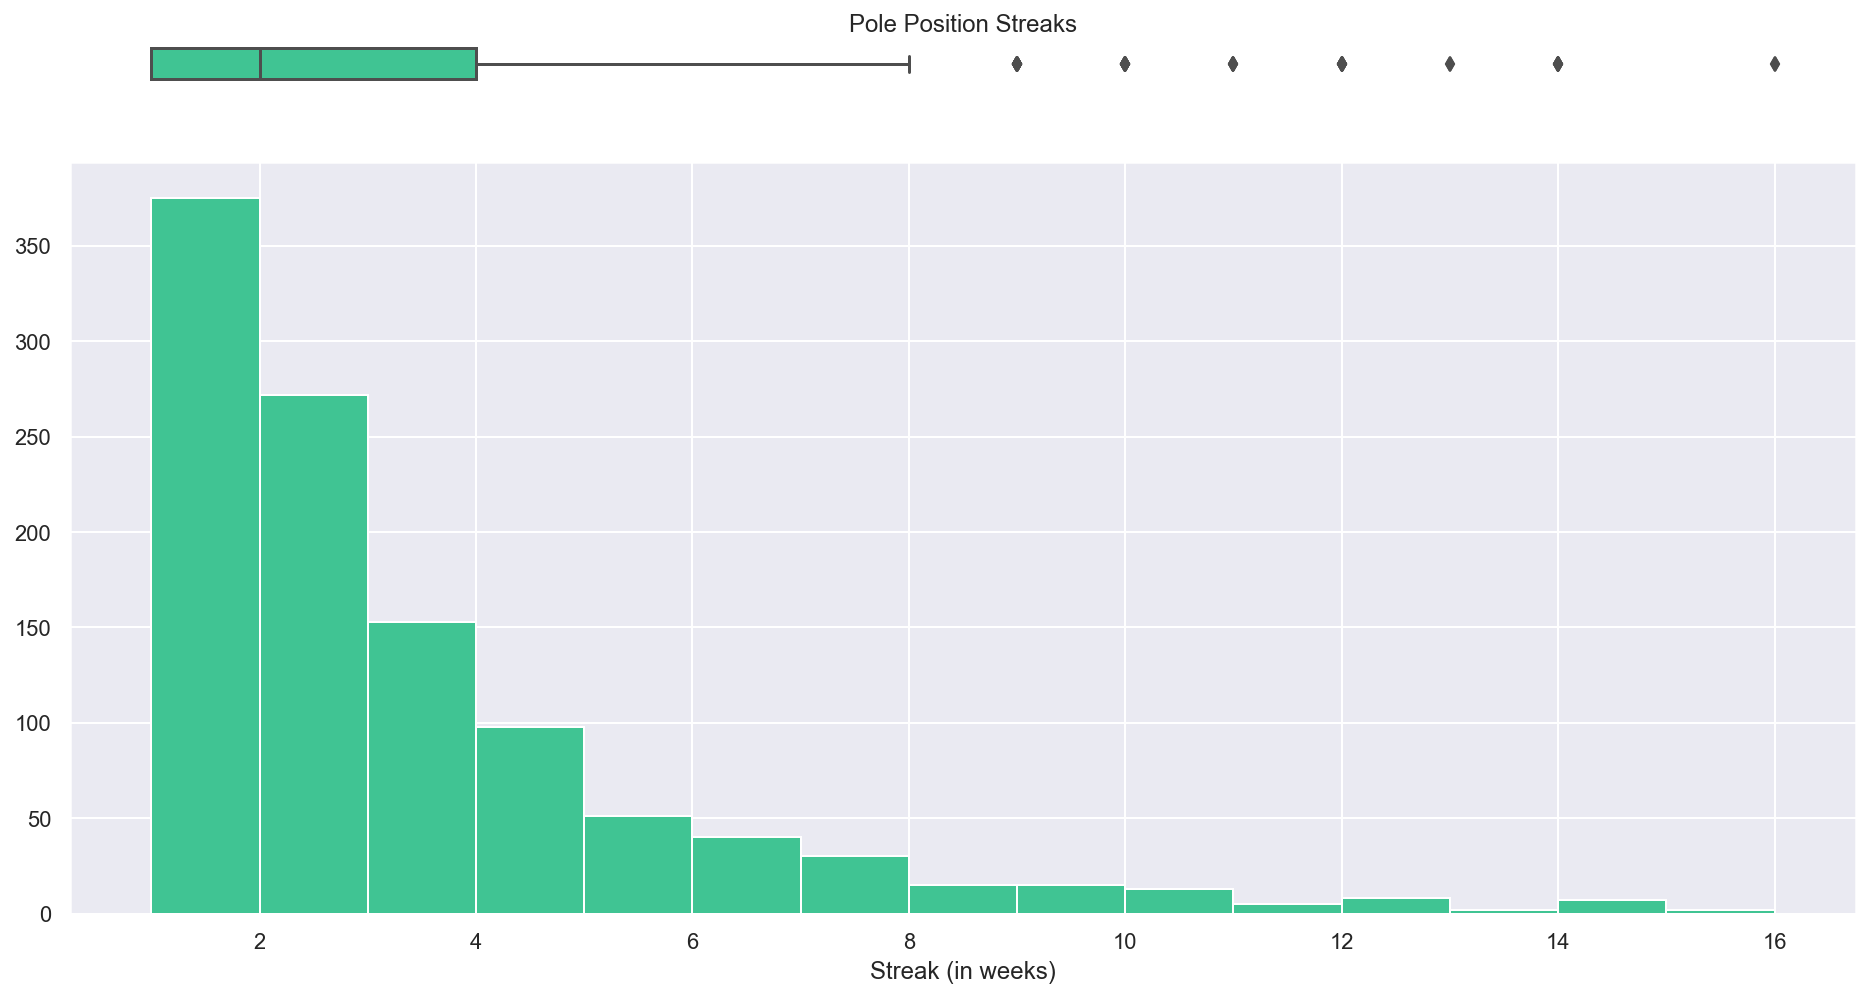

In [145]:
longest_nr_1 = hot100.loc[hot100['rank'] == 1,['artist','title','rank']].rename(columns={'rank':'weeks'}).groupby(by=['artist','title']).count()
ax_box, ax_hist = create_hist(longest_nr_1['weeks'],bins=15)
_ = ax_box.set_title('Pole Position Streaks')
_ = ax_hist.set_xlabel('Streak (in weeks)')

In [18]:
longest_nr_1.sort_values(by='weeks',ascending=False).head(2)

weeks
artist                                            title               
Luis Fonsi & Daddy Yankee Featuring Justin Bieber Despacito         16
Mariah Carey & Boyz II Men                        One Sweet Day     16

In [19]:
print("Total No.1 Hits: {}".format(len(longest_nr_1)))

Total No.1 Hits: 1086


We can see 1086 songs made it to the top of the Hot 100 charts and that less than 50% of those lasted more than 2 weeks on the Hot 100 pole position. Of those only 2 songs were able to stay on the very top of the Hot 100 charts for 16 weeks (i.e. the longest streak).

# Movements

### Who jumped the furthest? Leaps

Now that we've looked at peak positions and streaks, I'm interested to know how the jumps from one position (i.e. a leap) to another are distributed.

In [147]:
# Set new color palette
GrayB = ['#41b6c4',"gray","black"]
sns.set_palette(GrayB)

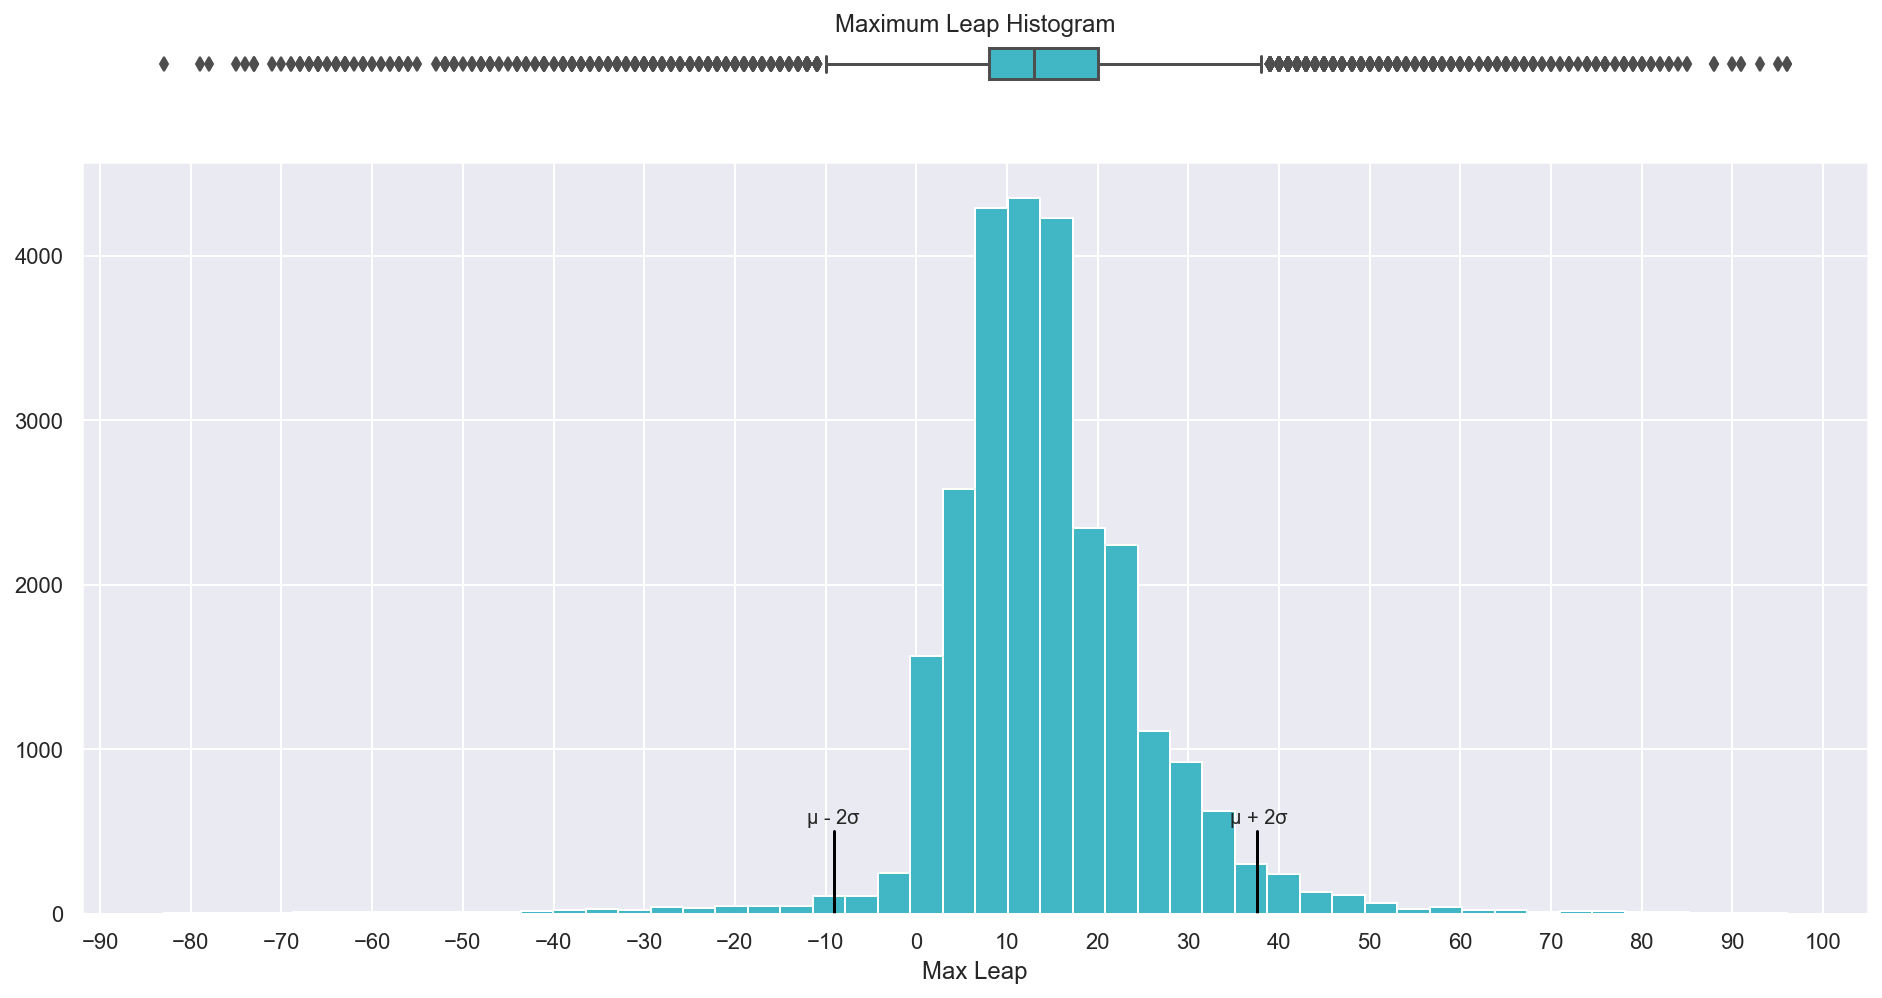

In [148]:
max_leap = hot100_uniq['max_leap'].dropna()

ax_box, ax_hist = create_hist(max_leap,std=True,xticks=(-100,100,10))

_ = ax_box.set_title('Maximum Leap Histogram')
_ = ax_hist.set_xlabel('Max Leap')

We see that the median leap was just above 10 positions and that we can generally expect for most titles to leap at most between 7-19 places. We also can see that leaps beyond 38 positions are generally rare, so are negative maximum leaps beyond -9 (i.e. titles that consistently fell in position from their initial entry).

We can also see that generally a title moves up at some point during their time on the Hot 100 due to the shift of the distribution to values above 0.

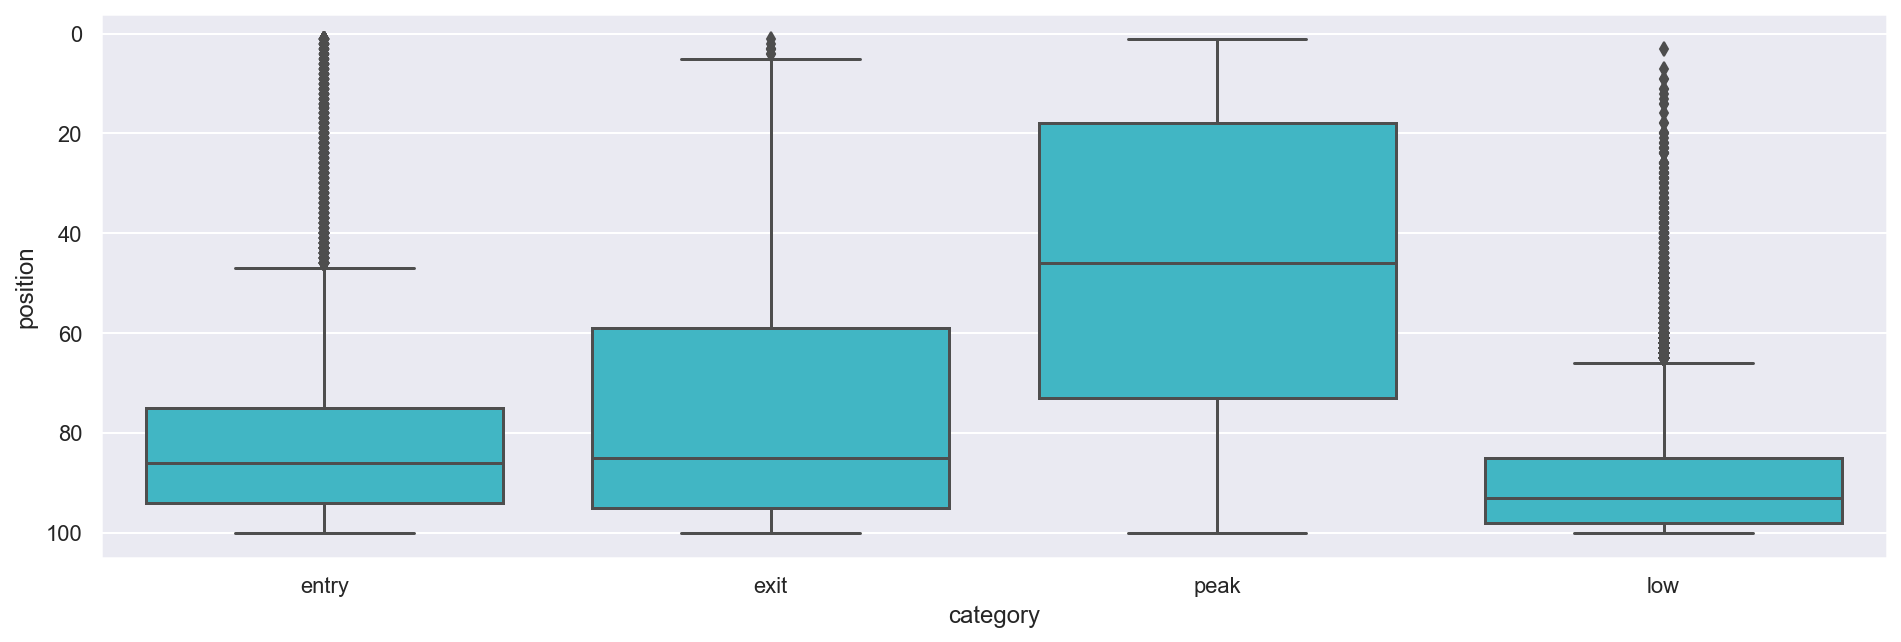

In [75]:
hot100_pos = hot100_uniq.loc[:,['entry','exit','peak','low']]
hot100_pos_melt = pd.melt(hot100_pos)
hot100_pos_melt.columns = ['category','position']
_ = sns.boxplot(x="category", y="position", data=hot100_pos_melt,color=GrayB[0],saturation=1)
_ = plt.gca().invert_yaxis()
                                                  

As seen at the beginning of the Exploratory Data Analysis (EDA). Generally songs enter and exit the Hot 100 in the lower positions. As expected it is hard to stay higher up on the Hot 100 and less than 50% of songs make it into the coveted Top 40.

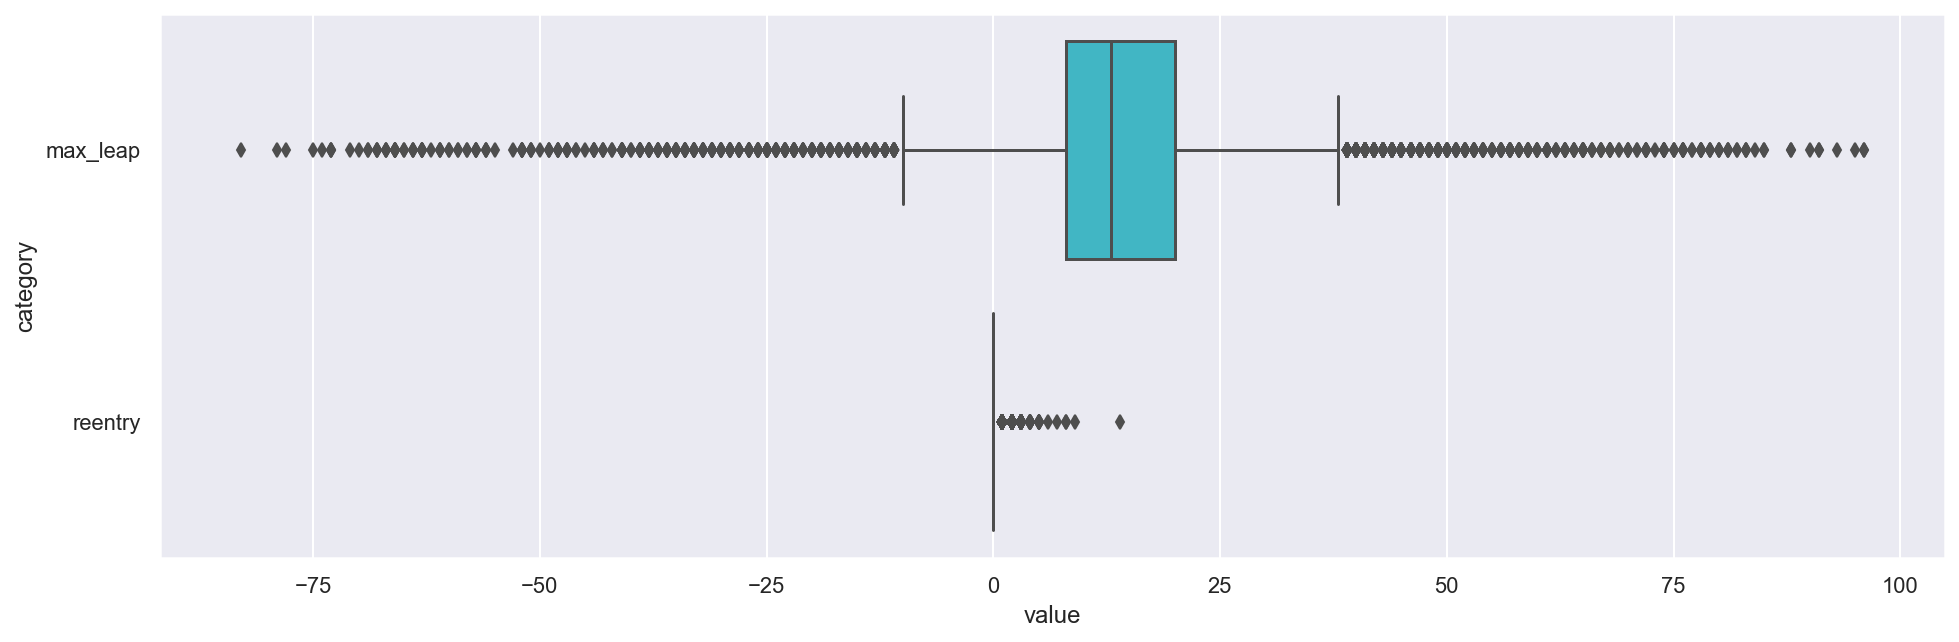

In [76]:
hot100_meta = hot100_uniq.loc[:,['max_leap','reentry']]
hot100_meta_melt = hot100_meta.melt()
hot100_meta_melt.columns = ['category','value']
_ = sns.boxplot(y='category',x='value',data=hot100_meta_melt,color=GrayB[0],saturation=1)

We can see that consistently falling in position is rare on the Hot 100 (i.e. only few songs have negative max_leaps). There are a total of 6 songs that were able to leap more than 90 positions from one week to another.

In [254]:
biggest_leaps = hot100_uniq.loc[hot100_uniq['max_leap']>32,main_cols_hot100_uniq].sort_values(by='max_leap',ascending=False)
biggest_leaps.head(6)

entry_year  \
artist                             title                                        
Dixie Chicks                       Not Ready To Make Nice                2006   
Kelly Clarkson                     My Life Would Suck Without You        2009   
Britney Spears                     Womanizer                             2008   
Lady Gaga                          Million Reasons                       2016   
LL Cool J Featuring Jennifer Lopez Control Myself                        2006   
Beyonce & Shakira                  Beautiful Liar                        2007   

                                                                   exit_year  \
artist                             title                                       
Dixie Chicks                       Not Ready To Make Nice               2007   
Kelly Clarkson                     My Life Would Suck Without You       2009   
Britney Spears                     Womanizer                            2009   
Lady Gaga                          Million Reasons                      2017   
LL Cool J Featuring Jennifer Lopez Control Myself                       2006   
Beyonce & Shakira                  Beautiful Liar                       2007   

                                                                   reentry  \
artist                             title                                     
Dixie Chicks                       Not Ready To Make Nice                2   
Kelly Clarkson                     My Life Would Suck Without You        0   
Britney Spears                     Womanizer                             0   
Lady Gaga                          Million Reasons                       4   
LL Cool J Featuring Jennifer Lopez Control Myself                        1   
Beyonce & Shakira                  Beautiful Liar                        0   

                                                                   streak  \
artist                             title                                    
Dixie Chicks                       Not Ready To Make Nice              16   
Kelly Clarkson                     My Life Would Suck Without You      23   
Britney Spears                     Womanizer                           22   
Lady Gaga                          Million Reasons                      8   
LL Cool J Featuring Jennifer Lopez Control Myself                       7   
Beyonce & Shakira                  Beautiful Liar                      17   

                                                                   ranked  \
artist                             title                                    
Dixie Chicks                       Not Ready To Make Nice              24   
Kelly Clarkson                     My Life Would Suck Without You      24   
Britney Spears                     Womanizer                           23   
Lady Gaga                          Million Reasons                     20   
LL Cool J Featuring Jennifer Lopez Control Myself                      11   
Beyonce & Shakira                  Beautiful Liar                      18   

                                                                   entry  \
artist                             title                                   
Dixie Chicks                       Not Ready To Make Nice             28   
Kelly Clarkson                     My Life Would Suck Without You     97   
Britney Spears                     Womanizer                          96   
Lady Gaga                          Million Reasons                    76   
LL Cool J Featuring Jennifer Lopez Control Myself                     93   
Beyonce & Shakira                  Beautiful Liar                     94   

                                                                   exit  peak  \
artist                             title                                        
Dixie Chicks                       Not Ready To Make Nice            42     4   
Kelly Clarkson                     My Life Would Suck Without You 

To visualize the journey of these songs we'll make an attempt at visualizing it.

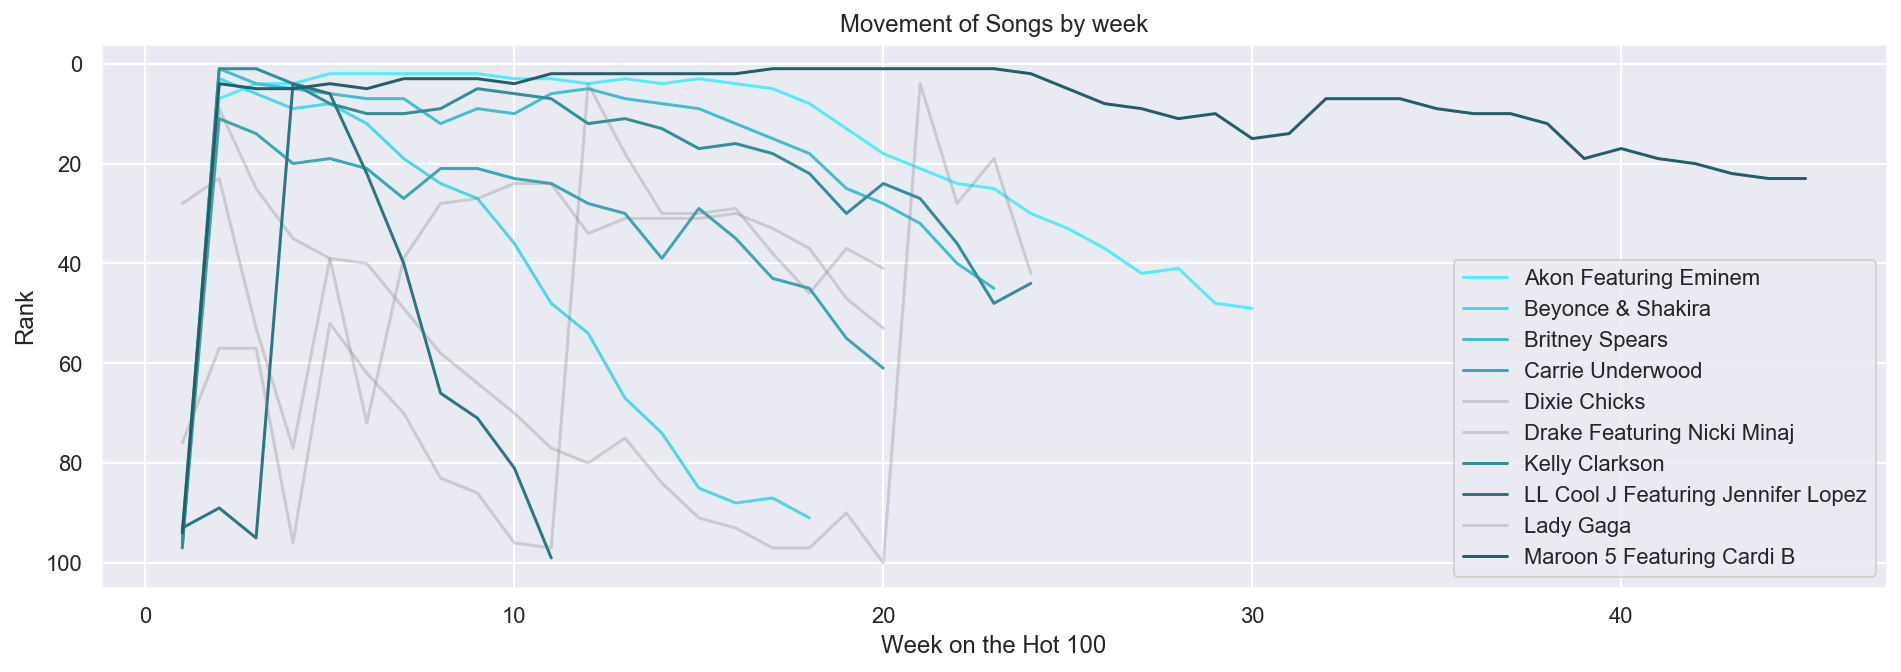

In [255]:
top10_biggest_leaps = biggest_leaps.nlargest(10,columns='max_leap')
week_rank = pd.merge(hot100.set_index(['artist','title']),top10_biggest_leaps,on=['artist','title'],how='inner').loc[:,['week','rank']]
week_rank_sorted = week_rank.sort_values(by=['artist','title','week'])
colorsB = ['#53ECFC','#4CD6E6','#43BECC','#3BA7B3','#328F99','#2A7780','#225F66','#19474D','#113033','#08181A']

colors_iter = iter(colorsB)
for i, row_index in enumerate(week_rank_sorted.index.unique()):
    artist, title = row_index
    if artist in ['Dixie Chicks','Lady Gaga','Drake Featuring Nicki Minaj']:
        color = 'gray'
        alpha = 0.3
    else:
        color = next(colors_iter)
        alpha = 1
    plt.plot(week_rank_sorted.loc[(artist,title),'week'],week_rank_sorted.loc[(artist,title),'rank'],label=artist,c=color,alpha=alpha)
_ = plt.gca().invert_yaxis()
_ = plt.legend()

_ = plt.title('Movement of Songs by week')
_ = plt.xlabel('Week on the Hot 100')
_ = plt.ylabel('Rank')

4 out of the songs rise show their max leap to their peak position within the first 4 weeks of their first appearance on the Hot 100. After the initial high is reached there tends to be more or less a steady decline in position. Let's explore this thought further by looking at the time to max leap and average distance to peak position.

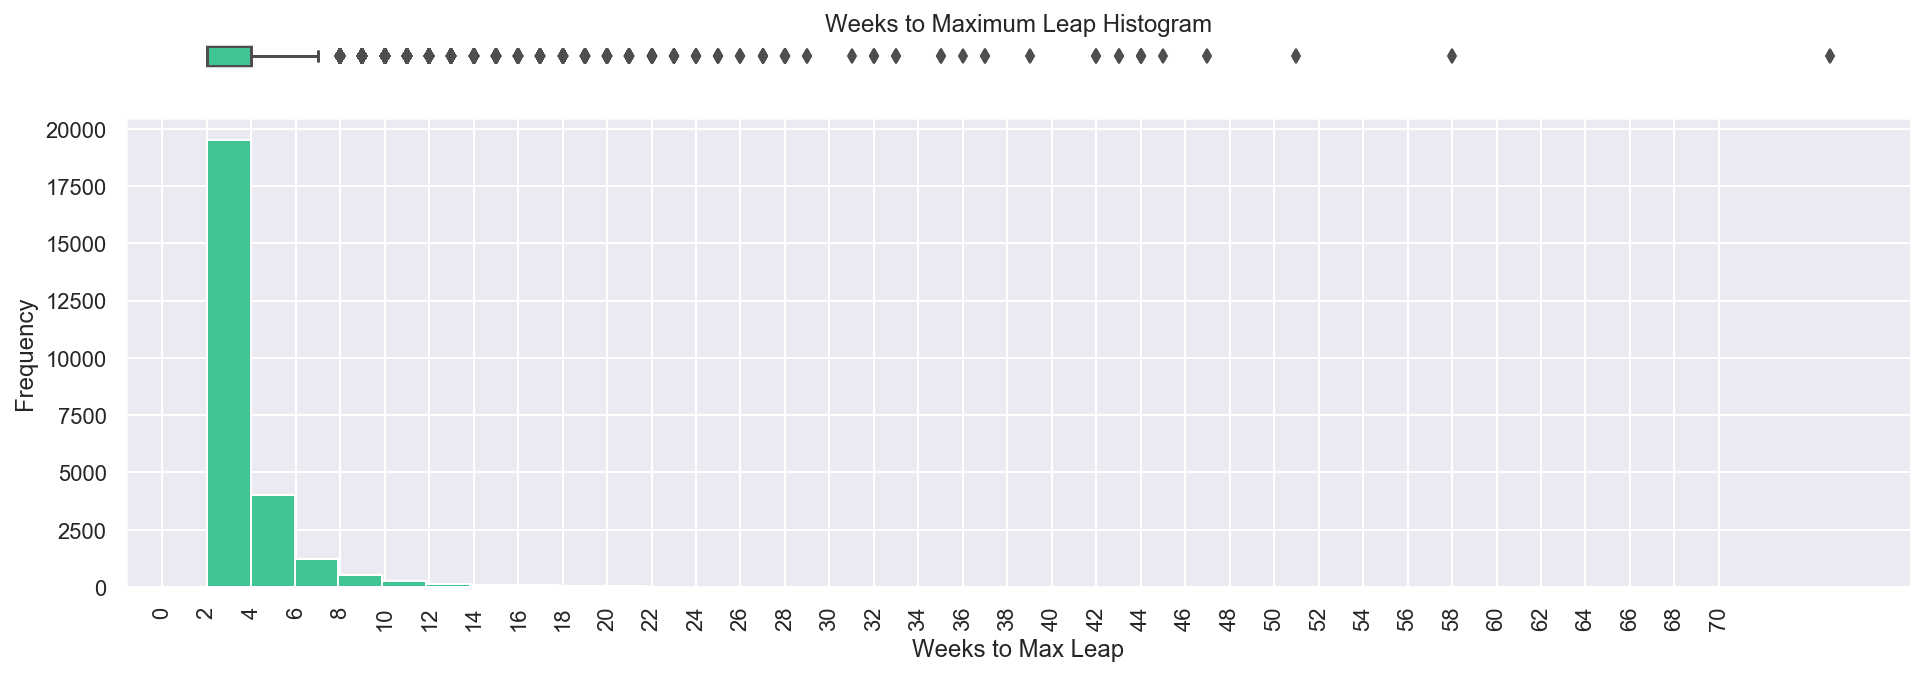

In [256]:
x = hot100_uniq['max_leap_week'].dropna()

ax_box, ax_hist = create_hist(x,xticks=(0,70,2),bins=37,figsize=(16,5))
_ = ax_box.set_title('Weeks to Maximum Leap Histogram')
_ = ax_hist.set_xlabel('Weeks to Max Leap')
_ = plt.xticks(rotation=90)

We can see that the highest jumps occur most often in the second to fourth week of songs making their debut on the Hot 100. Let's now examine whether this maximum leap is close to the final peak position.

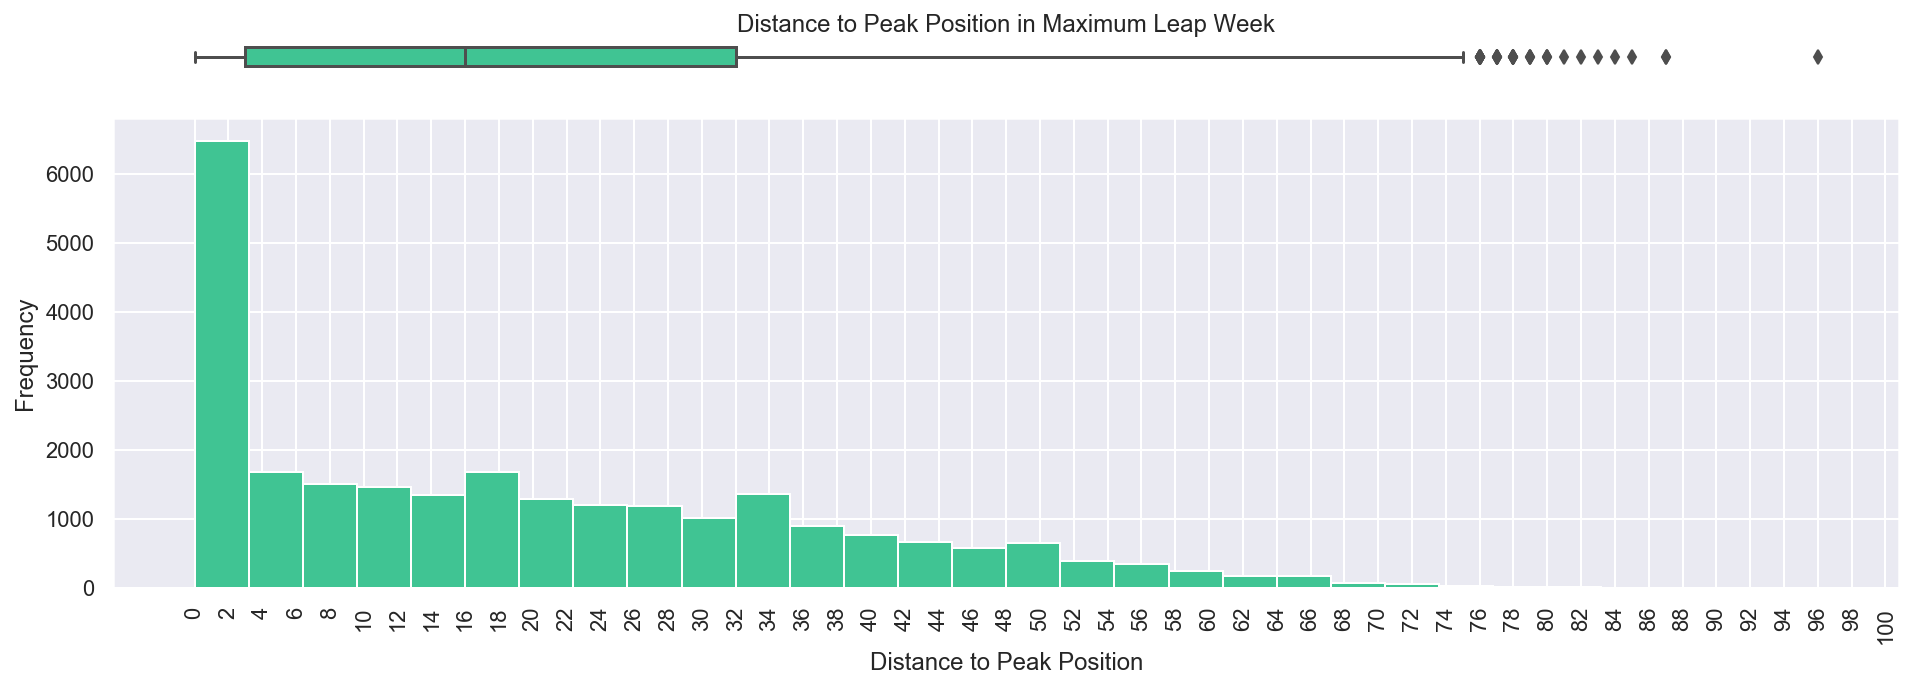

Number of titles that reached their peak position in the week of their maximum leap: 4375 (i.e. 15.58%)

          dist_peak          peak
count  25273.000000  25273.000000
mean      19.549559     43.111898
std       17.725495     29.457823
min        0.000000      1.000000
25%        3.000000     16.000000
50%       16.000000     41.000000
75%       32.000000     68.000000
max       96.000000    100.000000


In [257]:
# Peak position minus position after maximum leap
hot100_week_rank = hot100.loc[:,['artist','title','week','rank']]
hot100_uniq_leap = pd.merge(hot100_uniq,hot100_week_rank,left_on=['artist','title','max_leap_week'],right_on=['artist','title','week'],how='left').set_index(['artist','title']).sort_index()
hot100_uniq_leap.rename(columns={'week_x':'week','rank':'max_leap_rank'},inplace=True)
hot100_uniq_leap.drop('week_y',axis=1,inplace=True)
hot100_uniq_leap['dist_peak'] = hot100_uniq_leap['max_leap_rank'] - hot100_uniq_leap['peak']

outlier_boundary = get_outlier_boundary(hot100_uniq_leap['max_leap'])
x = hot100_uniq_leap.loc[hot100_uniq_leap['max_leap'] >= 0,['dist_peak','peak']].dropna(subset=['dist_peak'])

ax_box, ax_hist = create_hist(x.dist_peak,xticks=(0,100,2),figsize=(16,5),bins=30)
ax_box.set_title('Distance to Peak Position in Maximum Leap Week')
ax_hist.set_xlabel('Distance to Peak Position')
_ = plt.xticks(rotation=90)
plt.show()

max_leap_peaked = hot100_uniq_leap.loc[hot100_uniq_leap['dist_peak'] == 0,'dist_peak'].count()
print("Number of titles that reached their peak position in the week of their maximum leap: {} (i.e. {}%)".format(max_leap_peaked,round(max_leap_peaked/len(hot100_uniq_leap)*100,2)))
print()
print(x.describe())

4375 (i.e. 15.58%) immediately reach their peak position after their largest leap. The top 25% fall within 3 positions of their peak and the top 50% fall within 16 positions.

We can see that there is quite a large standard deviation of +-17.73 ranks from the mean of 19.54 ranks. While a large chunk of songs might be reaching the peak position after their max leap.

### Reentries - The Evergreens Section

There's very few reentries. Most songs that leave the Hot 100 leave for good and only about 4% of the ones that do make a reappearance do so more than twice. In fact, only 6 songs have made a reappearance on the Hot 100 more than 5 times, and they are all seasonal Christmas Evergreens (with one exception 'Unchained Melody' by 'The Righteous Brothers' has made a comeback 14 times over a period of 26 years).

In [258]:
frequent_reentries = hot100_uniq.loc[hot100_uniq.reentry > 5,main_cols_hot100_uniq].sort_values(by='reentry',ascending=False)
frequent_reentries

entry_year  \
artist                 title                                                     
The Righteous Brothers Unchained Melody                                   1965   
Brenda Lee             Rockin' Around The Christmas Tree                  1960   
Bobby Helms            Jingle Bell Rock                                   1958   
Mariah Carey           All I Want For Christmas Is You                    2000   
Nat King Cole          The Christmas Song (Merry Christmas To You)        1960   
Bing Crosby            White Christmas                                    1958   

                                                                    exit_year  \
artist                 title                                                    
The Righteous Brothers Unchained Melody                                  1991   
Brenda Lee             Rockin' Around The Christmas Tree                 2019   
Bobby Helms            Jingle Bell Rock                                  2019   
Mariah Carey           All I Want For Christmas Is You                   2019   
Nat King Cole          The Christmas Song (Merry Christmas To You)       2019   
Bing Crosby            White Christmas                                   2019   

                                                                    reentry  \
artist                 title                                                  
The Righteous Brothers Unchained Melody                                  14   
Brenda Lee             Rockin' Around The Christmas Tree                  9   
Bobby Helms            Jingle Bell Rock                                   8   
Mariah Carey           All I Want For Christmas Is You                    8   
Nat King Cole          The Christmas Song (Merry Christmas To You)        7   
Bing Crosby            White Christmas                                    6   

                                                                    streak  \
artist                 title                                                 
The Righteous Brothers Unchained Melody                                 12   
Brenda Lee             Rockin' Around The Christmas Tree                 4   
Bobby Helms            Jingle Bell Rock                                  4   
Mariah Carey           All I Want For Christmas Is You                   5   
Nat King Cole          The Christmas Song (Merry Christmas To You)       4   
Bing Crosby            White Christmas                                   2   

                                                                    ranked  \
artist                 title                                                 
The Righteous Brothers Unchained Melody                                 57   
Brenda Lee             Rockin' Around The Christmas Tree                26   
Bobby Helms            Jingle Bell Rock                                 25   
Mariah Carey           All I Want For Christmas Is You                  29   
Nat King Cole          The Christmas Song (Merry Christmas To You)      16   
Bing Crosby            White Christmas                                  15   

                                                                    entry  \
artist                 title                                                
The Righteous Brothers Unchained Melody                                72   
Brenda Lee             Rockin' Around The Christmas Tree               64   
Bobby Helms            Jingle Bell Rock                                57   
Mariah Carey           All I Want For Christmas Is You                 83   
Nat King Cole          The Christmas Song (Merry Christmas To You)    100   
Bing Crosby            White Christmas                                 86   

                                                                    exit  \
artist                 title                                               
The Righteous Brothers Unchained Melody                               89   
Brenda Lee             Rockin' Aro

### In conclusion

We've learned that the 1991 introduction of Nilsen Soundscan data likely contributed to a different distribution in the Hot 100. It likely contributed to so-called 'Super Songs' that are able to stay on the Hot 100 for much longer than songs previously. We've also seen that the distribution after 1991 highly skewed the distribution toward one week songs (those that only stay on the Hot 100 for a single week) while creating a uniform distribution between 1-18 week streaks. This should be considered in terms of weighing certain songs into categories as their might be different criteria for songs before 1991 and after 1991, also we should keep an eye out for possibly introducing a different type of music after 1991 due to the more granular data.

To finish this initial analysis let's check what was on the Hot 100 on your birthday.

In [260]:
import ipywidgets as widgets

yr = widgets.IntSlider(value=1989,min=1958,max=2019,step=1,description='Year:')
m = widgets.IntSlider(value=10,min=1,max=12,step=1,description='Month:')
d = widgets.IntSlider(value=29,min=1,max=31,step=1,description='Day:')
top = widgets.IntSlider(value=1,min=1,max=100,step=1,description='Top')

submit = widgets.Button(description="Show Hot 100")

def fetch_list(yr,m,d,top=1):
    birthday_hit = hot100.loc[hot100['rank'] <= top,:]
    return birthday_hit.loc[(birthday_hit['year'] == yr) & (birthday_hit['month'] == m) & (birthday_hit['day'] >= d) & (birthday_hit['day'] < (d + 7)),main_cols_hot100]

def get_birthday_top(yr,m,d,top):
    b_list = fetch_list(yr,m,d,top)
    if len(b_list) < 1:
        d = 1
        if m < 12:
            m += 1
        else:
            m = 1
            yr += 1
        b_list = fetch_list(yr,m,d,top)
    return b_list.set_index(['artist','title'])

# Create Output Variable and Context Manager (necessary to clear old outputs)
out = widgets.Output(layout={'border': '1px solid black'})
def handle_submit(sender):
    out.clear_output()
    with out:
        display(get_birthday_top(yr.value,m.value,d.value,top.value))
        
submit.on_click(handle_submit)

print('Check the Hot 100 on your Birthday')
# Display Birthday sliders
display(yr)
display(m)
display(d)
display(top)
# Display Submit Button and Output
display(submit)
display(out)

Check the Hot 100 on your Birthday


IntSlider(value=1989, description='Year:', max=2019, min=1958)

IntSlider(value=10, description='Month:', max=12, min=1)

IntSlider(value=29, description='Day:', max=31, min=1)

IntSlider(value=1, description='Top', min=1)

Button(description='Show Hot 100', style=ButtonStyle())

Output(layout=Layout(border='1px solid black'))

# Make up of Hits

To dive deeper into the actual make up of a song and see if we can build a model that can reliably identify songs on its content, we'll have a look at the audio features of a hit by looking at its audio signature. Let's start with a few descriptive metrics!

In [261]:
# Set new color palette
GrayP = ['#b440c4',"gray","black"]
sns.set_palette(GrayP)

colorsP = ['#D28DDC','#CA7AD6','#C366D0','#BB53CA','#B340C3','#A337B2','#A437B3','#92319F','#802B8C','#6E2578']
colorsP = colorsP[::-1]

In [262]:
import math

features = np.array(['danceability', 'energy', 'key', 'mode','loudness', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms','time_signature'])
analysis_train = train.loc[:,main_cols_analysis]
analysis_train['hit'].replace({True: 1, False: 0},inplace=True)

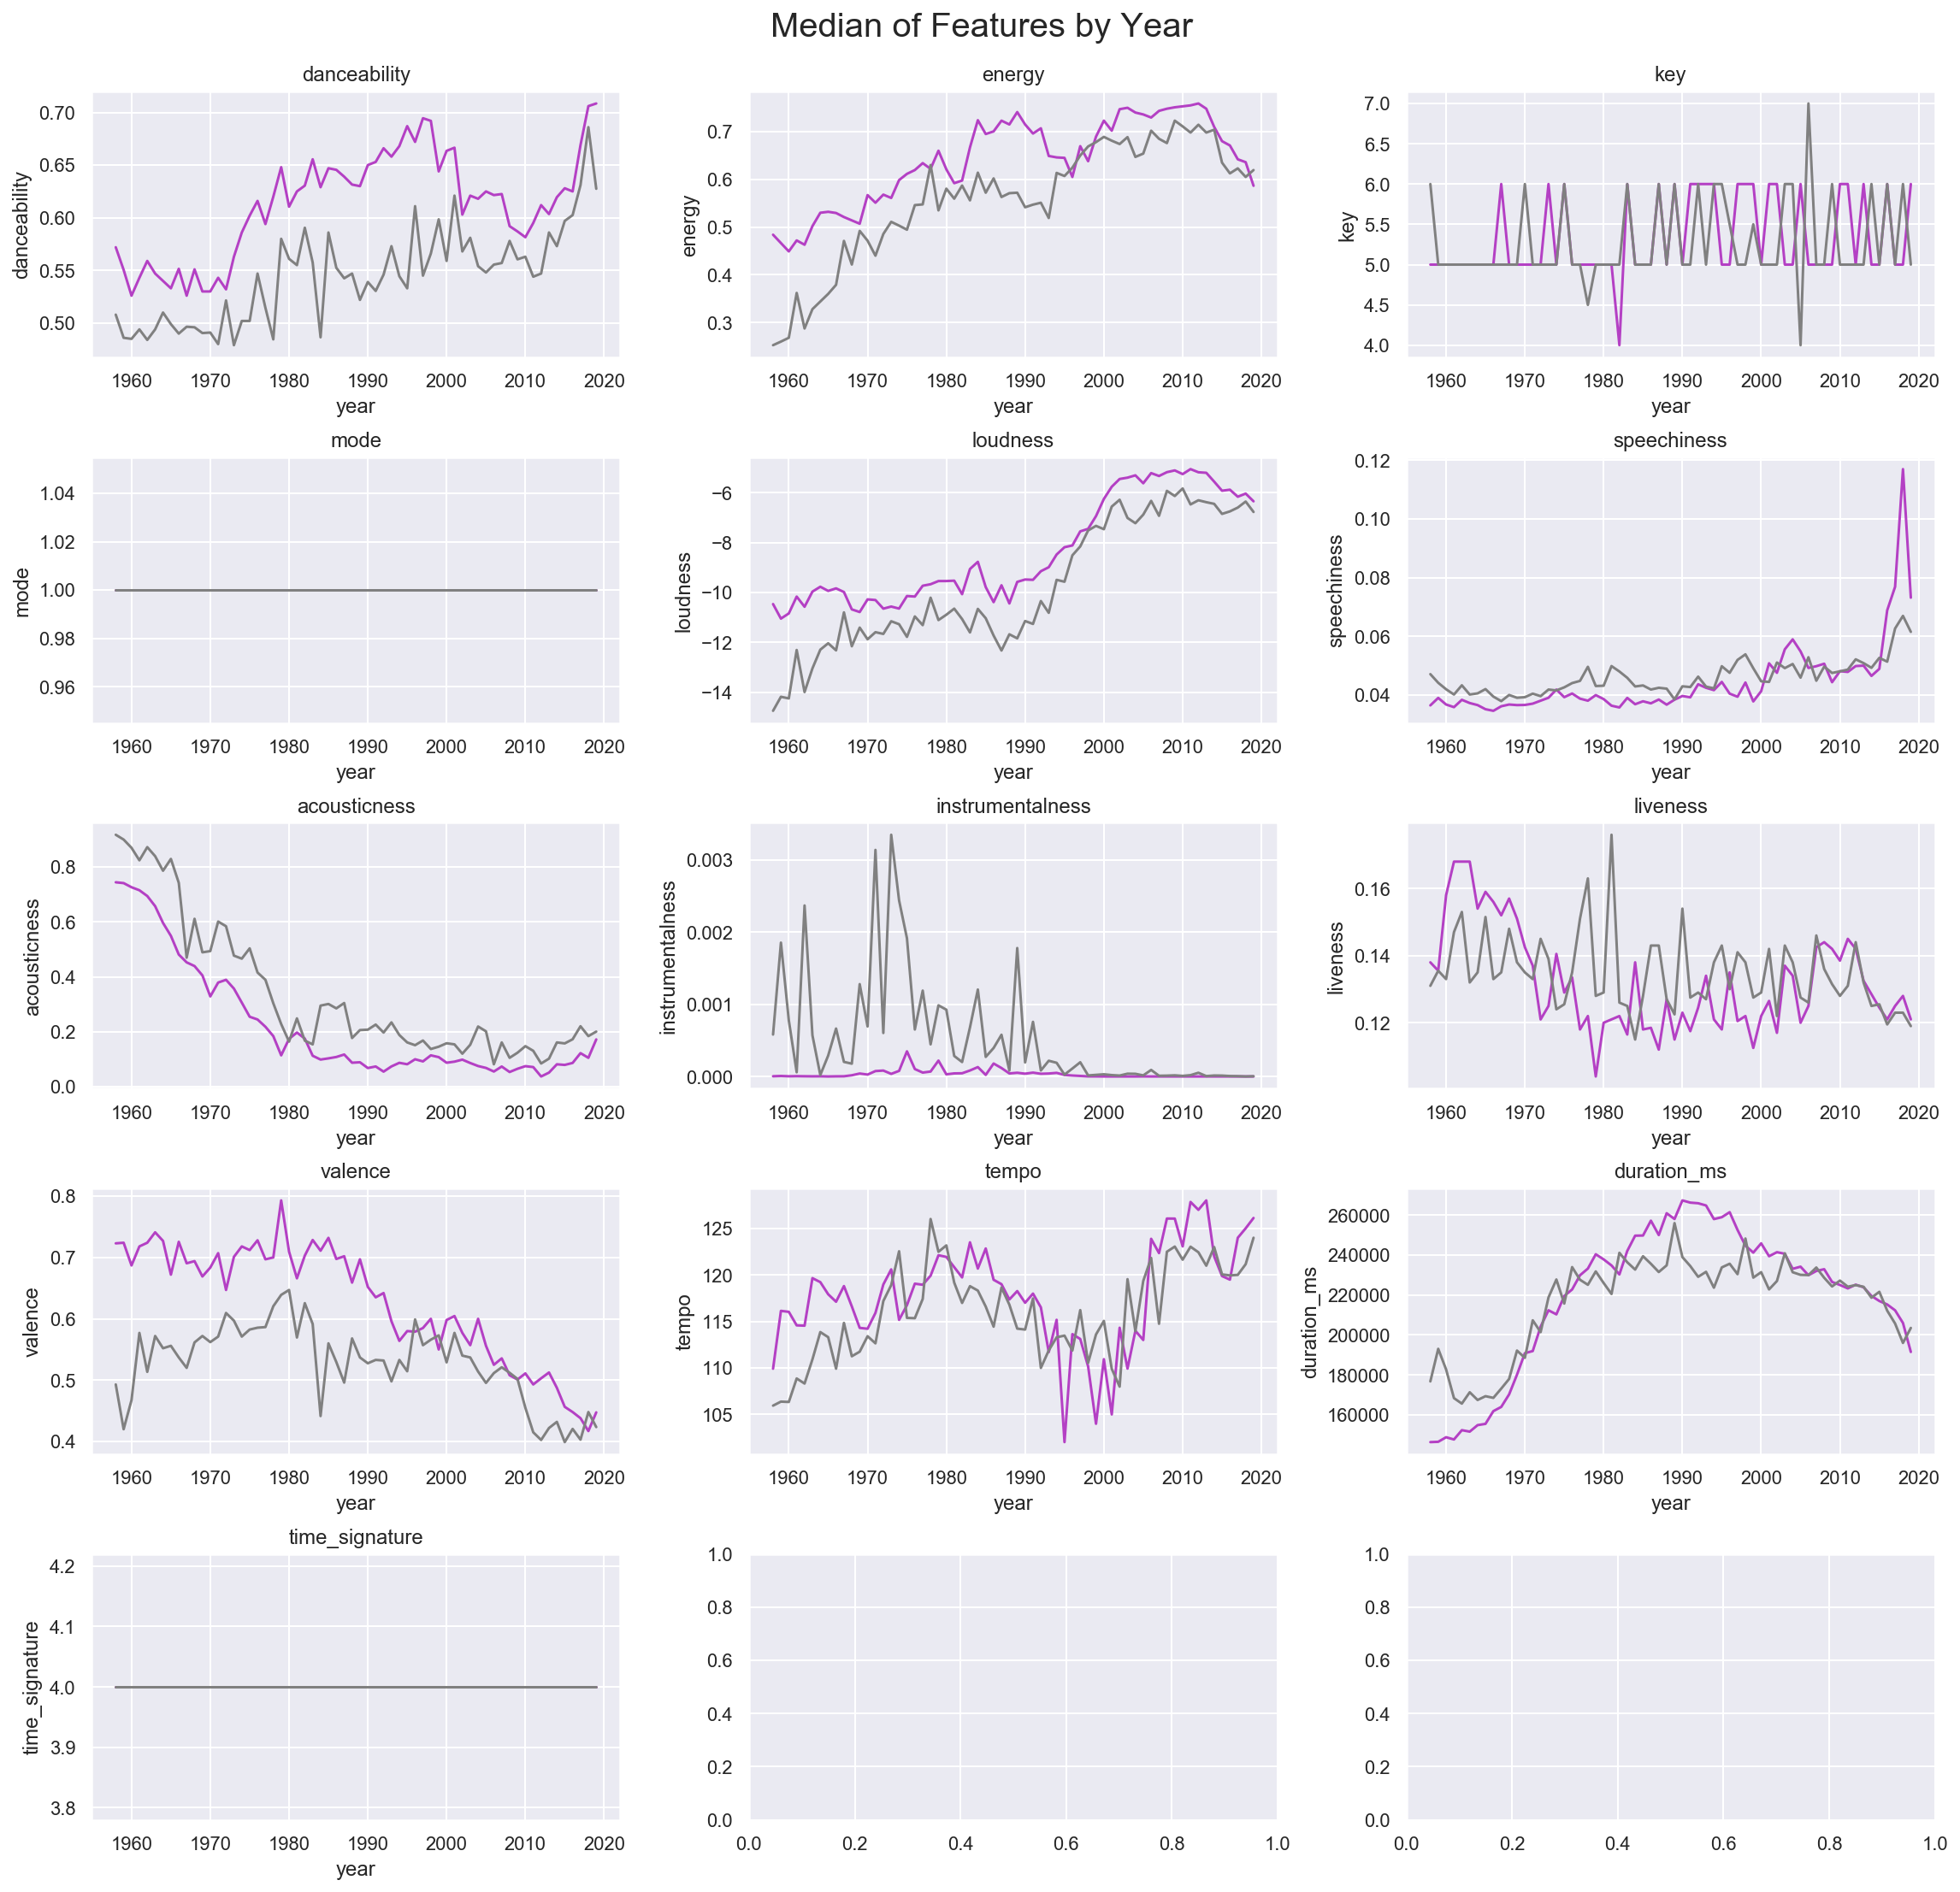

There are 34671 rows and 20 columns


In [263]:
def plot_feature_by(hits,nhits,feature,ax,by='year'):
    # Group plus dataset and calc median
    hits_by = hits.groupby(by)
    hits_by_median = hits_by.median()

    # Group minus dataset and calc median
    nhits_by = nhits.groupby(by)
    nhits_by_median = nhits_by.median()

    _ = ax.plot(hits_by_median.index,hits_by_median[feature])
    _ = ax.plot(nhits_by_median.index,nhits_by_median[feature])
    _ = ax.set_title(feature)
    _ = ax.set_xlabel('year')
    _ = ax.set_ylabel(feature)
    
def plot_feature(hits,nhits,feature,ax):
    _ = ax.scatter(hits.year,hits[feature],s=1)
    _ = ax.scatter(nhits.year,nhits[feature],s=1)
    _ = ax.set_title(feature)
    _ = ax.set_xlabel('year')
    _ = ax.set_ylabel(feature)
    

def by_year_median(hits,nhits,features,scatter=False):
    total = len(features)
    
    rows = math.ceil(total/3)
    fig, axes = plt.subplots(rows,3,figsize=(16,rows * 3))
    
    _ = fig.suptitle('Median of Features by Year',fontsize=20,y=1.02)
    
    feature_ct = 0
    for col in axes:
        if len(axes) > 1:
            for ax in col:
                if scatter:
                    try:
                        plot_feature(hits,nhits,features[feature_ct],ax)
                    except:
                        pass
                else:
                    try:
                        plot_feature_by(hits,nhits,features[feature_ct],ax,by='year')
                    except:
                        pass
                feature_ct += 1
        else:
            if scatter:
                plot_feature(hits,nhits,features[feature_ct],ax)
            else:  
                plot_feature_by(hits,nhits,features[feature_ct],ax,by='year')
            feature_ct += 1
    _ = plt.tight_layout()
    return fig, axes

fig, axes = by_year_median(hits,nhits,features)
plt.show()

print("There are {} rows and {} columns".format(analysis_train.shape[0],analysis_train.shape[1]))

There are a few features that show some distinct trends when compared to non-hits. Median Danceability, Energy, Loudness and Valence of Hot 100 / hits are pretty consistently above their non-hits counterpart. While Acousticness has consistently a lower median across time. Instrumentalness and Speechiness show some interesting patterns that we should have a closer look at. Let's have a closer look at danceability first.

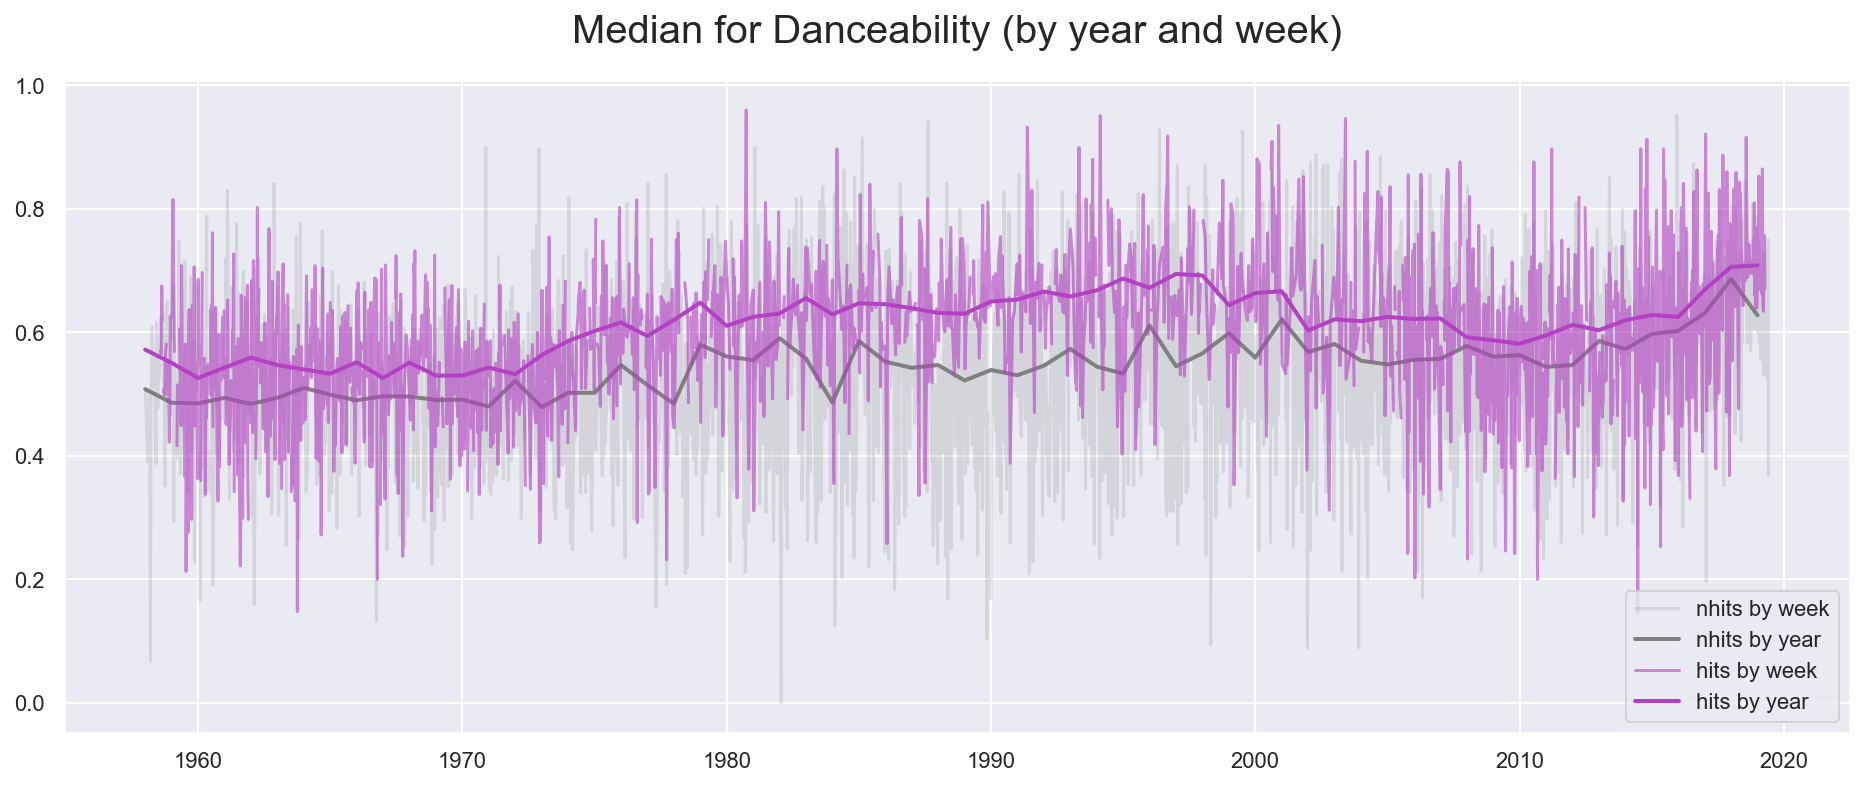

In [264]:
from datetime import datetime
from pandas.plotting import register_matplotlib_converters

# Explicit Registering of TimeSeries Index before Plotting
register_matplotlib_converters()

def plot_detailed_feature(hits,nhits,feature,new_plot=True,method='median'):
    if new_plot:
        fig, ax = plt.subplots(1,1,figsize=(16,6))
    if method == 'mean':
        by_day = nhits.groupby(['date']).mean()
        by_year = nhits.groupby(['year']).mean()
    else:
        by_day = nhits.groupby(['date']).median()
        by_year = nhits.groupby(['year']).median()
    nhits_feature_by_day = by_day[feature]
    by_year['date'] = [datetime.strptime(str(year)+"-01-01","%Y-%m-%d") for year in by_year.index]
    nhits_feature_by_year = by_year.reset_index(drop=True).set_index('date')[feature]

    if method == 'mean':
        by_day = hits.groupby(['date']).mean()
        by_year = hits.groupby(['year']).mean()
    else:
        by_day = hits.groupby(['date']).median()
        by_year = hits.groupby(['year']).median()
        
    
    hits_feature_by_day = by_day[feature]
    by_year['date'] = [datetime.strptime(str(year)+"-01-01","%Y-%m-%d") for year in by_year.index]
    hits_feature_by_year = by_year.reset_index(drop=True).set_index('date')[feature]
    
    _ = plt.title('{} for {} (by year and week)'.format(method.title(), feature[0].upper() + feature[1:]),fontsize=20,y=1.04)

    _ = plt.plot(nhits_feature_by_day, alpha=0.2, label='nhits by week', color=GrayP[1])
    _ = plt.plot(nhits_feature_by_year, alpha=1, label='nhits by year', color=GrayP[1], linewidth=2)
    _ = plt.plot(hits_feature_by_day, alpha=0.6, label='hits by week', color=GrayP[0])
    _ = plt.plot(hits_feature_by_year, alpha=1, label='hits by year', color=GrayP[0], linewidth=2)

    _ = plt.legend()
    
    return

_ = plot_detailed_feature(hits,nhits,'danceability')

_"Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity."_ [Spotify Track Features Description](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

Simply looking at the amplitude of the two by day graphs, it's obvious that there is quite a bit of overlap between hits and non-hits in terms of danceability. Nevertheless, Hits generally seem to be more danceable. We can see an upward trend starting in the mid 1970s with non-hits staying roughly the same (if introducing more variability). From the mid 1980s and late 1990s we can additionally see the amplitude between days visibly shrinking (i.e. less variability) suggesting that less danceable songs had a hard time getting onto the Hot 100 in this period. This is not a big surprise as the 1980s and 1990s are quite literally known for the emergence of dance and dance-pop. 

While the 1980s and 1990s were the age when danceability had the highest chance of thriving in the Hot 100, it should be said that with the introduction of disco music in the 1970s has most likely played role in clearing the way for this trend (i.e. see the uptick starting in the mid 1970s).

Starting in the early 2000s we're starting to see a minor slump in danceability, which lasted until the mid 2010s. Now in the most recent years (likely pushed with the rise of Electronic Dance Music (EDM)), we're seeing the highest level of danceability in the Hot 100 hits and quite low variability in 2018 and 2019. It's also notable that non-hits have been catching up in danceability and have closed in on the median danceability of the Hot 100 (disregarding the drop in 2019).

For our model, it can be seen that especially during the mid-1970s and mid-2000s there is a visible difference in danceability and that median hits have been consistently more danceable than median non-hits (_see inference analysis below).

Lastly, let's look at a few of the most danceable songs throughout the history of the Hot 100.

In [266]:
most_danceable = combined.loc[combined.loc[(combined['hit'] == True),:].danceability.nlargest(10).index,['date','danceability','hit','peak']]
most_danceable

date  \
artist                  title                                         
Tone-Loc                Funky Cold Medina                1989-06-03   
DJ Suede The Remix God  Cash Me Outside (#CashMeOutside) 2017-03-04   
Glee Cast               Ice Ice Baby                     2010-05-22   
The Jacksons            State of Shock                   1984-09-22   
Vanilla Ice             Ice Ice Baby                     1990-09-08   
Evelyn King             Betcha She Don't Love You        1983-01-22   
Jermaine Jackson        Let Me Tickle Your Fancy         1982-10-30   
2nd II None             Be True To Yourself              1992-01-11   
Cardi B Featuring Migos Drip                             2018-06-02   
Justin Timberlake       SexyBack                         2007-03-03   

                                                          danceability   hit  \
artist                  title                                                  
Tone-Loc                Funky Cold Medina                        0.988  True   
DJ Suede The Remix God  Cash Me Outside (#CashMeOutside)         0.981  True   
Glee Cast               Ice Ice Baby                             0.980  True   
The Jacksons            State of Shock                           0.980  True   
Vanilla Ice             Ice Ice Baby                             0.978  True   
Evelyn King             Betcha She Don't Love You                0.974  True   
Jermaine Jackson        Let Me Tickle Your Fancy                 0.973  True   
2nd II None             Be True To Yourself                      0.971  True   
Cardi B Featuring Migos Drip                                     0.968  True   
Justin Timberlake       SexyBack                                 0.967  True   

                                                          peak  
artist                  title                                   
Tone-Loc                Funky Cold Medina                  3.0  
DJ Suede The Remix God  Cash Me Outside (#CashMeOutside)  72.0  
Glee Cast               Ice Ice Baby                      74.0  
The Jacksons            State of Shock                     3.0  
Vanilla Ice             Ice Ice Baby                       1.0  
Evelyn King             Betcha She Don't Love You         49.0  
Jermaine Jackson        Let Me Tickle Your Fancy          18.0  
2nd II None             Be True To Yourself               78.0  
Cardi B Featuring Migos Drip                              21.0  
Justin Timberlake       SexyBack                           1.0

Judging from the Top 10 most danceable songs we can see the above trend more or less reflected. In the 1980s and early 1990s very danceable songs had the best chances of making it onto the Hot 100. In more recent years, the most danceable songs that made it onto the Hot 100 with one exception (i.e. Justin Timberlake's SexyBack) had lesser success in terms of reaching a top position. That being said we see that the most recent dance hit is from Summer 2018 and just fell short of making it onto the Top 20.

### Inference Analysis of Danceability

In the following we're going to look at the statistical significance of the differences in distribution of Hits vs. Non-Hits.

To better understand whether the distributions are statistically significantly different we'll use a Z-Test.

H0: The Danceability Distribution for Hits and Non-Hits is the same (i.e. the mean diff is 0).
H1: The Danceability Distribution for Hits and Non-Hits is not the same.
alpha = 0.05

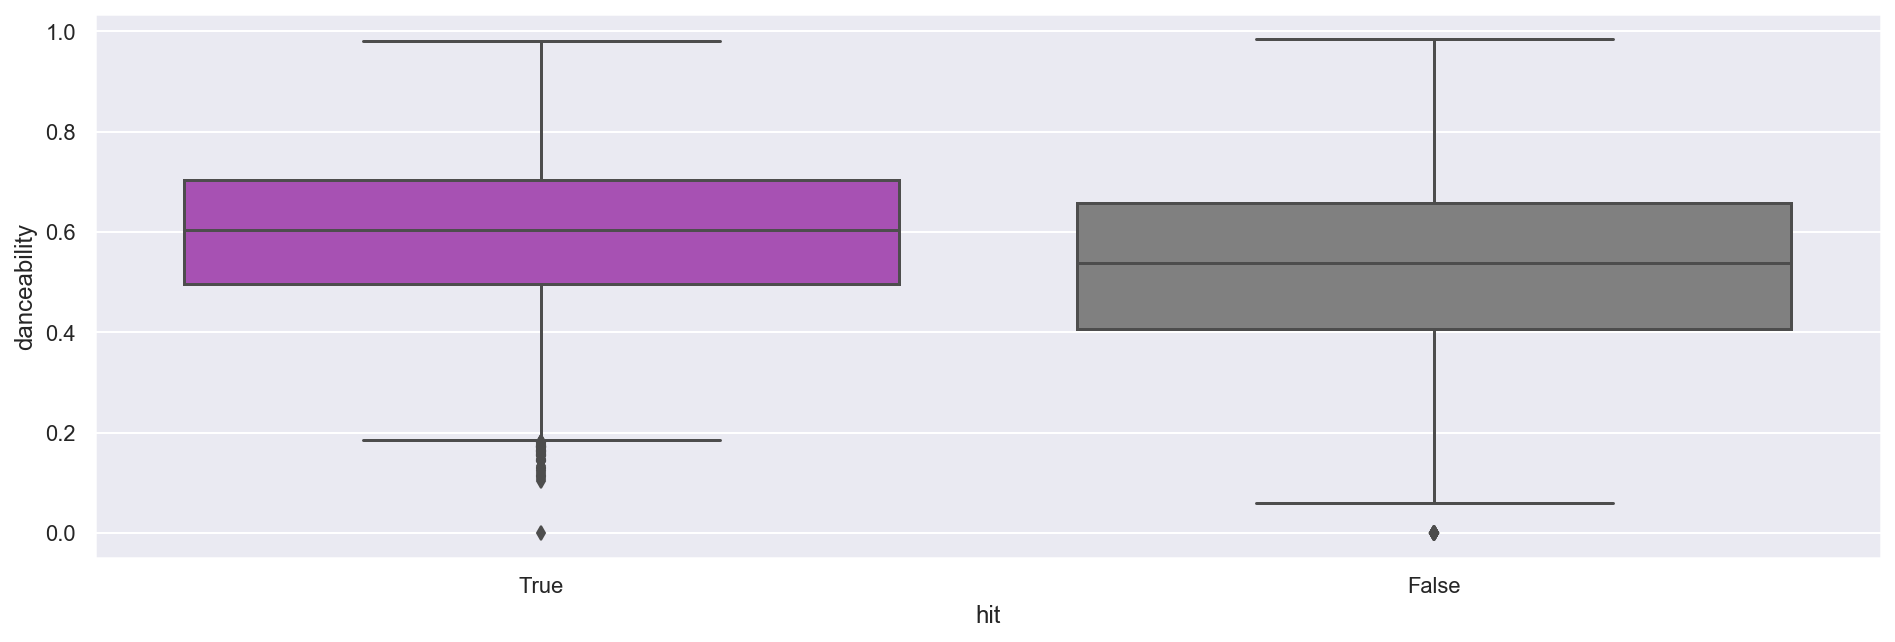

In [268]:
sns.boxplot(x='hit',y='danceability',data=train,order=[True,False])

In [269]:
hits_danceability = hits.danceability.dropna()
nhits_danceability = nhits.danceability.dropna()

hits_nhits_diff = hits_danceability.mean() - nhits_danceability.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.danceability.mean(), nhits.danceability.mean(), hits_nhits_diff,h0_diff))

Hits Mean: 0.5957135504885993
Non-Hits Mean: 0.5295059136044526
Mean Diff: 0.06620763688414666
H0 Diff: 0


We can see some difference between the means of the two distributions but without a statistical significance test we can't be sure that this difference isn't simply due to chance of the sample and that the distributions are in fact the same.

To better understand whether the distributions are statistically significantly different we'll use a Z-Test and Permutation.

    H0: The Danceability Distribution for Hits and Non-Hits is the same (i.e. the mean diff is 0).
    H1: The Danceability Distribution for Hits and Non-Hits is not the same.
    alpha = 0.05

In [270]:
# Seed Random
np.random.seed(500)

def bins_rule_of_thumb(data):
    return int(np.sqrt(len(data)))

# Define Comparison Function Difference of Means
def mean_diff(data1,data2):
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    return mean1 - mean2

# Create Permutation Sample Function
def permutation_sample(data1,data2):
    """
    Creates a Permutation Sample from two data sets and returns two permutated samples 
    with the same length as the original sets.
    """
    data_both = np.concatenate((data1,data2))
    data_perm = np.random.permutation(data_both)
    perm_sample_1 = data_perm[:len(data1)]
    perm_sample_2 = data_perm[len(data1):]
    return (perm_sample_1,perm_sample_2)

# Define function to generate Permutation Replicates
def draw_perm_reps(data1,data2,func,size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1,perm_sample_2 = permutation_sample(data1,data2)
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)
        
    return perm_replicates

def ecdf(data):
    """
    Returns the x,y values for data for plotting as an ecdf.
    """
    # Sort the data along the x-axis
    x = np.sort(data)
    
    # Index the data at equidistant intervals
    y = np.arange(1, len(x) + 1) / len(x)
    
    return x,y

def test_mean_diff(data1,data2,mean_diff_val,h0_diff=0):
    perm_replicates = draw_perm_reps(data1,data2,mean_diff,10000)

    if mean_diff_val > 0:
        p = np.sum(perm_replicates >= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))
    else:
        p = np.sum(perm_replicates <= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))

    CI = np.percentile(perm_replicates,[2.5,97.5])
    print("CI: {}".format(CI))

    ME = CI[1] - np.mean(perm_replicates)
    print("ME: {}".format(ME))

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))

    plt.subplot(1,2,1)

    dist_ax = sns.distplot(perm_replicates,bins=25,color='gray')
    max_dist_y = np.array([h.get_height() for h in dist_ax.patches]).max()
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Density')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.legend(['Mean Difference Distribution \nfor p(hits)=p(nhits)'],loc='upper left')
    _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,max_dist_y*0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})


    ## CI_area = perm_replicates[perm_replicates <= CI[0]]
    ## _ = plt.hist(CI_area)

    plt.subplot(1,2,2)

    x,y = ecdf(perm_replicates)
    y_interp = np.interp(x,x,y)
    _ = plt.plot(x,y_interp,color='gray')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Cumulative Probability')
    _ = plt.legend(['Mean Difference Distribution \nfor p(hits)=p(nhits)'],loc='lower right')
    if mean_diff_val >= 0:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,1),xytext=(mean_diff_val,0.8),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})
    else:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})

p: 0.0
CI: [-0.00384252  0.0037603 ]
ME: 0.003786297754012112


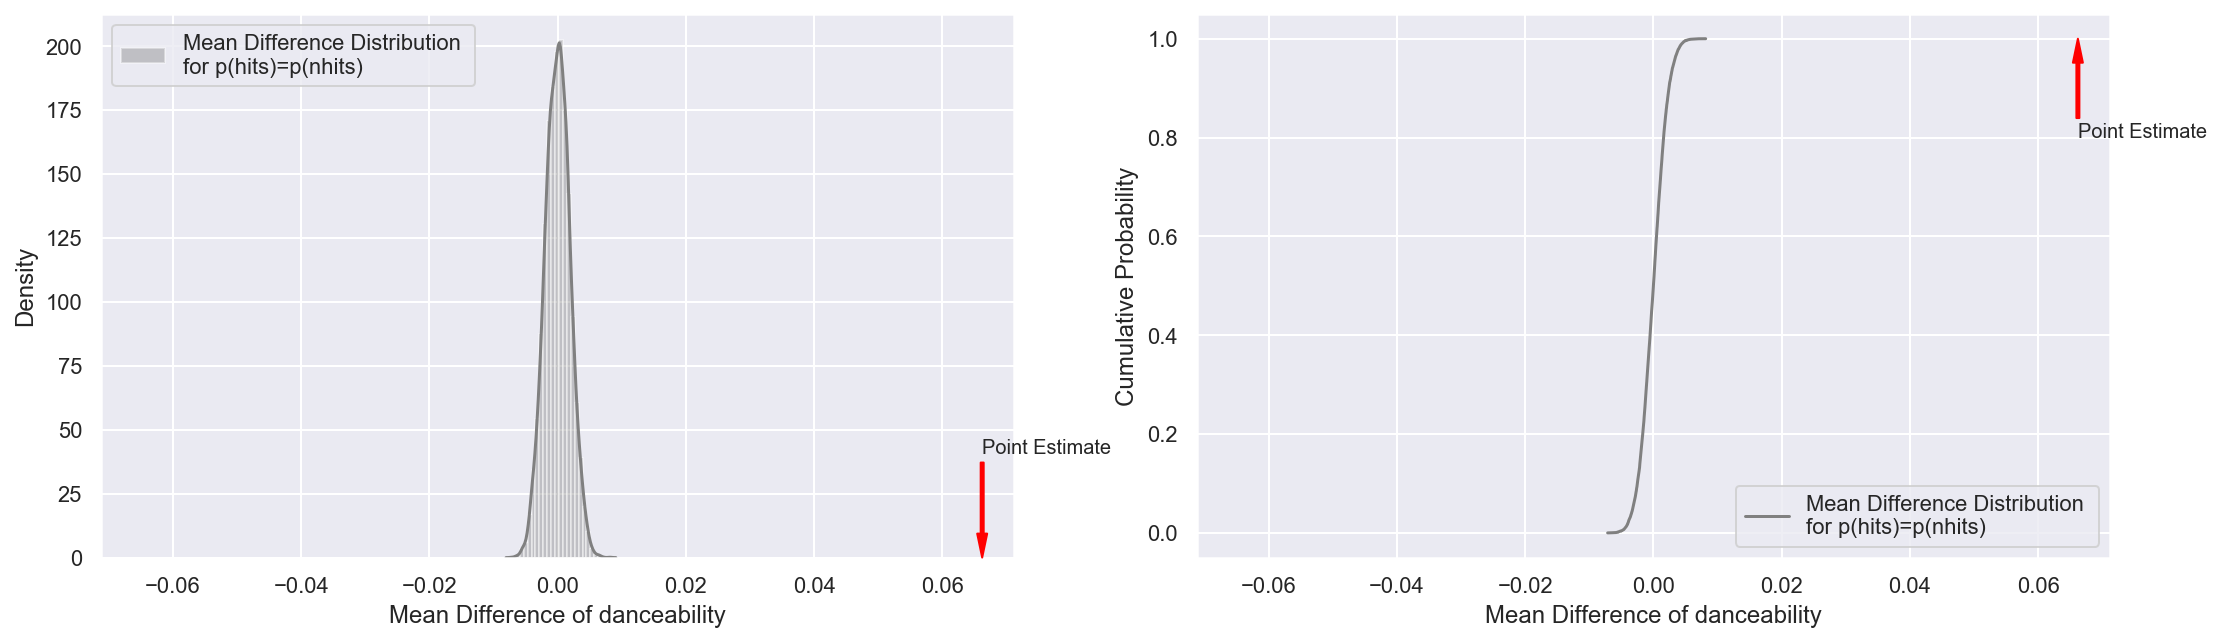

In [271]:
test_mean_diff(hits_danceability,nhits_danceability,hits_nhits_diff)

Looking at the trial above it's clear that the mean difference is statistically significant. This is not surprising, due to the largeness of the sample but the exceptionally low p-value is positive evidence that we might be on the right track here and that there is some predictive information. 

Given the results above, we can reject H0 and have gathered evidence to support H1. The data indicates that hits tend to be more 'danceable'.

Due to the large sample size most differences are likely statistically significant, for interesting cases I've conducted a test below otherwise most of these relationships are tested in _\_Step 3 - Inferential Statistical Tests_ and _\_Step 4 - Building a Model_

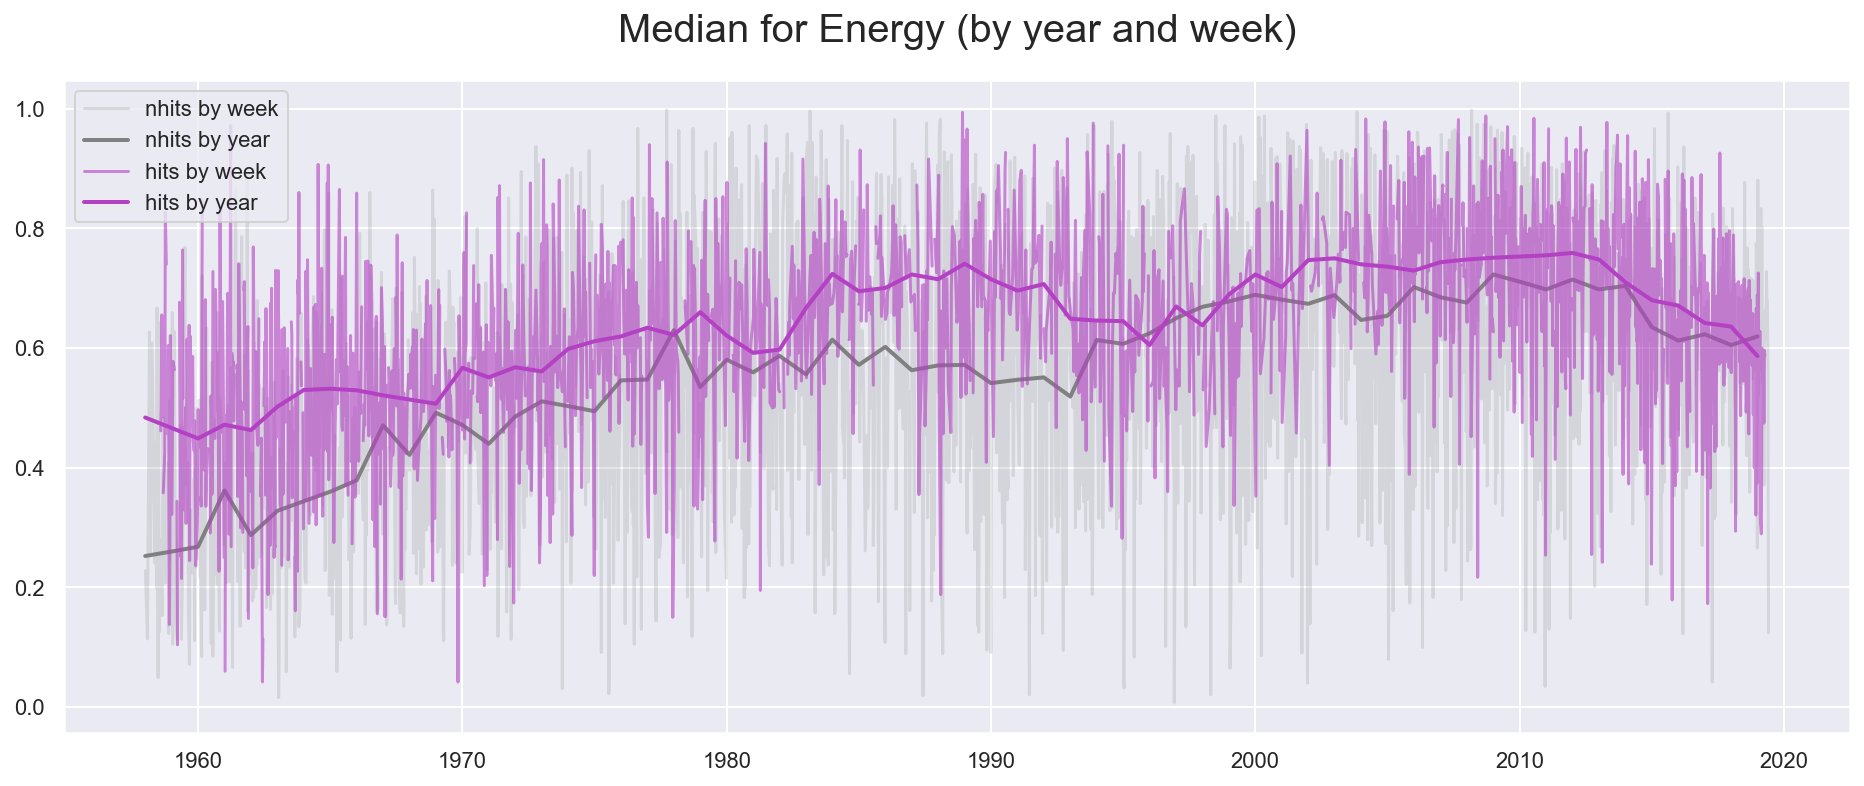

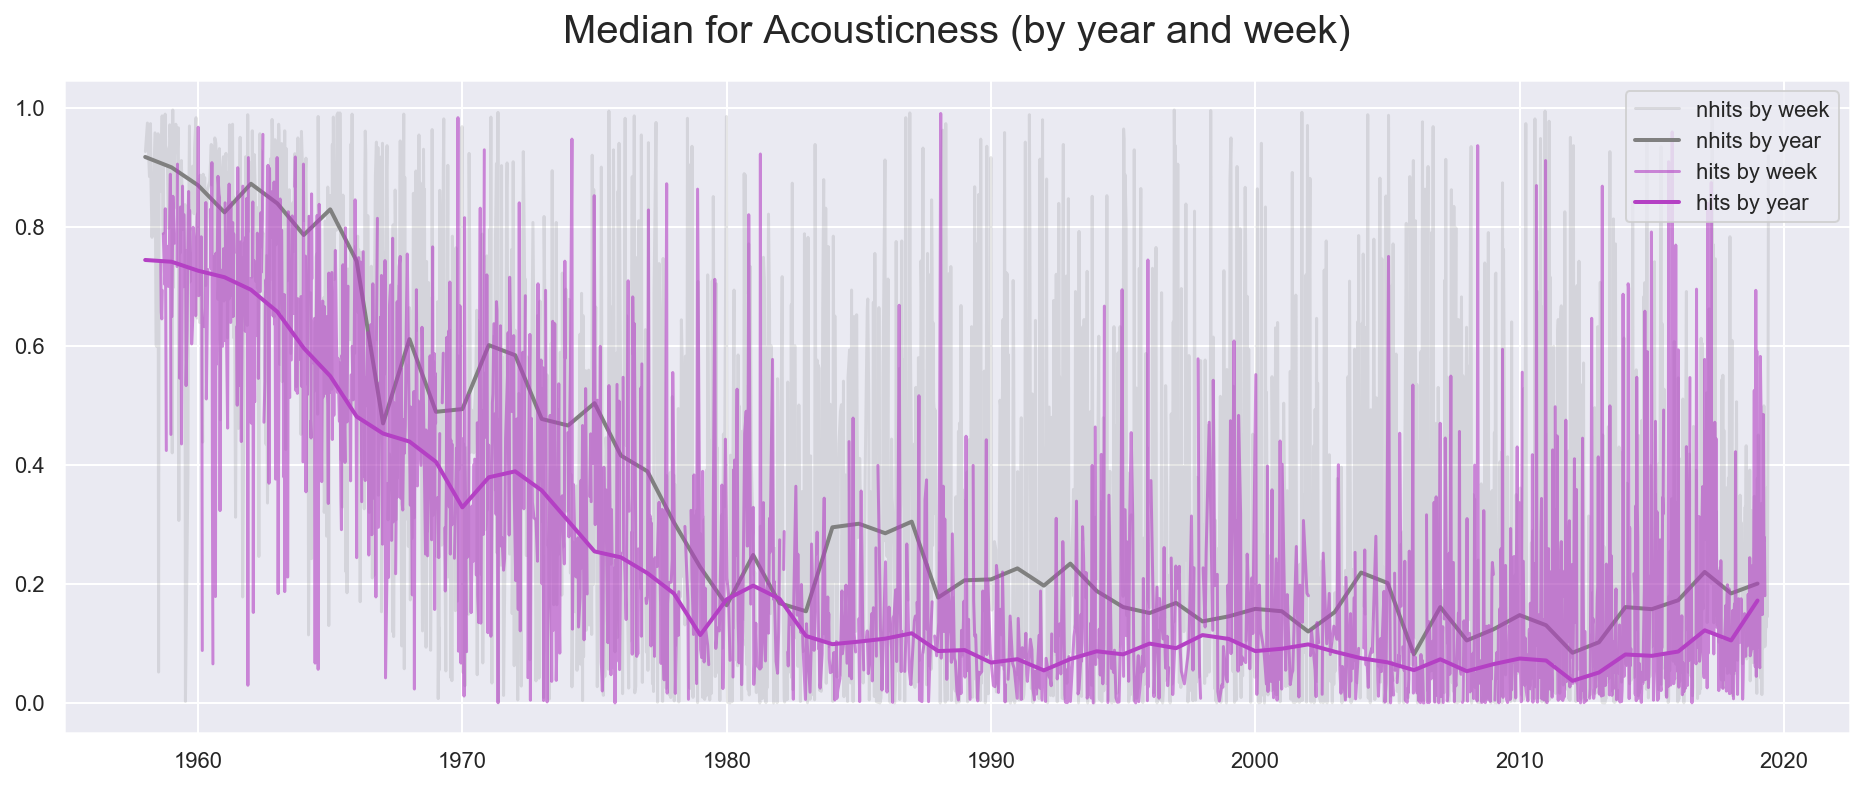

In [39]:
_ = plot_detailed_feature(hits,nhits,'energy')
_ = plot_detailed_feature(hits,nhits,'acousticness')

_"Energy [...] represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy."_  [Spotify Track Features Description](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

Energy as a feature looks like a less clear-cut situation. First of all, there is a lot more overlap in by week medians of hits and non-hits. Furthermore, the median Energy levels by year have started to close in between hits and non-hits in recent years. Nevertheless, starting in the early 1980s we're starting to see a stronger focus (lower variability) on high-energy songs compared to the early 1960s.

Again, just as with danceability we can see variability picking up in the mid- to late-2000s. Energy levels were at their all-time highs from the early 1980s until the 2010s (an exception were the mid- to late-1990s). Starting in the early 2010s, however, we're seeing less energetic songs getting the upper hand. In fact, the Hot 100s median energy levels have dropped below non-hits in 2019 for the third time since its inception.

For our model, we're witnessing again that higher energy levels seem to indicate a higher likelihood of Hit potential than low energy levels. Similarly this has been quite consistently the case starting mid-1970s to the mid-2010s. The general difference will be checked for significance in the _inference analysis_.

To get a feeling for what songs are considered high energy, we're listing the top 10 most energetic songs below.

_"[Acousticness is] a confidence measure from 0.0 to 1.0 of whether the track is acoustic."_  [Spotify Track Features Description](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

As a comparison I've plotted the development of acousticness confidence below the energy plot. We can see that acousticness confidence and variability decrease in the late 1970s and are on historic lows in the 1980s throughout the 1990s and until the mid 2000s (with a few exceptions). 

Energy and Acousticness are not necessarily opposite sides of the same relationship but both of them share a drastic change. Energy on one end has enjoyed a meteoric rise in the 1980s, acousticness has dropped drastically in the 1980s, variability and median in acousticness have recently picked back up while energy has started to drop in recent years. Unfortunately, our analysis of the negative relationship between these two features is limited as Spotify does not release a detailed break-down of their features.

In both cases we seem to be looking at one or several bigger trends as hits and non-hits are moving in the same direction but with hits having fewer variability it looks like these two features could carry a lot of explanatory information especially for the period between 1980s and 2000s. The overlap between hits and non-hits is much larger before or after the period just mentioned.

In [272]:
most_energy = combined.loc[combined.loc[(combined['hit'] == True),:].energy.nlargest(10).index,['date','energy','hit','peak']]
most_energy

date  energy   hit  peak
artist                  title                                                 
Culture Beat            Mr. Vain                1993-12-18   0.997  True  17.0
Five Finger Death Punch Under And Over It       2011-08-20   0.996  True  77.0
Jane's Addiction        Just Because            2003-08-09   0.996  True  72.0
Guns N' Roses           Nightrain               1989-08-26   0.995  True  93.0
Suzi Quatro             I've Never Been In Love 1979-09-22   0.995  True  44.0
The Chemical Brothers   Setting Sun             1997-02-15   0.995  True  80.0
Bananarama              Love, Truth & Honesty   1988-12-03   0.994  True  89.0
Go-Go's                 We Got The Beat         1982-05-15   0.994  True   2.0
Jimmy Ruffin            Hold On To My Love      1980-04-12   0.994  True  10.0
Metallica               Cyanide                 2008-09-20   0.993  True  50.0

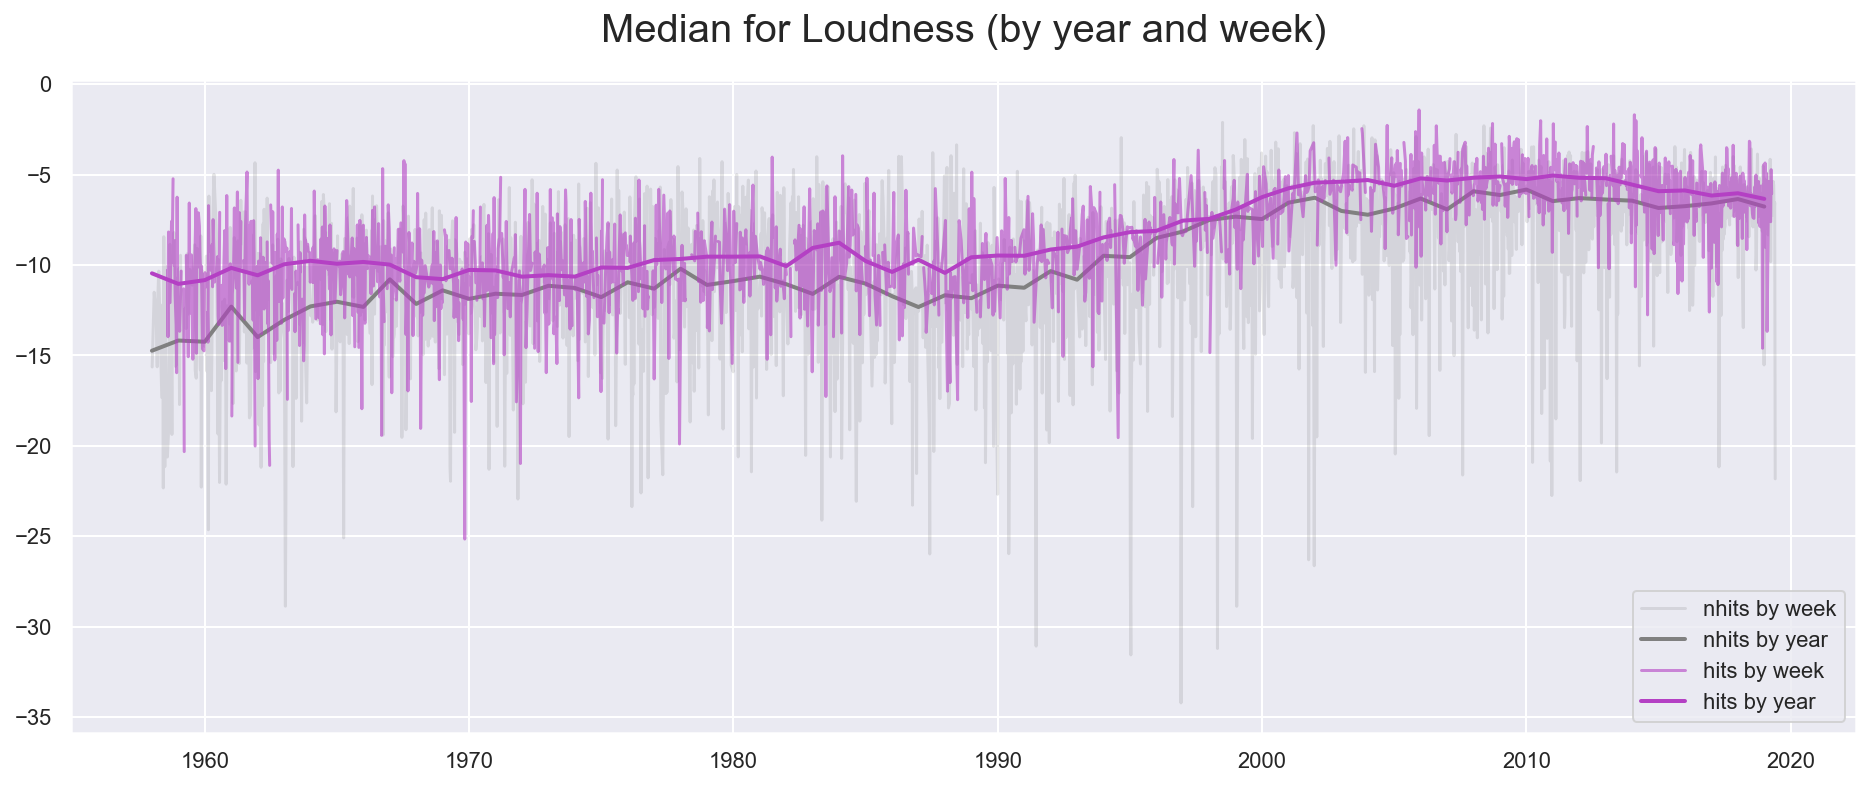

In [273]:
plot_detailed_feature(hits,nhits,'loudness')

_"The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks."_  [Spotify Track Features Description](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

As a feature, loudness is very consistently flat before the 1990s and then again starting in the early 2000s (i.e. at a higher level). We can clearly see that in the 1990s something in music changed, more and more songs were created that had a relatively higher loudness.

In general, we see that hits are having a higher median loudness but especially in the last few years we're seeing that hits and non-hits loudness do not diverge much anymore.

In [170]:
most_loudness = combined.loc[combined.loc[(combined['hit'] == True),:].loudness.nlargest(10).index,['date','loudness','hit','peak']]
most_loudness

date  \
artist                                             title                                          
Lana Cantrell                                      Like A Sunday Morning             1975-03-01   
Diplo, French Montana & Lil Pump Featuring Zhav... Welcome To The Party              2018-06-02   
Metallica                                          Cyanide                           2008-09-20   
Diana Ross & The Supremes                          Some Things You Never Get Used To 1968-06-08   
Eminem                                             Cold Wind Blows                   2010-07-10   
Luke Bryan                                         Move                              2016-12-10   
Diana Ross & The Supremes                          Love Child                        1968-11-23   
Eminem                                             Insane                            2009-06-06   
Barenaked Ladies                                   Too Little Too Late               2001-04-28   
Eminem                                             25 To Life                        2010-07-10   

                                                                                      loudness  \
artist                                             title                                         
Lana Cantrell                                      Like A Sunday Morning                 2.291   
Diplo, French Montana & Lil Pump Featuring Zhav... Welcome To The Party                  0.175   
Metallica                                          Cyanide                              -0.463   
Diana Ross & The Supremes                          Some Things You Never Get Used To    -0.507   
Eminem                                             Cold Wind Blows                      -0.517   
Luke Bryan                                         Move                                 -0.698   
Diana Ross & The Supremes                          Love Child                           -0.810   
Eminem                                             Insane                               -0.883   
Barenaked Ladies                                   Too Little Too Late                  -0.884   
Eminem                                             25 To Life                           -0.945   

                                                                                       hit  \
artist                                             title                                     
Lana Cantrell                                      Like A Sunday Morning              True   
Diplo, French Montana & Lil Pump Featuring Zhav... Welcome To The Party               True   
Metallica                                          Cyanide                            True   
Diana Ross & The Supremes                          Some Things You Never Get Used To  True   
Eminem                                             Cold Wind Blows                    True   
Luke Bryan                                         Move                               True   
Diana Ross & The Supremes                          Love Child                         True   
Eminem                                             Insane                             True   
Barenaked Ladies                                   Too Little Too Late                True   
Eminem                                             25 To Life                         True   

                                                                                      peak  
artist                                             title                                    
Lana Cantrell                                      Like A Sunday Morning              63.0  
Diplo, French Montana & Lil Pump Featuring Zhav... Welcome To The Party               78.0  
Metallica                                          Cyanide                            50.0  
Diana Ross & The Supremes                          Some Things You Never Get Used To  30.0  
Eminem                                

I believe especially Lana Cantrell's Like A Sunday Morning is a good example of an older song that falls into the loud category, while Cold Wind Blow by Eminem might be a good example for a newer song. _see examples above_

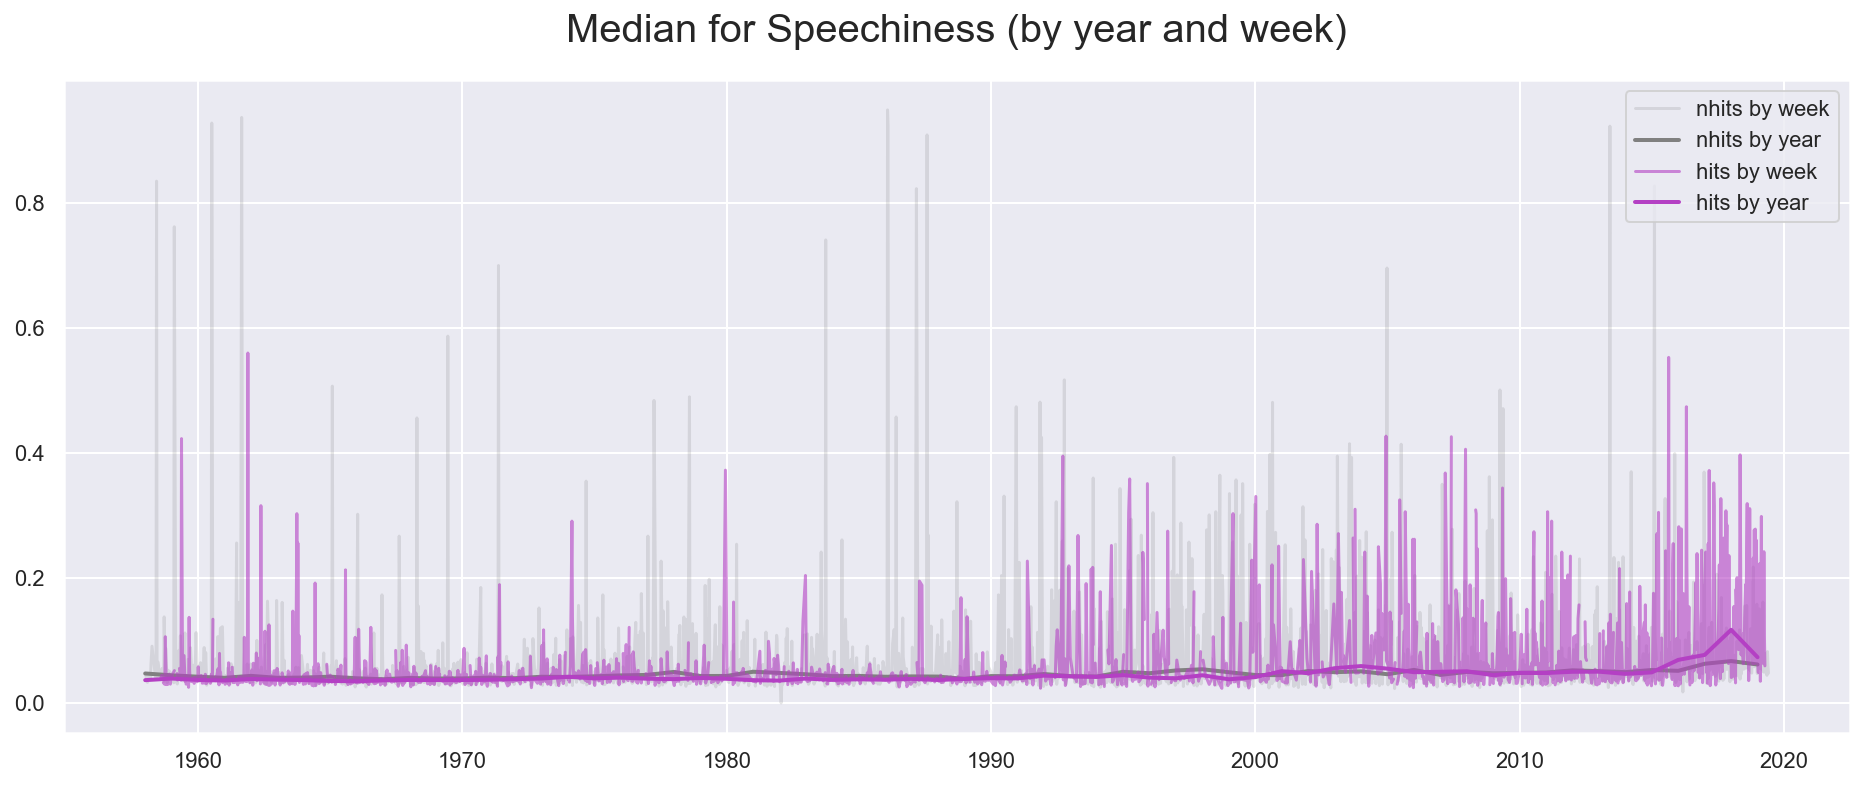

In [43]:
plot_detailed_feature(hits,nhits,'speechiness')

_"Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words."_  [Spotify Track Features Description](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

For Speechiness we can see an upward trend starting in the 1990s, with an increased density of high speechiness weeks and generally more high points, often going past 0.2 median (a rarety before 1990 but a common occurrance afterwards).

It's hard to pin-point what Speechiness is actually measuring as we're looking at the songs with the highest Speechiness. I would've assumed that the highest Speechiness would be found in Rap songs but judging from it there is a good mix of Country, Pop and Hip Hop music. This feature doesn't seem to be all that helpful for our analysis for now. There is no clear indicators and the feature itself is quite obtuse. With a lack of additional information of how this feature is put together, I've decided to abandon the feature for now.

In [171]:
most_speechiness = combined.loc[combined.loc[(combined['hit'] == True),:].speechiness.nlargest(10).index,['date','speechiness','hit','peak']]
most_speechiness

date  \
artist                              title                                                     
Chris Young Duet With Cassadee Pope Think Of You                                 2016-05-14   
Wu-Tang Clan                        C.R.E.A.M. (Cash Rules Everything Around Me) 1994-04-09   
Taylor Swift                        Should've Said No                            2008-06-21   
Hudson and Landry                   Ajax Airlines                                1972-01-22   
Reba McEntire                       I'll Be                                      2000-07-01   
Stan Freberg                        The Old Payola Roll Blues (Side I)           1960-02-29   
Hudson and Landry                   Ajax Liquor Store                            1971-07-03   
Cheech & Chong                      Sister Mary Elephant (Shudd-Up!)             1974-01-12   
Steve Martin                        Grandmother's Song                           1977-12-10   
Dickie Goodman                      The Touchables In Brooklyn                   1961-05-29   

                                                                                  speechiness  \
artist                              title                                                       
Chris Young Duet With Cassadee Pope Think Of You                                        0.951   
Wu-Tang Clan                        C.R.E.A.M. (Cash Rules Everything Around Me)        0.950   
Taylor Swift                        Should've Said No                                   0.941   
Hudson and Landry                   Ajax Airlines                                       0.924   
Reba McEntire                       I'll Be                                             0.924   
Stan Freberg                        The Old Payola Roll Blues (Side I)                  0.919   
Hudson and Landry                   Ajax Liquor Store                                   0.913   
Cheech & Chong                      Sister Mary Elephant (Shudd-Up!)                    0.882   
Steve Martin                        Grandmother's Song                                  0.858   
Dickie Goodman                      The Touchables In Brooklyn                          0.847   

                                                                                   hit  \
artist                              title                                                
Chris Young Duet With Cassadee Pope Think Of You                                  True   
Wu-Tang Clan                        C.R.E.A.M. (Cash Rules Everything Around Me)  True   
Taylor Swift                        Should've Said No                             True   
Hudson and Landry                   Ajax Airlines                                 True   
Reba McEntire                       I'll Be                                       True   
Stan Freberg                        The Old Payola Roll Blues (Side I)            True   
Hudson and Landry                   Ajax Liquor Store                             True   
Cheech & Chong                      Sister Mary Elephant (Shudd-Up!)              True   
Steve Martin                        Grandmother's Song                            True   
Dickie Goodman                      The Touchables In Brooklyn                    True   

                                                                                  peak  
artist                              title                                               
Chris Young Duet With Cassadee Pope Think Of You                                  40.0  
Wu-Tang Clan                        C.R.E.A.M. (Cash Rules Everything Around Me)  60.0  
Taylor Swift                        Should've Said No                             33.0  
Hudson and Landry                   Ajax Airlines                                 68.0  
Reba McEntire                       I'll Be                                       51.0  
Stan Freberg                        The Old Payola Roll Blues (Side I)       

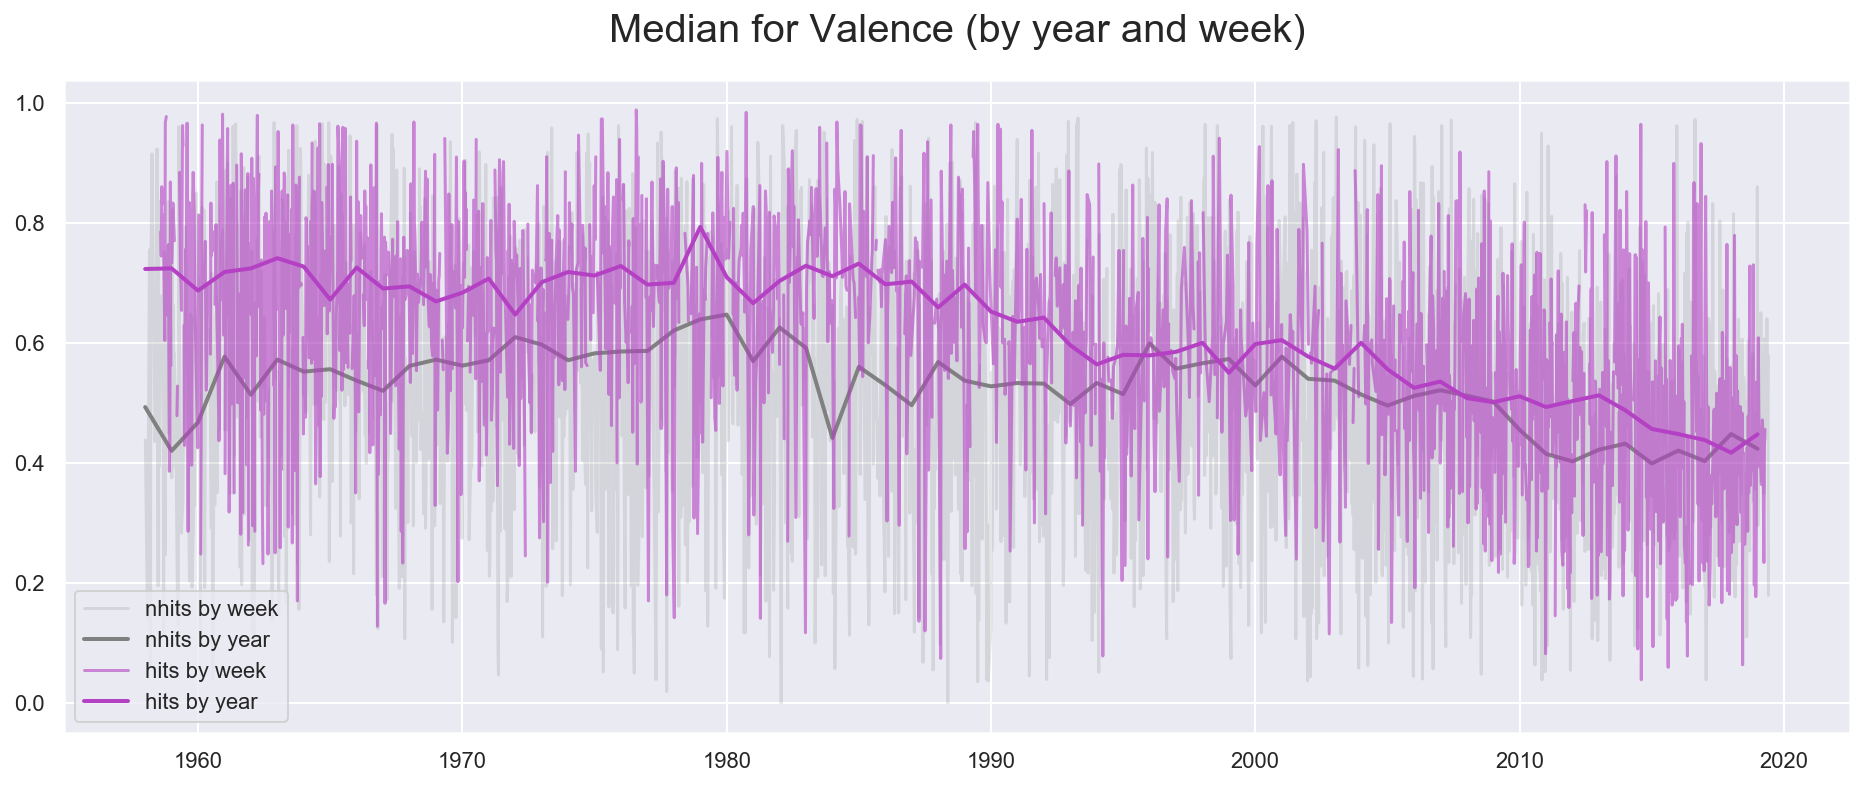

In [45]:
plot_detailed_feature(hits,nhits,'valence')

_A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)._ [Spotify Track Features Description](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

Valence is quite an interesting indicator as it attempts to measure positivity of music. In turn, we can see that the Hot 100 were generally more positive than non-hits all the way through the mid-1990s until Hot 100 drop down in valence in 1995 and then slowly continue to decrease to its current low-point having almost now visible difference between Hot 100 and Non-Hits.

Knowing that Valence has more and more decreased it might be interesting to see the songs with the highest and lowest valence.

In [46]:
highest_valence = combined.loc[combined.loc[(combined['hit'] == True),:].valence.nlargest(5).index,['date','valence','hit','peak']]
display(highest_valence)

lowest_valence = combined.loc[combined.loc[(combined['hit'] == True),:].valence.nsmallest(5).index,['date','valence','hit','peak']]
display(lowest_valence)

date  valence   hit  \
artist                title                                                    
Eddie Hodges          I'm Gonna Knock On Your Door 1961-07-10    0.991  True   
Four Tops             It's The Same Old Song       1965-08-21    0.991  True   
War                   Low Rider                    1975-10-25    0.990  True   
Katrina And The Waves Que Te Quiero                1985-11-09    0.989  True   
John Sebastian        Hideaway                     1976-07-31    0.988  True   

                                                    peak  
artist                title                               
Eddie Hodges          I'm Gonna Knock On Your Door  12.0  
Four Tops             It's The Same Old Song         5.0  
War                   Low Rider                      7.0  
Katrina And The Waves Que Te Quiero                 71.0  
John Sebastian        Hideaway                      95.0

date  \
artist                                             title                                                   
Georgie Young                                      Nine More Miles (The "Faster-Faster" Song) 1958-11-03   
Coldplay                                           Midnight                                   2014-05-10   
A$AP Rocky                                         L$D                                        2015-06-13   
The Pipes And Drums And The Military Band Of Th... Amazing Grace                              1972-07-01   
Drake                                              Jaded                                      2018-07-21   

                                                                                               valence  \
artist                                             title                                                 
Georgie Young                                      Nine More Miles (The "Faster-Faster" Song)   0.0000   
Coldplay                                           Midnight                                     0.0349   
A$AP Rocky                                         L$D                                          0.0352   
The Pipes And Drums And The Military Band Of Th... Amazing Grace                                0.0359   
Drake                                              Jaded                                        0.0371   

                                                                                                hit  \
artist                                             title                                              
Georgie Young                                      Nine More Miles (The "Faster-Faster" Song)  True   
Coldplay                                           Midnight                                    True   
A$AP Rocky                                         L$D                                         True   
The Pipes And Drums And The Military Band Of Th... Amazing Grace                               True   
Drake                                              Jaded                                       True   

                                                                                               peak  
artist                                             title                                             
Georgie Young                                      Nine More Miles (The "Faster-Faster" Song)  58.0  
Coldplay                                           Midnight                                    29.0  
A$AP Rocky                                         L$D                                         62.0  
The Pipes And Drums And The Military Band Of Th... Amazing Grace                               11.0  
Drake                                              Jaded                                       32.0

The highest valence songs are between 1961 and 1985, the lowest valence songs are a little more spread out but it's striking that 3 of the top 5 lowest valence songs were released in the 2010s. That being said Georgie Young might actually be an outlier and mislabeled.

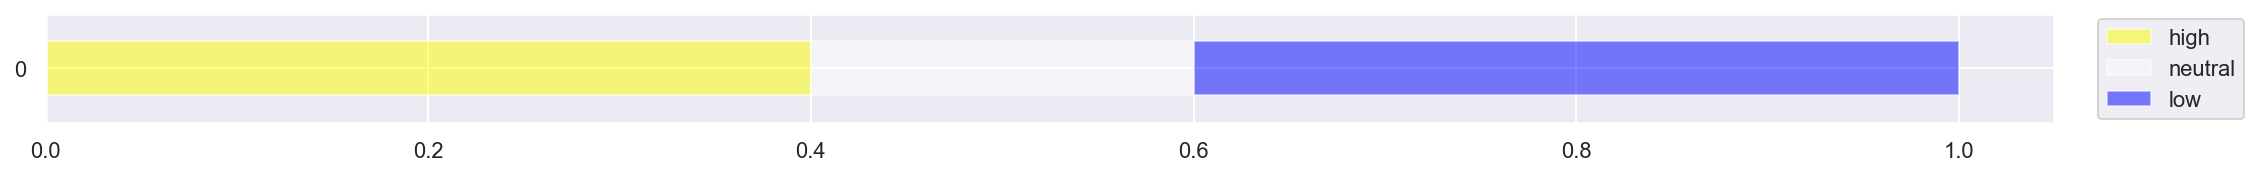

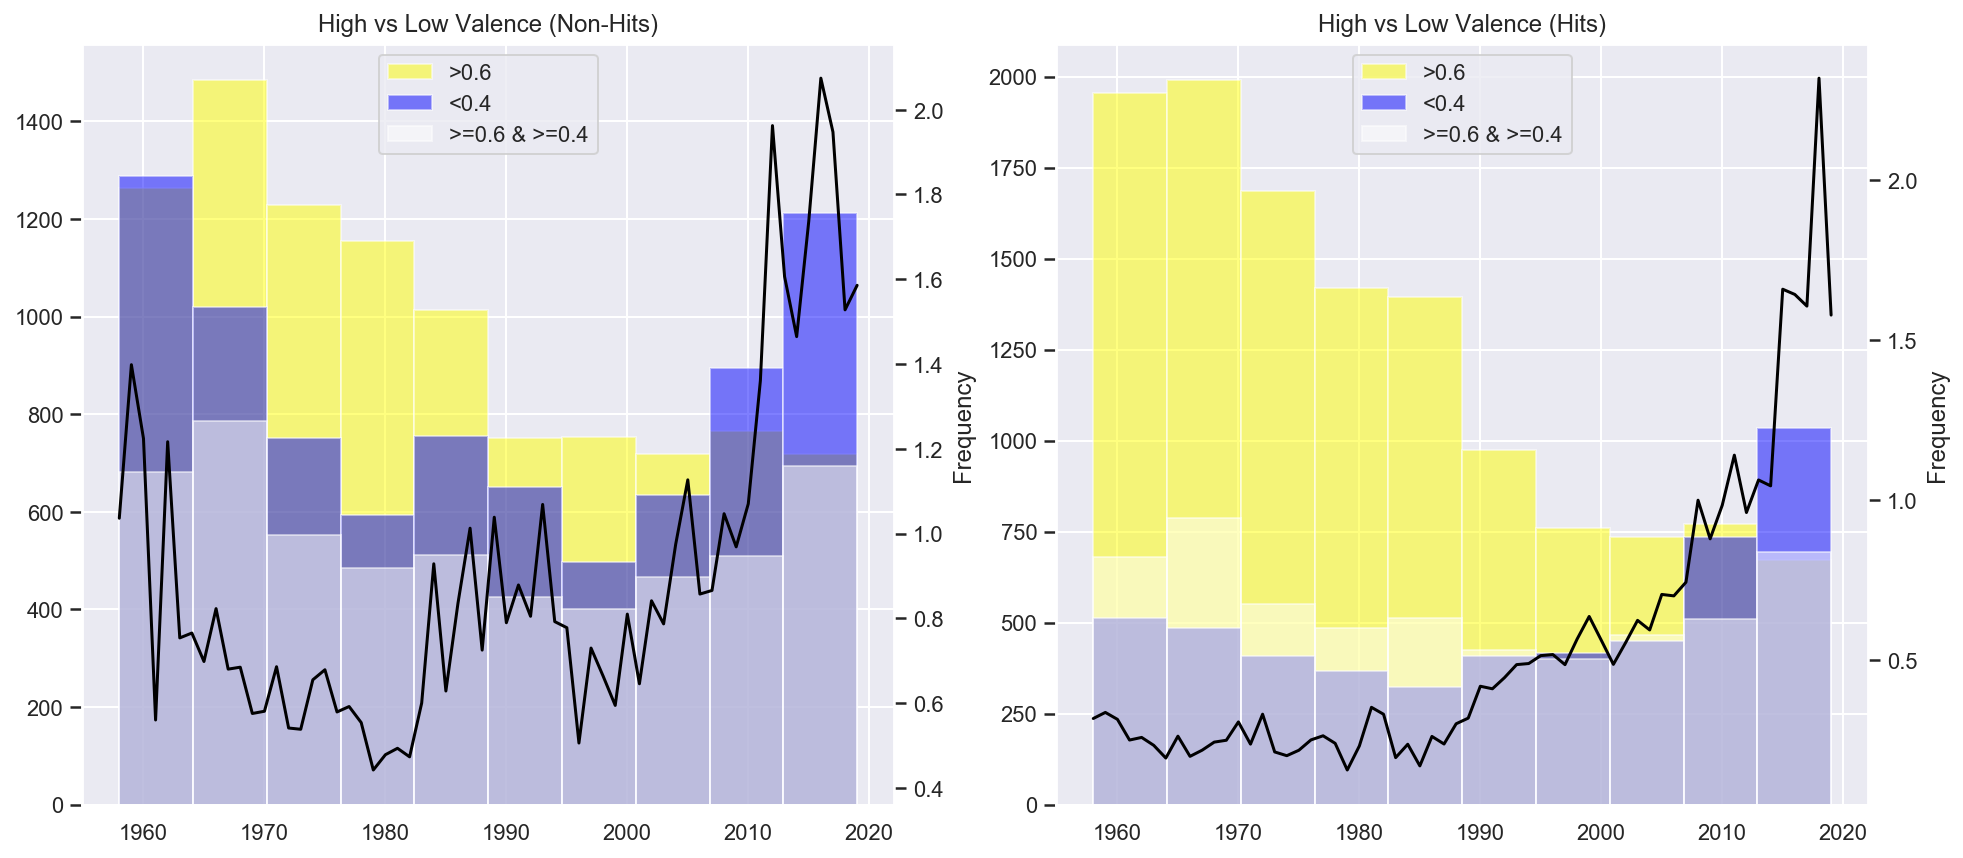

In [47]:
valence = combined.loc[:,['year','hit','valence']].reset_index(drop=True).dropna()

df2 = pd.DataFrame({'high':[0.4], 'neutral':[0.2],'low':[0.4]})
df2.plot.barh(stacked=True,color=['yellow','white','blue'],alpha=0.5,figsize=(18,1))
plt.legend(bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(1,2,figsize=(16,7))

_ = plt.subplot(1,2,1)
nhits_high_val = valence.loc[(valence.valence>0.6) & (valence.hit == False),['year','valence']]
nhits_neutral_val = valence.loc[(valence.valence>=0.4) & (valence.valence<=0.6) & (valence.hit == False),['year','valence']]
nhits_low_val = valence.loc[(valence.valence<0.4) & (valence.hit == False),['year','valence']]
_ = plt.hist(nhits_high_val.year,color='yellow',alpha=0.5, label='>0.6')
_ = plt.hist(nhits_low_val.year,color='blue',alpha=0.5, label='<0.4')
_ = plt.hist(nhits_neutral_val.year,color='white',alpha=0.5, label='>=0.6 & >=0.4')
_ = plt.legend(loc='upper center')

_ = plt.twinx()
nhits_val_ratio = nhits_low_val.groupby('year').count() / nhits_high_val.groupby('year').count()
_ = plt.plot(nhits_val_ratio.index,nhits_val_ratio, color=GrayP[2])
_ = plt.grid(False)
_ = plt.title('High vs Low Valence (Non-Hits)')
_ = plt.xlabel('Year')
_ = plt.ylabel('Frequency')

_ = plt.subplot(1,2,2)
hits_high_val = valence.loc[(valence.valence>0.6) & (valence.hit == True),['year','valence']]
hits_neutral_val = valence.loc[(valence.valence>=0.4) & (valence.valence<=0.6) & (valence.hit == True),['year','valence']]
hits_low_val = valence.loc[(valence.valence<0.4) & (valence.hit == True),['year','valence']]
_ = plt.hist(hits_high_val.year,color='yellow',alpha=0.5, label='>0.6')
_ = plt.hist(hits_low_val.year,color='blue',alpha=0.5, label='<0.4')
_ = plt.hist(nhits_neutral_val.year,color='white',alpha=0.5, label='>=0.6 & >=0.4')
_ = plt.legend(loc='upper center')

_ = plt.twinx()
hits_val_ratio = hits_low_val.groupby('year').count() / hits_high_val.groupby('year').count()
_ = plt.plot(hits_val_ratio.index,hits_val_ratio, color=GrayP[2])
_ = plt.grid(False)
_ = plt.title('High vs Low Valence (Hits)')
_ = plt.xlabel('Year')
_ = plt.ylabel('Frequency')

_NOTE: To avoid using an arbitrary cut-off point such as 0.5, I've introduced a neutral category for valence levels between 0.4 - 0.6._

While there is also a higher percentage of low valence music among Non-Hits the distinction between High-Valence and Low-Valence songs in the Hot 100 is a stark contrast if looked at across time. The number of low-valence songs in the Hot 100 before 2010 is consistently low while the high valence songs are dropping at a more or less linear-looking rate starting in the 1970s all the way through the 2000s. In the 2010s, low-valence songs are catching up with high-valence songs for the first time and in the 2020s low-valence surge beyond high-valence songs. Both Non-Hits and Hits are at an all-time high for low-valence songs.

The graphs show that we're increasingly listening to less positive sounding music in our Hot 100 charts as well as in our general popular music.

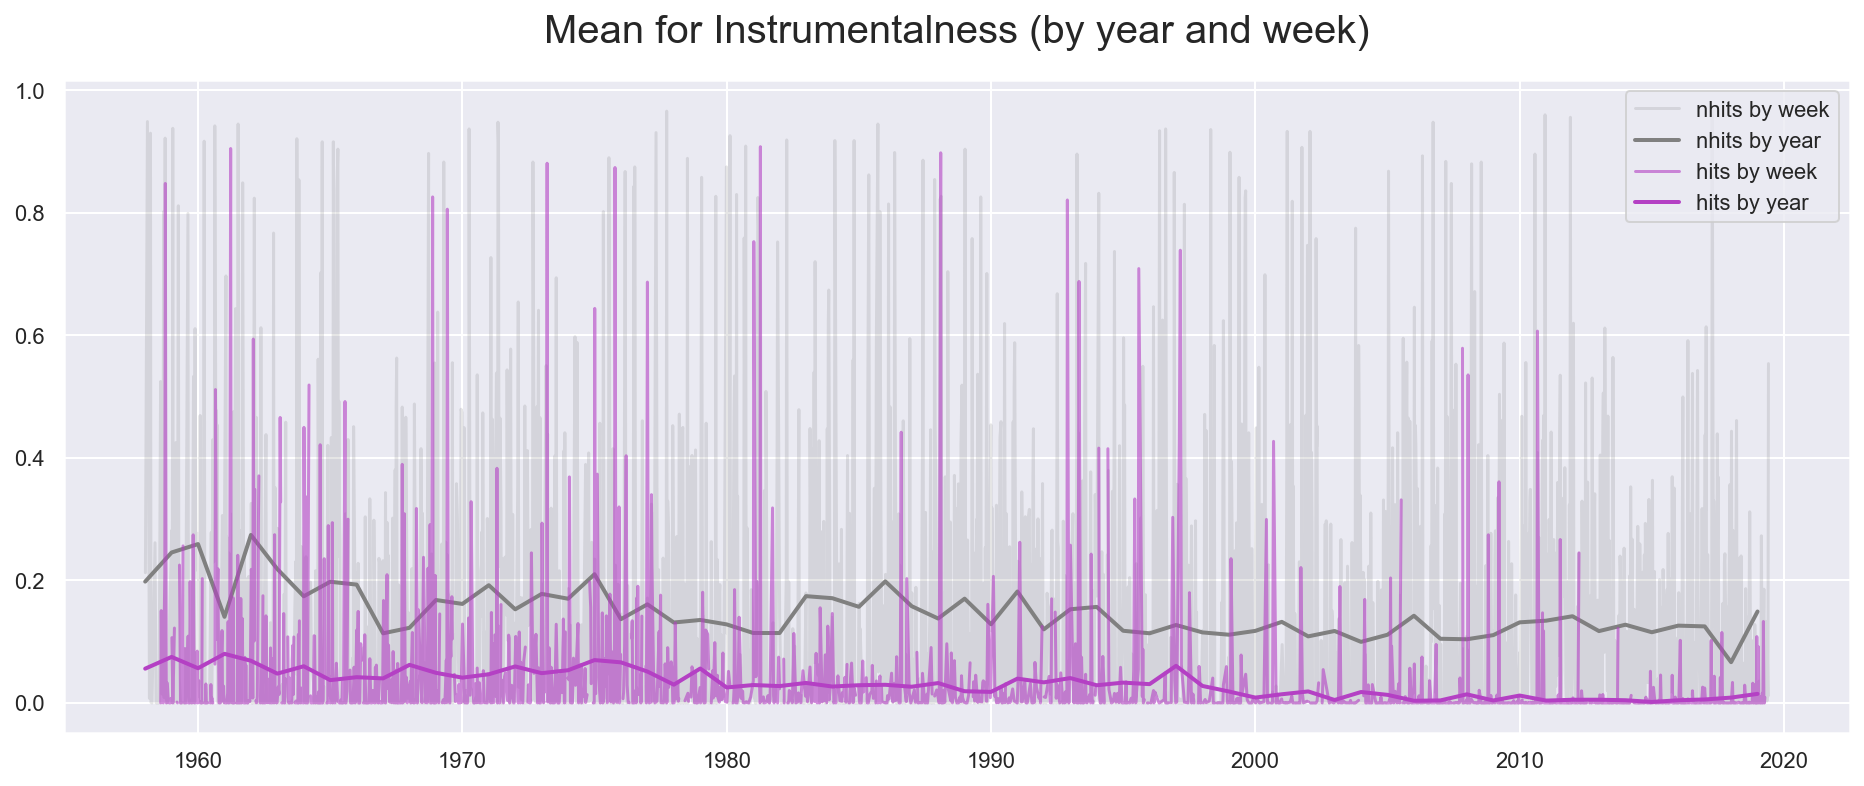

In [48]:
plot_detailed_feature(hits,nhits,'instrumentalness',method='mean')

_Instrumentalness predicts whether a track contains no vocals. [...] The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content._  [Spotify Track Features Description](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

Instrumentalness basically detects the vocal to instruments ratio. Rap songs are closer to 0 while classical music can be found at values > 0.5. It is an interesting feature due to the fact that the Hot 100 are strongly partial toward non-instrumental songs. This makes sense, especially in recent time, with the rise of Rap music but interestingly we can observe in the chart above that there has been a strong bias toward less instrumental songs throughout the entire history of the Hot 100. 

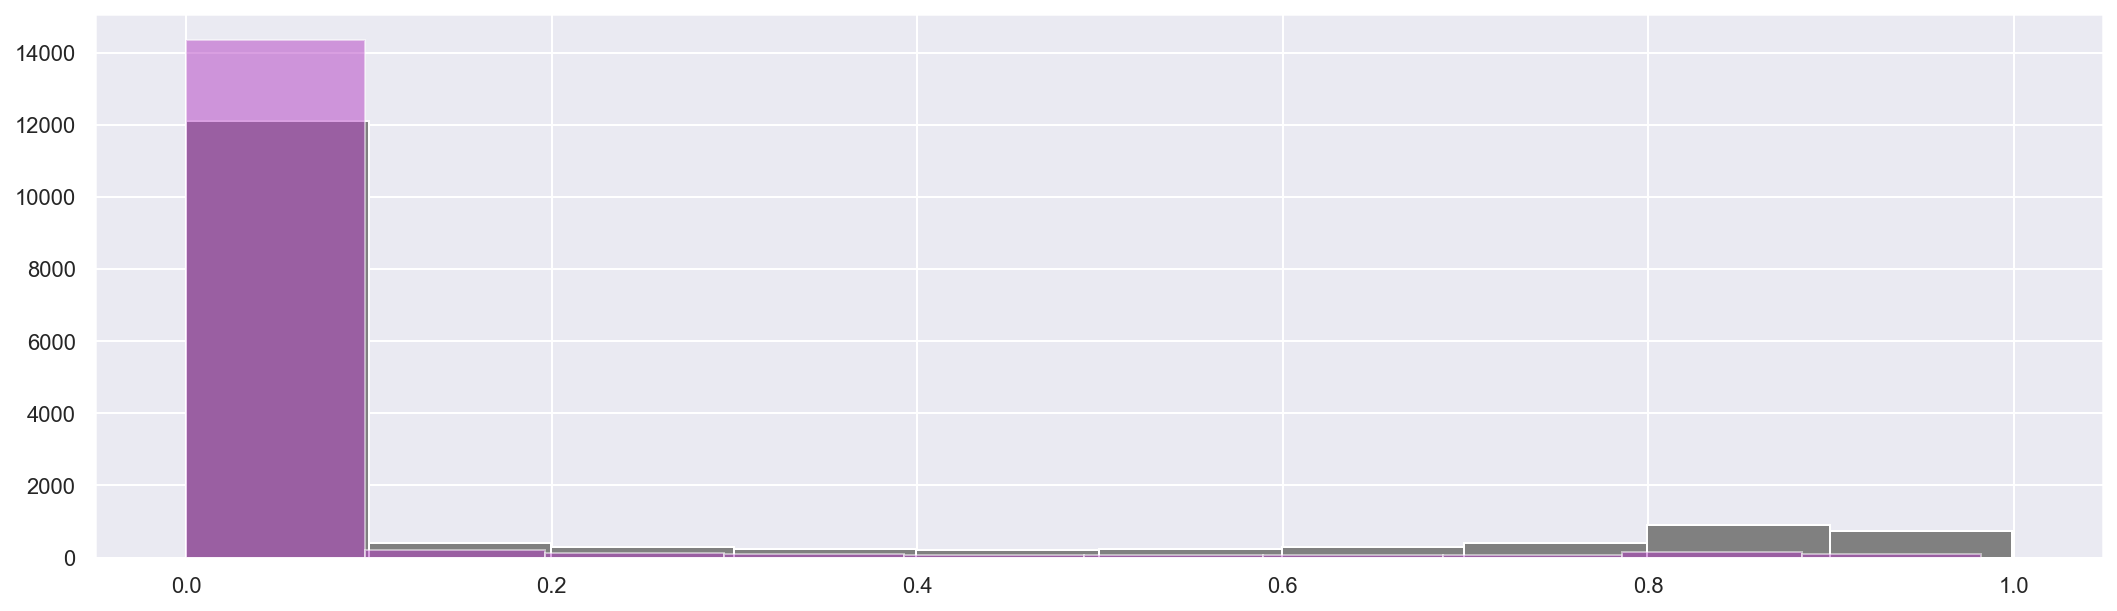

In [274]:
fig = plt.figure(figsize=(18,5))
_ = plt.hist(nhits['instrumentalness'].dropna(),color=GrayP[1])
_ = plt.hist(hits['instrumentalness'].dropna(),color=GrayP[0],alpha=0.5)

Another reason that makes this potentially interesting for Hot 100 detection is the fact that there are significant amounts of non-hits that fall into the instrumental category.

To better understand whether the distributions are statistically significantly different we'll use a Z-Test.

- **H0**: The Instrumentalness Distribution for Hits and Non-Hits is the same (i.e. the mean diff is 0).
- **H1**: The Instrumentalness Distribution for Hits and Non-Hits is not the same.
- **alpha** = 0.05

Hits Mean: 0.03421712542280131
Non-Hits Mean: 0.15391891948833092
Mean Diff: -0.11970179406552961
H0 Diff: 0
p: 0.0
CI: [-0.00545507  0.00552981]
ME: 0.0055609278768464785


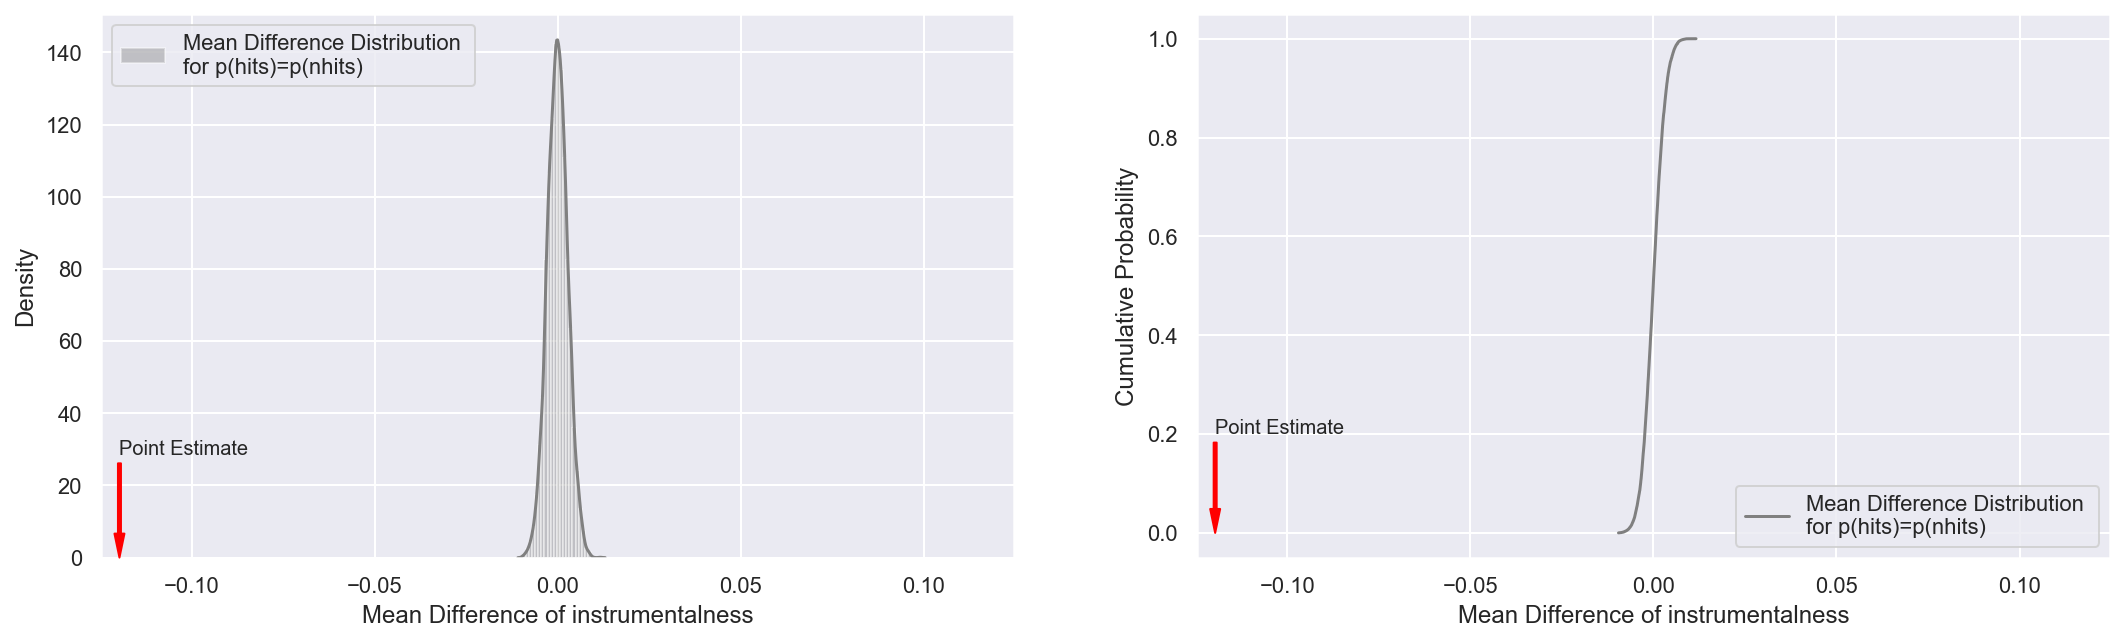

In [176]:
hits_instrumentalness = hits.instrumentalness.dropna()
nhits_instrumentalness = nhits.instrumentalness.dropna()

hits_nhits_diff = hits_instrumentalness.mean() - nhits_instrumentalness.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.instrumentalness.mean(), nhits.instrumentalness.mean(), hits_nhits_diff,h0_diff))

test_mean_diff(hits_instrumentalness,nhits_instrumentalness,hits_nhits_diff)

The p-value for the Point Estimate occuring if Hits and Non-Hits were equally distributed is <0.05 and we can therefore reject H0 and accept H1. The distributions are significantly different for p<0.001. Hence, we can consider using this feature in our model.

The last feature I'll have a close look at is duration (in ms).

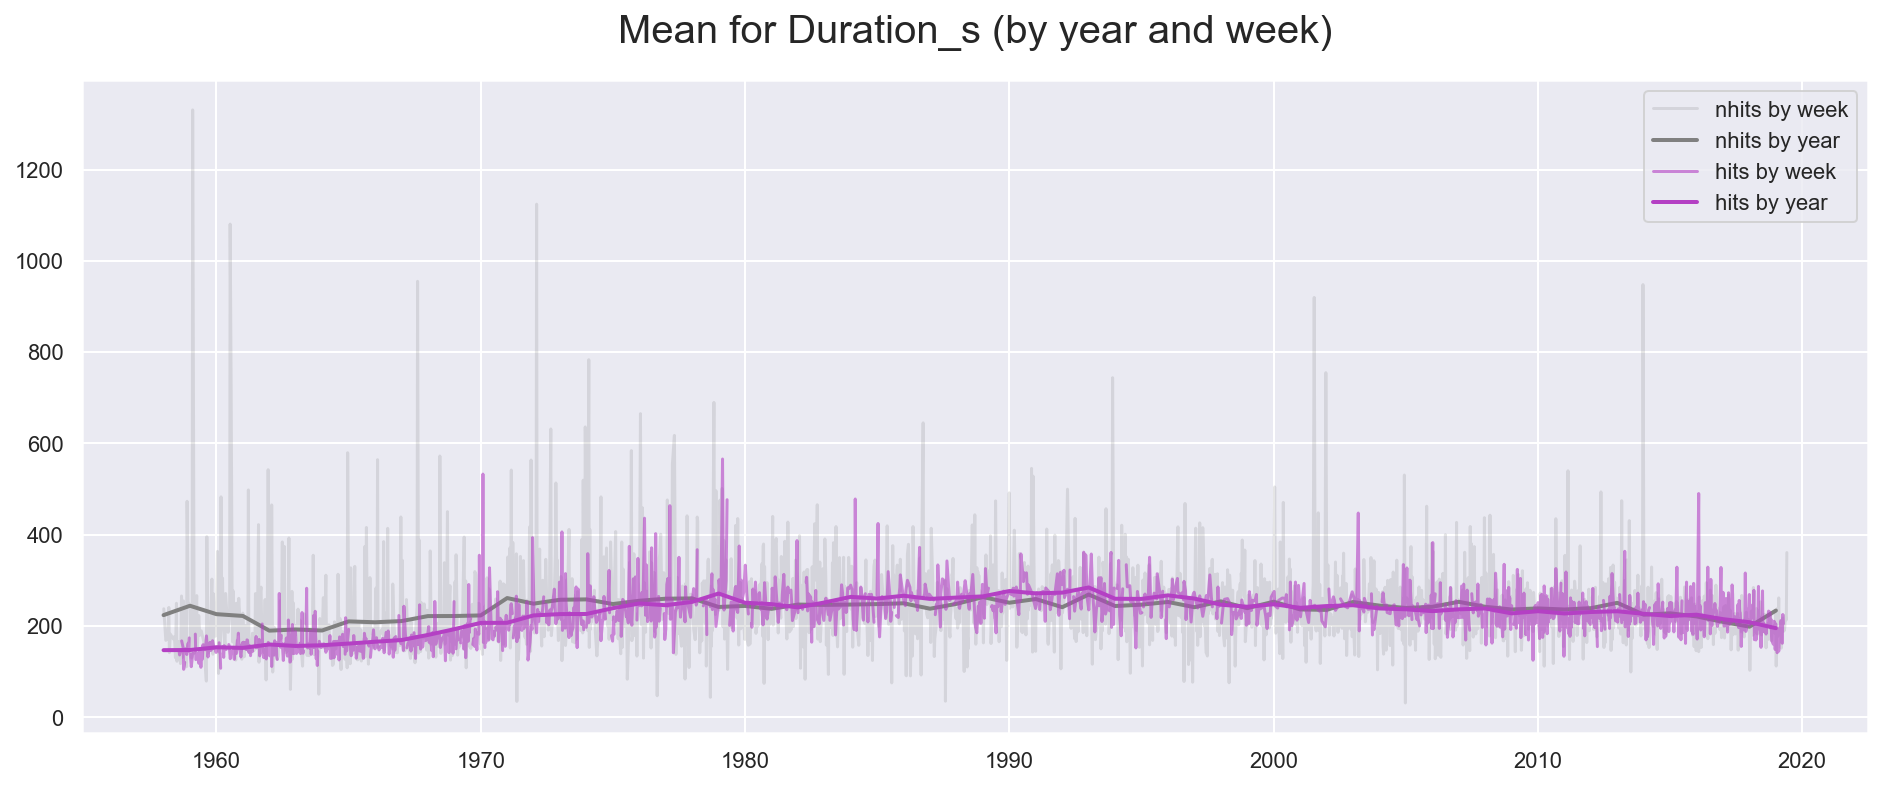

In [50]:
hits['duration_s'] = hits['duration_ms'] / 1000
nhits['duration_s'] = nhits['duration_ms'] / 1000
plot_detailed_feature(hits,nhits,'duration_s',method='mean')

_The duration of the track in milliseconds._ [Spotify Track Features Description](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

The duration of a track could be a good feature since the Hot 100 are looking at airplay on radios which have historically favored songs that have a specific length. To get a more intuitive sense the data has been downsampled to seconds. We can see that songs that made it onto the Hot 100 were generally not longer than 3 minutes but starting in the 1970s the average length of a track has gotten slightly longer (i.e. around the 4-minute mark), indicating a higher tolerance of radio to accept slightly longer tracks. However, we can see that non-hits while also having scaled down slightly, closer to the 4-minute mark there is stil a lot of songs that are significantly longer or shorter than the Hot 100 songs.

It's clear that `time_signature`,`key` and `mode` don't hold much value for us using the median as a summary statistic. Hence, we're going to look at them in a countplot.

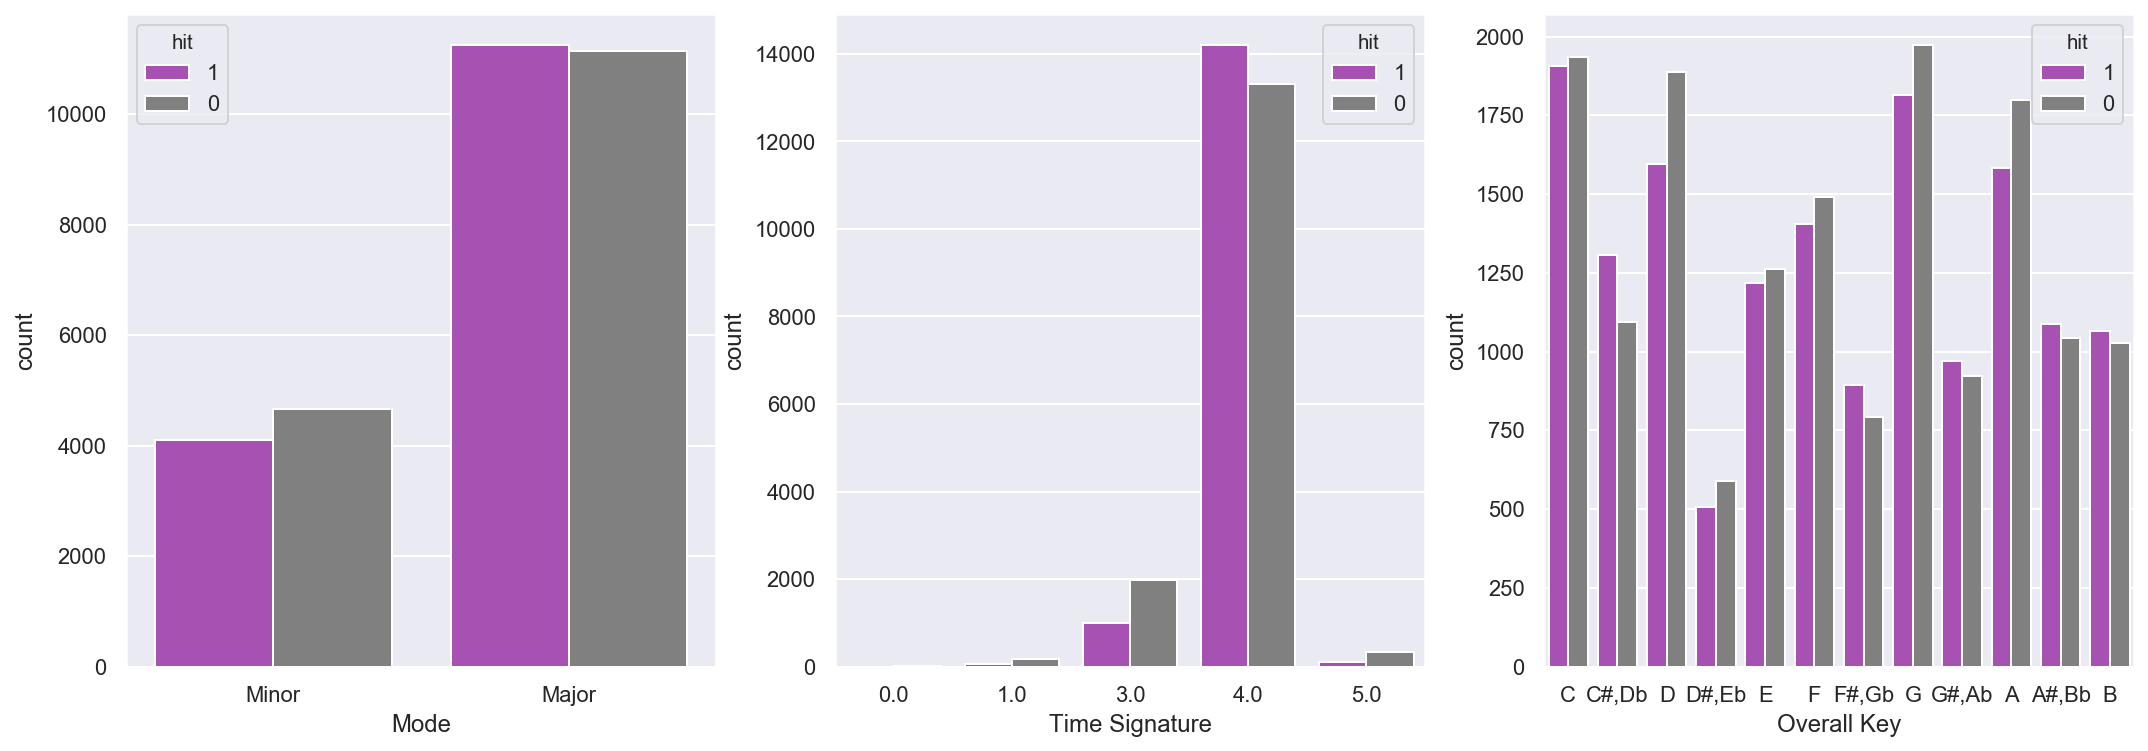

In [51]:
fig, ax = plt.subplots(1,3,figsize=(18,6))

_ = plt.subplot(1,3,1)
_ = sns.countplot('mode',data=analysis_train,hue='hit',hue_order=[1,0])
_ = plt.xticks([0,1],['Minor','Major'])
_ = plt.xlabel('Mode')

_ = plt.subplot(1,3,2)
_ = sns.countplot('time_signature',data=analysis_train,hue='hit',hue_order=[1,0])
_ = plt.xlabel('Time Signature')

_ = plt.subplot(1,3,3)
_ = sns.countplot('key',data=analysis_train,hue='hit',hue_order=[1,0])
_ = plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],['C','C#,Db','D','D#,Eb','E','F','F#,Gb','G','G#,Ab','A','A#,Bb','B'])
_ = plt.xlabel('Overall Key')

We can see general tendencies:
    - More than 2/3 of songs are written in Major
    - Most songs are written predominantly with a 4 time signature
    - Full keys (e.g. C,D,E or F) are relatively more popular than keys using semitones (e.g. C#,D# or F#)

Beyond that unfortunately it doesn't look like we can make out any major differences between hits and non-hits using these features. While these differences might still be statistically significant we'll have to check whether they hold enough predictive information to be used in a model.

# In conclusion

We've seen that multiple features (e.g. Danceability, Energy, Loudness, Instrumentalness and Valence) show quite interesting discrepancies to Non-Hits. Most of the discrepancies are within the spectrum of all songs, as would be expected. After all, hits are simply a subset of songs that are released every day. It would make sense that Hit songs are more streamlined and generally more prone to follow trends. We can see this especially during the 1990s and 2000s. Most of the features are narrowing into subsections of the entire spectrum of available popular music.

We were also able to make out distinct trends for certain time periods (e.g. before 1980s, between 1990s and 2000s or after the 2000s).

With these tools in-hand we're going to create a Machine Learning Model to predict the potential for a Song to become a hit.